In [ ]:
# pip install textstat

In [ ]:
#pip install spacy

In [ ]:
#pip install torch

In [ ]:
#pip install transformers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from collections import defaultdict, Counter
from tqdm import tqdm
import collections
import pickle
import re
import math
import textstat
import spacy
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

In [ ]:
train_df = pd.read_csv('WikiLarge_Train.csv',encoding='utf-8')
test_df = pd.read_csv('WikiLarge_Test.csv',encoding='utf-8')

In [ ]:
features_aoa = pd.read_csv('AoA_51715_words.csv',encoding='Windows-1252')
features_concrete = pd.read_csv('Concreteness_ratings_Brysbaert_et_al_BRM.txt',encoding='utf-8', delimiter = '\t')
features_dale_chall = pd.read_csv('dale_chall.txt',encoding='utf-8',delimiter='\t')

In [ ]:
# Initialize the stemmer
stemmer = PorterStemmer()
# Initialize the lemmatizer and load Spacy's English model
lemmatizer = WordNetLemmatizer()
nlp = spacy.load("en_core_web_sm")

# Helper functions

#regex to clean the original text
def clean_text(sentence):
    # Lowercasing
    sentence = sentence.lower()
    
    # Replace HTML entities
    html_entities = {
        '&ndash;': '–',
        '&amp;': '&',
        '&lt;': '<',
        '&gt;': '>',
        '&quot;': '"',
        '&apos;': "'",
        '&hellip;': '…',
        '&nbsp;': ' '
    }
    for entity, replacement in html_entities.items():
        sentence = sentence.replace(entity, replacement)

    # Replace -LRB-, -RRB-, -LSB-, and -RSB- with actual brackets
    sentence = sentence.replace('-lrb-', '(').replace('-rrb-', ')')
    sentence = sentence.replace('-lsb-', '[').replace('-rsb-', ']')
    # Correct punctuation spacing
    punctuation = re.compile(r'\s([.,;:’])')
    sentence = punctuation.sub(r'\1', sentence)
    # Removing cases of more than one consecutive punctuation mark
    pattern_punct = re.compile(r'[\.,;]{2,}')
    sentence = pattern_punct.sub(' ', sentence)
    # Replacing new lines with spaces
    sentence = sentence.replace('\n', ' ')
    # Replacing multiple spaces with a single space
    pattern_spaces = re.compile(r'\s+')
    sentence = pattern_spaces.sub(' ', sentence)
    # Stripping leading and trailing spaces
    sentence = sentence.strip() 
    return sentence

# Lemmatize the tokens
def text_lemmatizer(token_text):
    return [lemmatizer.lemmatize(word) for word in token_text]

def count_non_alphanumeric(tokens):
    return sum(1 for token in tokens if not token.isalnum())

#add Parts of Speech counts, limited to some common ones as it takes a long time to run
def add_pos_counts(dataframe):
    pos_counts = dataframe['tokens'].apply(lambda tokens: Counter(tag for word, tag in nltk.pos_tag(tokens)))
    for tag in ['NN', 'VB', 'JJ', 'RB']:
        dataframe[f'pos_{tag}_count'] = pos_counts.apply(lambda x: x.get(tag, 0))

# Calculating entropy of sentence as a measure of how many unique words
def lexical_diversity(text):
    return -sum(freq/len(text) * math.log(freq/len(text), 2) for freq in Counter(text).values())

# Function to sum how many words in a sentence have more than one meaning
def count_multiple_meanings(tokens):
    return sum(len(wordnet.synsets(word)) > 1 for word in tokens)


# Function to check if the entire string is numeric
def numeric_only(sentence):
    pattern = re.compile(r'^-?\d+(\.\d+)?$')
    return 1 if pattern.fullmatch(sentence.strip()) else 0

# Function to calculate Type-Token Ratio (TTR)
def calculate_type_token_ratio(lemmatized_text):
    # Tokenizing the lemmatized text by spaces (assuming it is space-separated)
    tokens = lemmatized_text.split() 
    # Number of unique lemmas
    types = set(tokens) 
    # Type-Token Ratio
    return len(types) / len(tokens) if len(tokens) > 0 else 0

# Function to bin different readability tests into easy, average, or difficult texts
def calculate_readability_features(dataframe):
    
#     # Add logic for updating categories based on 'clean_text'
    dataframe.loc[dataframe['clean_text'].isnull() | (dataframe['clean_text'] == 0), 'flesch_reading_ease_category'] = 2
    dataframe.loc[dataframe['clean_text'].isnull() | (dataframe['clean_text'] == 0), 'gunning_fog_category'] = 1
    dataframe.loc[dataframe['clean_text'].isnull() | (dataframe['clean_text'] == 0), 'smog_index_category'] = 2    
    
    # Flesch Reading Ease, higher score is easier to read
    # Categories: 0 = Easy, 1 = Average, 2 = Difficult
    dataframe['flesch_reading_ease'] = dataframe['clean_text'].apply(textstat.flesch_reading_ease)
    dataframe['flesch_reading_ease_category'] = dataframe['flesch_reading_ease'].apply(lambda x: 0 if x > 70 else (2 if x < 60 else 1))
    dataframe.drop(columns=['flesch_reading_ease'], inplace=True)

    # Gunning Fog is age a reader should be to understand a sentence
    # Categories: 0 = Easy, 1 = Average, 2 = Difficult
    dataframe['gunning_fog'] = dataframe['clean_text'].apply(textstat.gunning_fog)
    dataframe['gunning_fog_category'] = dataframe['gunning_fog'].apply(lambda x: 0 if x < 10 else (2 if x > 15 else 1))
    dataframe.drop(columns=['gunning_fog'], inplace=True)

    # Smog Index, similar to Gunning Fog
    # Categories: 0 = Easy, 1 = Average, 2 = Difficult 
    dataframe['smog_index'] = dataframe['clean_text'].apply(textstat.smog_index)
    dataframe['smog_index_category'] = dataframe['smog_index'].apply(lambda x: 0 if x < 10 else (2 if x > 15 else 1))
    dataframe.drop(columns=['smog_index'], inplace=True)

# Helper function for calculate_aoa_dalechall_features 
def calculate_additional_features(dataframe, average_aoa, dale_chall_lemmatized):
    lemma_texts = dataframe['lemmatized_text'].str.split()
    dale_chall_counts = lemma_texts.apply(lambda words: sum(word in dale_chall_lemmatized for word in words))
    high_aoa_counts = lemma_texts.apply(lambda words: sum((word in average_aoa) and (average_aoa[word] > 12) for word in words))
    low_aoa_counts = lemma_texts.apply(lambda words: sum((word in average_aoa) and (average_aoa[word] <= 12) for word in words))

    return dale_chall_counts, high_aoa_counts, low_aoa_counts
                                                                       
                                                                       
#function to calculate the counts of dale chall words and binned AoA words, lemmatized
#AoA ages are rounded and averaged as sum words are the same after lemmatizing
def calculate_aoa_dalechall_features(dataframe, features_aoa, features_dale_chall):
    # AoA DaleChall features using lemmatized words
    features_aoa.dropna(subset=['Word', 'AoA_Kup_lem'], inplace=True)
    aoa_lemmatized = text_lemmatizer(features_aoa['Word'])
    lemmatized_word_counts = {word: {'sum': 0, 'count': 0} for word in aoa_lemmatized}
    for idx, (word, aoa) in enumerate(zip(aoa_lemmatized, features_aoa['AoA_Kup_lem'])):
        lemmatized_word_counts[word]['sum'] += aoa
        lemmatized_word_counts[word]['count'] += 1
    average_aoa = {word: round(info['sum'] / info['count']) for word, info in lemmatized_word_counts.items()}
    dale_chall_lemmatized = set(text_lemmatizer(features_dale_chall['a']))
    
    dale_chall_counts, high_aoa_counts, low_aoa_counts = calculate_additional_features(dataframe, average_aoa, dale_chall_lemmatized)
    dataframe['dale_chall'] = dale_chall_counts
    dataframe['high_aoa'] = high_aoa_counts
    dataframe['low_aoa'] = low_aoa_counts

# Function to calculate features from concretness dataset on lemmatized words
def calculate_concreteness_features(dataframe, features_concrete):
    # Concreteness features using lemmatized words
    features_concrete['lemmatized_word'] = features_concrete['Word'].apply(lambda x: lemmatizer.lemmatize(x) if isinstance(x, str) else x)
    grouped_concreteness = features_concrete.groupby('lemmatized_word').agg({'Conc.M': 'mean', 'SUBTLEX': 'mean'}).reset_index()
    # Zipping features together to increase performance                                                                   
    concreteness_dict = dict(zip(grouped_concreteness['lemmatized_word'], grouped_concreteness['Conc.M']))
    subtlex_us_dict = dict(zip(grouped_concreteness['lemmatized_word'], grouped_concreteness['SUBTLEX']))
    
    # Using lemmatized text in the calculation of sentence features and using numpy arrays for faster calc
    num_sentences = len(dataframe['lemmatized_text'])
    concrete_count = np.zeros(num_sentences, dtype=int)
    non_concrete_count = np.zeros(num_sentences, dtype=int)
    mean_concreteness = np.zeros(num_sentences)
    mean_subtlex_us_frequency = np.zeros(num_sentences)

    for i, text in enumerate(dataframe['lemmatized_text']):
        words = text.split()
        concreteness_scores = [concreteness_dict[word] for word in words if word in concreteness_dict]
        subtlex_us_frequencies = [subtlex_us_dict[word] for word in words if word in subtlex_us_dict]

        if concreteness_scores:
            mean_concreteness[i] = np.mean(concreteness_scores)
            concrete_count[i] = sum(1 for score in concreteness_scores if score > 3)
            non_concrete_count[i] = len(concreteness_scores) - concrete_count[i]

        if subtlex_us_frequencies:
            mean_subtlex_us_frequency[i] = np.mean(subtlex_us_frequencies)
            
    # Store features in the dataframe
    dataframe['concrete_count'] = concrete_count
    dataframe['non_concrete_count'] = non_concrete_count
    dataframe['mean_concreteness'] = mean_concreteness
    dataframe['mean_subtlex_us_frequency'] = mean_subtlex_us_frequency




# Main function to extract features from a DataFrame
def extract_features(dataframe, features_aoa, features_dale_chall, features_concrete):
    
    # Clean and tokenize text
    dataframe['clean_text'] = dataframe['original_text'].apply(clean_text)
    dataframe['tokens'] = dataframe['clean_text'].apply(lambda x: word_tokenize(x))
    dataframe['lemmatized_text'] = dataframe['tokens'].apply(lambda x: " ".join(text_lemmatizer(x)))
    print('done lemmatizing')
    

   
    # Word and character counts
    dataframe['num_words'] = dataframe['tokens'].str.len()
    dataframe['num_characters'] = dataframe['clean_text'].str.len()
    dataframe['num_unique_words'] = dataframe['tokens'].apply(lambda x: len(set(x)))
    dataframe['ratio_unique_total_words'] = dataframe['num_unique_words'] / dataframe['num_words']
    dataframe['num_long_words'] = dataframe['tokens'].apply(lambda x: sum(1 for word in x if len(word) > 6))
    dataframe['syllable_count'] = dataframe['clean_text'].apply(textstat.syllable_count)
    dataframe['avg_syllables_per_word'] = dataframe['syllable_count'] / dataframe['num_words']
    dataframe['lexical_diversity'] = dataframe['clean_text'].apply(lexical_diversity) 
    dataframe['type_token_ratio'] = dataframe['lemmatized_text'].apply(calculate_type_token_ratio)
    dataframe['multiple_meanings_count'] = dataframe['tokens'].apply(count_multiple_meanings)
    dataframe['numeric_only'] = dataframe['clean_text'].apply(numeric_only)
    dataframe['only_punctuation'] = dataframe['original_text'].str.match(r'^\W+$').astype(int)
    dataframe['punctuation_count'] = dataframe['tokens'].apply(count_non_alphanumeric)
    print('done with counts')
    
    # Parts of Speech Counts
    add_pos_counts(dataframe)
    print('done with pos counts')
    # Readability features
    calculate_readability_features(dataframe)
    print('done with readability counts')
    # AoA DaleChall features
    calculate_aoa_dalechall_features(dataframe, features_aoa, features_dale_chall)
    print('done with aoa and dalechall')
    # Concreteness features
    calculate_concreteness_features(dataframe, features_concrete)    
    #some text is completely stripped, resulting in null calculations 
    #dataframe.fillna(0, inplace=True)

    return dataframe



In [ ]:
# Define a function to calculate parse tree depth
def calc_tree_depth(doc):
    return max([len(list(token.ancestors)) for token in doc], default=0)

# Function to extract features using SpaCy
def extract_spacy_features(sentence):
    # Handle empty or None sentences
    if not sentence:
        return {
            'parse_tree_depth': 0,
            'num_clauses': 0,
            'num_noun_chunks': 0,
            'num_named_entities': 0,
            'avg_word_len': 0,
            'num_nsubj': 0,
            'punctuation_complexity': 0,
            'unique_tenses': 0,
            'unique_named_entity_types': 0,
            'avg_dependency_distance': 0
        }
    
    # Process the text
    doc = nlp(sentence)
    
    # Extracting features
    parse_tree_depth = calc_tree_depth(doc)
    num_clauses = sum(1 for token in doc if token.dep_ == 'relcl')
    num_noun_chunks = sum(1 for chunk in doc.noun_chunks)
    num_named_entities = sum(1 for ent in doc.ents)
    avg_word_len = sum(len(token) for token in doc) / len(doc)
    num_nsubj = sum(1 for token in doc if token.dep_ == 'nsubj')

    # Punctuation Complexity
    punctuations = [token.text for token in doc if token.is_punct]
    punctuation_complexity = len(set(punctuations))
    
    # Different Tenses Count
    tenses = [token.tag_ for token in doc if token.tag_.startswith('V')]
    unique_tenses = len(set(tenses))

    # Different Named Entity Types Count
    named_entity_types = [ent.label_ for ent in doc.ents]
    unique_named_entity_types = len(set(named_entity_types))

    # Average Dependency Distance
    dependency_distances = [abs(token.i - token.head.i) for token in doc]
    avg_dependency_distance = sum(dependency_distances) / len(dependency_distances) if dependency_distances else 0

    # Returning the features as a dictionary
    return {
        'parse_tree_depth': parse_tree_depth,
        'num_clauses': num_clauses,
        'num_noun_chunks': num_noun_chunks,
        'num_named_entities': num_named_entities,
        'avg_word_len': avg_word_len,
        'num_nsubj': num_nsubj,
        'punctuation_complexity': punctuation_complexity,
        'unique_tenses': unique_tenses,
        'unique_named_entity_types': unique_named_entity_types,
        'avg_dependency_distance': avg_dependency_distance
    }

def extract_advanced_features(dataframe):
    feature_dicts = dataframe['clean_text'].apply(extract_spacy_features)
    for feature_name in ['parse_tree_depth', 'num_clauses', 'num_noun_chunks', 'num_named_entities', 
                         'avg_word_len', 'num_nsubj','punctuation_complexity','unique_tenses',
                         'unique_named_entity_types','avg_dependency_distance']:
        dataframe[feature_name] = feature_dicts.apply(lambda x: x[feature_name])
    

In [ ]:
test_df = extract_features(test_df, features_aoa, features_dale_chall, features_concrete)
extract_advanced_features(test_df)

In [ ]:
test_df.head()

In [ ]:
train_df = extract_features(train_df,features_aoa, features_dale_chall, features_concrete)
extract_advanced_features(train_df)

In [ ]:
train_df.head()

In [ ]:
def print_rows_with_nulls(dataframe):
    # Check for rows with null values
    rows_with_nulls = dataframe[dataframe.isna().any(axis=1)]
    
    # If there are any rows with null values, print them
    if not rows_with_nulls.empty:
        print("Rows with null values:")
        print(rows_with_nulls)
    else:
        print("No rows with null values found.")

In [ ]:
print_rows_with_nulls(train_df)
train_df.iloc[130152]

In [ ]:
#one row 130152, is ', ,' and returns null on two columns
train_df.fillna(0, inplace=True)

In [ ]:
print_rows_with_nulls(test_df.drop('label',axis=1))

In [ ]:
with open('train_df.pickle', 'wb') as f:
    pickle.dump(train_df, f)

In [2]:
#load pickled data
with open('train_df.pickle', 'rb') as f:
    train_df = pickle.load(f)

In [ ]:
with open('test_df.pickle', 'wb') as f:
    pickle.dump(test_df, f)

In [3]:
#load pickled data
with open('test_df.pickle', 'rb') as f:
    test_df = pickle.load(f)

In [4]:
# copy dataframes and remove all text for classifiers that don't use text
def df_copy_nontext(df):
    X = df.copy()
    X = X.drop(['original_text','clean_text','tokens','lemmatized_text'],axis=1)
    if 'id' in df.columns:
        X = X.drop('id',axis=1)
    y = X.pop('label')
    return X, y


X, y = df_copy_nontext(train_df)
X_test, _ = df_copy_nontext(test_df)

In [5]:
# Split the data into training and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42,stratify=y)

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns)


In [7]:
# Create a DummyClassifier with a 'most_frequent' strategy
dummy = DummyClassifier(strategy='most_frequent')

# Train the classifier on the training data
dummy.fit(X_train_scaled_df, y_train)

# Make predictions on the test data
y_pred = dummy.predict(X_val_scaled_df)

# Calculate the accuracy of the classifier
acc_score = accuracy_score(y_val, y_pred)
print("F1:", acc_score)

F1: 0.5


In [8]:
from sklearn.metrics import accuracy_score

In [9]:
lr_clf = LogisticRegression(random_state=42, n_jobs=-1).fit(X_train_scaled_df,y_train)
preds = lr_clf.predict(X_val_scaled_df)
acc_score = accuracy_score(y_val, preds)
print(acc_score)

0.6556721479301298


In [21]:
import numpy as np
import pandas as pd



# Compare predictions with true labels
incorrect = preds != y_val

# Using the boolean mask to get incorrectly labeled rows in validation sets
incorrect_X_val = X_val[incorrect]
incorrect_y_val = y_val[incorrect]

# Convert the boolean mask in the context of X_val to the original index
incorrect_indexes_in_X = X_val.index[incorrect]

# Use these indexes to get the incorrectly labeled rows from the original DataFrame
incorrect_X = X.loc[incorrect_indexes_in_X]
incorrect_y = y.loc[incorrect_indexes_in_X]

# Now incorrect_X and incorrect_y correspond to the rows in the original X and y that were incorrectly labeled
# You can examine these to understand what went wrong
incorrect_X['label'] = incorrect_y
incorrect_X

,num_words,num_characters,num_unique_words,ratio_unique_total_words,num_long_words,syllable_count,avg_syllables_per_word,lexical_diversity,type_toke_ration,multiple_meanings_count,...,num_clauses,num_noun_chunks,num_named_entities,avg_word_len,num_nsubj,punctuation_complexity,unique_tenses,unique_named_entity_types,avg_dependency_distance,label
255362,17,93,17,1.000000,5,28,1.647059,4.056363,1.000000,9,...,0,4,0,4.588235,2,1,2,0,2.411765,0
97387,34,167,27,0.794118,5,34,1.000000,4.050644,0.794118,21,...,0,9,0,4.000000,4,4,3,0,3.294118,1
350489,19,88,16,0.842105,4,25,1.315789,3.973508,0.842105,11,...,0,7,0,3.736842,1,3,1,0,2.315789,0
107656,3,21,3,1.000000,2,6,2.000000,3.594466,1.000000,3,...,0,1,0,6.333333,0,0,0,0,1.000000,1
63306,8,33,7,0.875000,1,9,1.125000,3.813207,0.875000,6,...,0,2,0,3.375000,0,1,2,0,1.750000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208118,51,222,32,0.627451,5,56,1.098039,4.285639,0.627451,24,...,1,10,0,3.509804,1,4,3,0,3.843137,1
309855,16,64,16,1.000000,2,14,0.875000,4.162756,1.000000,7,...,0,4,0,3.125000,1,3,1,0,3.125000,0
232002,29,119,21,0.724138,7,29,1.000000,4.553719,0.724138,10,...,0,6,0,3.413793,1,7,2,0,4.862069,0
185390,17,80,16,0.941176,6,20,1.176471,4.377817,0.941176,10,...,0,4,0,3.941176,0,2,2,0,2.764706,1


In [22]:
incorrect_X['label'].value_counts()

1    11341
0    10185
Name: label, dtype: int64

In [18]:
# Compare predictions with true labels
incorrect = preds != y_val

# Get the indexes of incorrect predictions
incorrect_indexes = np.where(incorrect)[0]

# If you want to view the corresponding rows in the original DataFrame
# assuming you have a DataFrame named 'dataframe' and 'X_val_scaled_df' has same index as original DataFrame
original_dataframe = X.loc[X_val_scaled_df.index[incorrect_indexes]]
original_dataframe['label'] = y_val[incorrect_indexes]
original_dataframe.sample(10)

KeyError: '[0, 6, 12, 19, 24, 34, 39, 41, 47, 48, 53, 65, 70, 75, 82, 83, 91, 92, 96, 97, 99, 103, 108, 111, 112, 121, 122, 126, 130, 134, 138, 143, 146, 148, 152, 155, 160, 164, 170, 172, 174, 179, 184, 192, 193, 194, 197, 203, 204, 208, 210, 211, 212, 214, 217, 218, 221, 222, 225, 232, 233, 234, 238, 247, 250, 255, 259, 262, 265, 269, 276, 279, 280, 282, 285, 288, 291, 294, 301, 303, 307, 310, 314, 316, 317, 324, 326, 327, 328, 329, 332, 333, 340, 342, 344, 351, 352, 354, 355, 357, 359, 360, 361, 362, 363, 364, 365, 371, 376, 380, 384, 387, 390, 391, 393, 395, 400, 401, 410, 418, 420, 424, 434, 436, 442, 449, 451, 458, 459, 460, 461, 465, 468, 471, 472, 476, 481, 482, 484, 487, 488, 493, 495, 497, 500, 502, 503, 506, 508, 511, 512, 517, 518, 523, 533, 544, 553, 555, 556, 561, 566, 571, 572, 576, 585, 586, 589, 590, 591, 597, 598, 599, 600, 612, 617, 622, 623, 626, 627, 631, 634, 637, 639, 644, 645, 650, 651, 652, 653, 662, 663, 668, 672, 673, 674, 679, 684, 686, 687, 690, 695, 696, 697, 701, 703, 707, 708, 710, 711, 713, 715, 718, 724, 725, 726, 728, 729, 730, 731, 738, 741, 742, 746, 752, 753, 755, 759, 762, 767, 771, 772, 773, 776, 780, 786, 788, 789, 790, 791, 797, 798, 801, 802, 809, 811, 822, 828, 831, 832, 833, 834, 836, 842, 851, 853, 856, 858, 859, 870, 875, 878, 879, 886, 888, 890, 892, 894, 896, 899, 902, 903, 907, 912, 913, 914, 915, 919, 926, 933, 934, 937, 940, 943, 945, 947, 948, 957, 958, 959, 960, 963, 968, 969, 972, 973, 975, 976, 978, 985, 987, 989, 990, 994, 995, 997, 1003, 1009, 1013, 1014, 1015, 1019, 1030, 1031, 1032, 1033, 1045, 1051, 1053, 1058, 1059, 1060, 1061, 1062, 1066, 1068, 1069, 1071, 1072, 1084, 1086, 1088, 1090, 1092, 1093, 1096, 1104, 1106, 1109, 1112, 1123, 1126, 1130, 1132, 1139, 1147, 1150, 1151, 1155, 1160, 1162, 1163, 1168, 1171, 1174, 1177, 1183, 1184, 1189, 1194, 1206, 1208, 1211, 1212, 1215, 1219, 1221, 1222, 1225, 1227, 1229, 1232, 1234, 1236, 1240, 1241, 1248, 1252, 1257, 1258, 1263, 1264, 1268, 1272, 1273, 1278, 1282, 1283, 1284, 1288, 1291, 1295, 1296, 1298, 1312, 1317, 1320, 1325, 1326, 1330, 1331, 1333, 1334, 1336, 1342, 1345, 1346, 1350, 1355, 1356, 1358, 1359, 1373, 1374, 1378, 1381, 1388, 1390, 1393, 1394, 1395, 1398, 1399, 1400, 1403, 1411, 1416, 1419, 1422, 1429, 1430, 1432, 1438, 1440, 1441, 1442, 1450, 1451, 1453, 1455, 1456, 1461, 1463, 1466, 1468, 1470, 1472, 1475, 1479, 1482, 1488, 1493, 1500, 1501, 1502, 1509, 1519, 1520, 1526, 1528, 1532, 1535, 1536, 1547, 1556, 1557, 1560, 1563, 1575, 1579, 1581, 1586, 1592, 1595, 1605, 1612, 1613, 1614, 1616, 1618, 1624, 1626, 1628, 1629, 1636, 1644, 1646, 1647, 1648, 1653, 1654, 1656, 1659, 1662, 1666, 1668, 1669, 1674, 1675, 1678, 1683, 1684, 1687, 1689, 1690, 1693, 1694, 1696, 1699, 1702, 1703, 1710, 1712, 1714, 1718, 1723, 1725, 1730, 1731, 1732, 1741, 1742, 1745, 1748, 1753, 1758, 1759, 1761, 1766, 1768, 1770, 1772, 1773, 1775, 1778, 1780, 1790, 1791, 1793, 1795, 1798, 1800, 1811, 1818, 1825, 1827, 1829, 1831, 1835, 1840, 1845, 1846, 1847, 1848, 1853, 1858, 1859, 1868, 1869, 1875, 1882, 1883, 1885, 1893, 1899, 1900, 1908, 1911, 1913, 1918, 1928, 1930, 1931, 1934, 1938, 1939, 1942, 1950, 1954, 1961, 1964, 1966, 1968, 1973, 1974, 1975, 1976, 1978, 1979, 1981, 1983, 1987, 1997, 2002, 2004, 2006, 2008, 2010, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2025, 2027, 2030, 2034, 2038, 2043, 2046, 2049, 2058, 2059, 2073, 2076, 2077, 2082, 2091, 2097, 2098, 2099, 2102, 2103, 2104, 2108, 2116, 2118, 2119, 2120, 2123, 2130, 2132, 2134, 2146, 2148, 2149, 2150, 2151, 2153, 2156, 2162, 2171, 2176, 2181, 2182, 2188, 2190, 2193, 2199, 2202, 2215, 2216, 2217, 2222, 2226, 2229, 2232, 2236, 2244, 2246, 2249, 2262, 2266, 2268, 2271, 2274, 2278, 2283, 2285, 2291, 2292, 2299, 2302, 2306, 2314, 2315, 2317, 2318, 2320, 2323, 2330, 2331, 2334, 2338, 2339, 2343, 2344, 2345, 2348, 2352, 2354, 2357, 2358, 2362, 2365, 2366, 2367, 2368, 2369, 2376, 2382, 2384, 2387, 2390, 2392, 2398, 2409, 2412, 2420, 2421, 2424, 2426, 2430, 2431, 2439, 2440, 2444, 2445, 2448, 2453, 2455, 2456, 2457, 2459, 2460, 2461, 2463, 2470, 2473, 2476, 2479, 2480, 2483, 2486, 2489, 2490, 2493, 2495, 2496, 2502, 2504, 2508, 2515, 2517, 2519, 2522, 2525, 2526, 2529, 2534, 2535, 2536, 2540, 2546, 2558, 2562, 2563, 2565, 2567, 2568, 2569, 2571, 2572, 2574, 2576, 2577, 2578, 2579, 2584, 2592, 2594, 2596, 2600, 2604, 2607, 2610, 2613, 2614, 2617, 2618, 2619, 2620, 2621, 2622, 2624, 2626, 2628, 2629, 2644, 2646, 2650, 2653, 2654, 2657, 2658, 2661, 2664, 2666, 2667, 2668, 2675, 2691, 2693, 2694, 2697, 2698, 2700, 2702, 2703, 2707, 2713, 2720, 2721, 2734, 2736, 2739, 2740, 2743, 2744, 2747, 2749, 2759, 2766, 2767, 2772, 2777, 2783, 2785, 2788, 2799, 2801, 2802, 2805, 2807, 2812, 2813, 2815, 2817, 2819, 2820, 2823, 2828, 2829, 2833, 2836, 2839, 2840, 2846, 2865, 2872, 2878, 2881, 2883, 2885, 2886, 2887, 2891, 2892, 2894, 2897, 2903, 2904, 2905, 2910, 2911, 2917, 2918, 2922, 2924, 2930, 2934, 2936, 2943, 2944, 2945, 2946, 2947, 2952, 2955, 2962, 2966, 2967, 2971, 2973, 2974, 2975, 2976, 2977, 2981, 2982, 2983, 2990, 2992, 2999, 3003, 3011, 3014, 3017, 3019, 3022, 3023, 3025, 3027, 3030, 3032, 3036, 3037, 3042, 3045, 3053, 3054, 3055, 3058, 3059, 3060, 3065, 3070, 3071, 3083, 3087, 3089, 3101, 3102, 3106, 3108, 3110, 3111, 3115, 3117, 3131, 3132, 3135, 3140, 3144, 3147, 3152, 3153, 3155, 3158, 3159, 3164, 3165, 3169, 3173, 3175, 3180, 3190, 3191, 3200, 3205, 3208, 3210, 3212, 3213, 3215, 3219, 3223, 3226, 3227, 3230, 3231, 3234, 3251, 3252, 3255, 3261, 3263, 3265, 3272, 3274, 3280, 3281, 3284, 3286, 3287, 3290, 3300, 3304, 3305, 3308, 3311, 3316, 3317, 3319, 3324, 3328, 3329, 3331, 3334, 3335, 3340, 3342, 3346, 3350, 3352, 3353, 3355, 3359, 3362, 3365, 3368, 3369, 3371, 3374, 3377, 3378, 3380, 3385, 3387, 3388, 3390, 3391, 3393, 3395, 3397, 3398, 3404, 3406, 3409, 3414, 3417, 3419, 3421, 3422, 3425, 3426, 3427, 3432, 3443, 3447, 3449, 3452, 3456, 3458, 3459, 3463, 3465, 3467, 3468, 3470, 3473, 3474, 3485, 3489, 3492, 3493, 3495, 3496, 3500, 3502, 3505, 3512, 3513, 3521, 3527, 3529, 3530, 3535, 3537, 3543, 3549, 3551, 3552, 3556, 3562, 3563, 3566, 3568, 3573, 3575, 3578, 3581, 3587, 3590, 3593, 3594, 3596, 3599, 3605, 3609, 3627, 3631, 3632, 3639, 3640, 3642, 3643, 3644, 3650, 3655, 3658, 3663, 3664, 3665, 3670, 3673, 3675, 3677, 3678, 3679, 3681, 3686, 3688, 3690, 3693, 3700, 3714, 3727, 3728, 3730, 3732, 3733, 3735, 3737, 3746, 3748, 3754, 3757, 3759, 3761, 3764, 3766, 3770, 3775, 3778, 3781, 3783, 3784, 3785, 3786, 3787, 3788, 3792, 3795, 3796, 3801, 3806, 3807, 3808, 3810, 3815, 3818, 3819, 3822, 3829, 3845, 3846, 3850, 3854, 3865, 3870, 3871, 3872, 3874, 3878, 3884, 3888, 3892, 3899, 3902, 3904, 3906, 3908, 3910, 3911, 3914, 3915, 3919, 3926, 3927, 3933, 3936, 3937, 3961, 3962, 3966, 3967, 3968, 3971, 3974, 3977, 3979, 3984, 3986, 3997, 4004, 4006, 4008, 4011, 4013, 4017, 4018, 4021, 4024, 4025, 4026, 4029, 4039, 4046, 4048, 4051, 4055, 4056, 4060, 4062, 4067, 4070, 4073, 4079, 4086, 4090, 4091, 4100, 4102, 4103, 4104, 4107, 4111, 4113, 4120, 4121, 4123, 4128, 4129, 4132, 4136, 4142, 4143, 4145, 4147, 4153, 4154, 4156, 4161, 4163, 4177, 4181, 4185, 4187, 4190, 4191, 4205, 4207, 4208, 4211, 4219, 4221, 4222, 4224, 4226, 4232, 4233, 4235, 4237, 4238, 4240, 4241, 4249, 4252, 4255, 4264, 4265, 4269, 4274, 4281, 4286, 4293, 4295, 4304, 4306, 4310, 4311, 4314, 4315, 4319, 4320, 4322, 4323, 4325, 4328, 4336, 4339, 4353, 4354, 4355, 4361, 4365, 4366, 4367, 4369, 4371, 4377, 4380, 4383, 4385, 4387, 4391, 4395, 4399, 4400, 4401, 4403, 4406, 4407, 4408, 4409, 4411, 4413, 4414, 4415, 4421, 4422, 4428, 4435, 4439, 4440, 4445, 4451, 4457, 4458, 4460, 4477, 4486, 4488, 4492, 4496, 4497, 4504, 4511, 4514, 4517, 4523, 4529, 4531, 4535, 4538, 4541, 4542, 4544, 4546, 4553, 4555, 4561, 4562, 4563, 4564, 4573, 4575, 4577, 4578, 4580, 4582, 4583, 4585, 4592, 4597, 4598, 4600, 4601, 4602, 4607, 4609, 4610, 4611, 4612, 4614, 4618, 4622, 4628, 4629, 4633, 4636, 4639, 4640, 4641, 4642, 4643, 4648, 4658, 4659, 4661, 4663, 4668, 4669, 4670, 4671, 4674, 4681, 4683, 4686, 4689, 4692, 4693, 4695, 4700, 4701, 4702, 4703, 4706, 4709, 4710, 4712, 4714, 4715, 4717, 4721, 4722, 4723, 4727, 4737, 4738, 4742, 4743, 4746, 4750, 4753, 4757, 4759, 4760, 4761, 4767, 4773, 4776, 4777, 4780, 4783, 4784, 4786, 4789, 4792, 4794, 4797, 4808, 4816, 4819, 4822, 4824, 4834, 4846, 4854, 4856, 4857, 4858, 4866, 4867, 4870, 4872, 4873, 4875, 4884, 4891, 4893, 4897, 4901, 4909, 4919, 4920, 4932, 4935, 4936, 4938, 4941, 4942, 4944, 4945, 4947, 4949, 4951, 4953, 4956, 4968, 4970, 4976, 4977, 4985, 4990, 4993, 4994, 4999, 5000, 5003, 5004, 5005, 5009, 5013, 5014, 5016, 5017, 5021, 5022, 5023, 5024, 5026, 5027, 5030, 5038, 5044, 5052, 5054, 5056, 5057, 5058, 5061, 5063, 5065, 5067, 5069, 5071, 5072, 5074, 5084, 5086, 5095, 5100, 5101, 5102, 5107, 5111, 5117, 5120, 5122, 5126, 5127, 5129, 5130, 5131, 5138, 5141, 5142, 5143, 5146, 5148, 5156, 5157, 5158, 5159, 5160, 5170, 5175, 5184, 5187, 5189, 5191, 5195, 5196, 5197, 5205, 5206, 5211, 5213, 5215, 5216, 5222, 5226, 5227, 5230, 5236, 5241, 5250, 5251, 5252, 5253, 5255, 5259, 5261, 5266, 5270, 5272, 5273, 5275, 5277, 5278, 5280, 5285, 5289, 5293, 5295, 5296, 5300, 5305, 5307, 5308, 5325, 5337, 5345, 5349, 5352, 5357, 5361, 5366, 5367, 5372, 5377, 5379, 5382, 5383, 5386, 5387, 5392, 5400, 5401, 5402, 5403, 5410, 5412, 5414, 5417, 5418, 5419, 5421, 5425, 5426, 5439, 5448, 5449, 5452, 5455, 5461, 5465, 5466, 5469, 5472, 5480, 5482, 5485, 5488, 5492, 5493, 5497, 5498, 5500, 5506, 5510, 5512, 5513, 5514, 5522, 5524, 5525, 5529, 5536, 5539, 5540, 5547, 5548, 5553, 5556, 5557, 5558, 5562, 5564, 5565, 5571, 5579, 5580, 5582, 5586, 5588, 5592, 5596, 5602, 5603, 5605, 5615, 5616, 5618, 5621, 5625, 5626, 5628, 5632, 5633, 5645, 5647, 5648, 5651, 5653, 5654, 5657, 5660, 5662, 5668, 5678, 5679, 5682, 5683, 5685, 5686, 5689, 5690, 5692, 5693, 5695, 5696, 5702, 5709, 5715, 5716, 5718, 5719, 5727, 5736, 5739, 5742, 5748, 5755, 5756, 5757, 5758, 5768, 5774, 5777, 5778, 5780, 5785, 5786, 5787, 5790, 5797, 5799, 5804, 5808, 5811, 5812, 5813, 5815, 5816, 5818, 5823, 5824, 5827, 5828, 5830, 5835, 5842, 5848, 5852, 5861, 5864, 5867, 5874, 5877, 5883, 5888, 5889, 5891, 5892, 5894, 5901, 5905, 5907, 5908, 5912, 5915, 5918, 5919, 5923, 5929, 5932, 5937, 5940, 5944, 5946, 5953, 5955, 5960, 5962, 5969, 5970, 5971, 5974, 5976, 5977, 5979, 5984, 5989, 5997, 5999, 6003, 6005, 6006, 6008, 6009, 6010, 6013, 6016, 6019, 6021, 6028, 6029, 6033, 6045, 6046, 6047, 6048, 6059, 6061, 6064, 6067, 6076, 6079, 6080, 6081, 6092, 6099, 6111, 6121, 6123, 6127, 6131, 6133, 6137, 6158, 6165, 6166, 6169, 6175, 6178, 6189, 6195, 6198, 6199, 6205, 6210, 6212, 6214, 6220, 6223, 6224, 6225, 6227, 6237, 6239, 6248, 6263, 6275, 6283, 6285, 6294, 6295, 6296, 6305, 6306, 6311, 6320, 6323, 6327, 6329, 6332, 6333, 6334, 6338, 6342, 6345, 6357, 6363, 6366, 6369, 6370, 6375, 6377, 6381, 6386, 6398, 6399, 6402, 6404, 6405, 6406, 6407, 6412, 6420, 6421, 6428, 6431, 6434, 6435, 6439, 6440, 6443, 6449, 6450, 6452, 6454, 6463, 6469, 6483, 6486, 6487, 6496, 6499, 6503, 6506, 6508, 6510, 6512, 6513, 6520, 6526, 6527, 6528, 6535, 6538, 6544, 6546, 6548, 6549, 6552, 6553, 6555, 6557, 6562, 6566, 6567, 6569, 6571, 6574, 6577, 6579, 6582, 6583, 6584, 6586, 6588, 6593, 6598, 6599, 6601, 6603, 6607, 6611, 6612, 6615, 6617, 6618, 6623, 6628, 6631, 6634, 6635, 6637, 6639, 6640, 6642, 6644, 6645, 6647, 6649, 6650, 6653, 6655, 6658, 6659, 6661, 6664, 6666, 6672, 6676, 6688, 6691, 6694, 6695, 6697, 6706, 6713, 6715, 6718, 6724, 6726, 6730, 6740, 6741, 6743, 6746, 6747, 6753, 6755, 6757, 6761, 6762, 6766, 6772, 6775, 6783, 6784, 6785, 6786, 6787, 6789, 6793, 6799, 6804, 6805, 6806, 6811, 6816, 6818, 6822, 6823, 6827, 6828, 6831, 6833, 6835, 6836, 6837, 6839, 6840, 6841, 6848, 6854, 6855, 6857, 6858, 6864, 6865, 6867, 6868, 6871, 6879, 6882, 6883, 6885, 6893, 6901, 6902, 6910, 6913, 6916, 6917, 6918, 6920, 6921, 6926, 6927, 6928, 6934, 6935, 6940, 6942, 6948, 6949, 6950, 6959, 6960, 6962, 6965, 6971, 6972, 6974, 6976, 6978, 6979, 6985, 6987, 6991, 6994, 6995, 6998, 7000, 7005, 7010, 7011, 7013, 7015, 7018, 7020, 7022, 7023, 7028, 7032, 7034, 7040, 7043, 7046, 7059, 7068, 7069, 7072, 7084, 7089, 7090, 7091, 7094, 7105, 7109, 7115, 7119, 7129, 7130, 7131, 7132, 7133, 7136, 7143, 7149, 7151, 7152, 7155, 7162, 7163, 7167, 7171, 7179, 7187, 7193, 7198, 7199, 7200, 7201, 7220, 7227, 7231, 7237, 7238, 7239, 7241, 7243, 7246, 7249, 7252, 7253, 7255, 7258, 7259, 7264, 7267, 7270, 7272, 7273, 7280, 7286, 7287, 7288, 7289, 7298, 7300, 7302, 7303, 7306, 7311, 7315, 7318, 7321, 7324, 7329, 7332, 7336, 7343, 7344, 7345, 7346, 7348, 7350, 7351, 7357, 7358, 7360, 7361, 7365, 7366, 7371, 7374, 7375, 7378, 7383, 7388, 7390, 7392, 7393, 7394, 7397, 7400, 7402, 7405, 7408, 7409, 7412, 7415, 7421, 7429, 7435, 7437, 7443, 7448, 7451, 7455, 7457, 7458, 7462, 7466, 7468, 7469, 7471, 7476, 7480, 7482, 7484, 7485, 7489, 7494, 7504, 7510, 7513, 7516, 7517, 7519, 7523, 7537, 7546, 7547, 7549, 7551, 7552, 7562, 7569, 7570, 7581, 7583, 7584, 7586, 7589, 7590, 7593, 7595, 7604, 7606, 7617, 7624, 7630, 7635, 7640, 7644, 7648, 7653, 7657, 7660, 7662, 7664, 7675, 7679, 7694, 7703, 7706, 7713, 7719, 7728, 7729, 7730, 7733, 7739, 7741, 7746, 7748, 7749, 7755, 7757, 7758, 7763, 7764, 7767, 7769, 7771, 7774, 7776, 7780, 7783, 7788, 7790, 7792, 7796, 7800, 7802, 7805, 7811, 7813, 7817, 7820, 7821, 7824, 7825, 7827, 7828, 7831, 7833, 7834, 7836, 7839, 7843, 7844, 7845, 7869, 7870, 7874, 7876, 7879, 7887, 7889, 7891, 7894, 7897, 7900, 7905, 7906, 7911, 7913, 7915, 7916, 7918, 7919, 7922, 7925, 7940, 7941, 7943, 7951, 7959, 7964, 7968, 7973, 7983, 7984, 7986, 7990, 7993, 7998, 8010, 8021, 8022, 8025, 8029, 8030, 8031, 8035, 8037, 8052, 8053, 8054, 8059, 8069, 8075, 8081, 8082, 8090, 8099, 8112, 8117, 8118, 8121, 8123, 8126, 8135, 8136, 8138, 8149, 8151, 8152, 8153, 8157, 8165, 8167, 8169, 8180, 8186, 8196, 8197, 8202, 8203, 8205, 8209, 8220, 8224, 8230, 8234, 8235, 8237, 8238, 8239, 8245, 8248, 8249, 8252, 8253, 8259, 8261, 8264, 8272, 8273, 8274, 8283, 8286, 8291, 8292, 8293, 8301, 8306, 8307, 8312, 8318, 8319, 8322, 8323, 8325, 8326, 8330, 8336, 8341, 8347, 8351, 8355, 8362, 8363, 8365, 8366, 8369, 8375, 8378, 8381, 8383, 8385, 8386, 8388, 8389, 8393, 8394, 8395, 8396, 8401, 8407, 8408, 8410, 8414, 8420, 8421, 8427, 8434, 8443, 8461, 8462, 8469, 8471, 8478, 8479, 8483, 8494, 8497, 8499, 8500, 8505, 8506, 8508, 8509, 8513, 8515, 8519, 8521, 8526, 8527, 8528, 8537, 8540, 8543, 8546, 8554, 8556, 8562, 8563, 8567, 8570, 8574, 8578, 8585, 8589, 8592, 8595, 8597, 8598, 8602, 8606, 8612, 8618, 8624, 8626, 8627, 8628, 8629, 8631, 8635, 8638, 8640, 8642, 8645, 8649, 8651, 8656, 8666, 8671, 8674, 8676, 8680, 8681, 8683, 8684, 8691, 8693, 8694, 8695, 8697, 8703, 8709, 8712, 8713, 8719, 8721, 8724, 8728, 8733, 8737, 8739, 8743, 8745, 8753, 8761, 8763, 8764, 8766, 8768, 8776, 8779, 8786, 8788, 8792, 8793, 8797, 8800, 8802, 8803, 8804, 8805, 8807, 8810, 8811, 8813, 8815, 8817, 8818, 8819, 8821, 8823, 8824, 8826, 8827, 8829, 8833, 8834, 8836, 8839, 8845, 8851, 8852, 8853, 8854, 8855, 8856, 8857, 8858, 8859, 8862, 8864, 8867, 8874, 8875, 8886, 8889, 8891, 8893, 8896, 8904, 8907, 8909, 8915, 8919, 8920, 8921, 8925, 8926, 8927, 8931, 8932, 8934, 8936, 8944, 8949, 8952, 8955, 8962, 8966, 8967, 8969, 8971, 8974, 8977, 8978, 8981, 8982, 8983, 8984, 8986, 8987, 8988, 8991, 8992, 8995, 8997, 8999, 9000, 9004, 9005, 9006, 9008, 9009, 9014, 9016, 9020, 9023, 9031, 9034, 9036, 9037, 9042, 9048, 9051, 9052, 9055, 9058, 9061, 9065, 9069, 9071, 9078, 9079, 9083, 9090, 9092, 9095, 9097, 9108, 9110, 9112, 9115, 9119, 9125, 9127, 9128, 9131, 9135, 9145, 9152, 9164, 9165, 9166, 9175, 9177, 9186, 9188, 9190, 9191, 9192, 9193, 9194, 9197, 9198, 9199, 9203, 9205, 9207, 9209, 9212, 9213, 9216, 9217, 9218, 9226, 9229, 9232, 9235, 9238, 9242, 9243, 9254, 9258, 9259, 9260, 9261, 9262, 9264, 9268, 9272, 9284, 9287, 9290, 9292, 9294, 9295, 9303, 9307, 9309, 9310, 9314, 9318, 9319, 9321, 9326, 9330, 9335, 9336, 9338, 9344, 9346, 9349, 9355, 9360, 9362, 9363, 9370, 9373, 9374, 9375, 9378, 9379, 9381, 9386, 9387, 9390, 9392, 9393, 9400, 9402, 9408, 9421, 9422, 9428, 9429, 9433, 9437, 9446, 9447, 9461, 9469, 9471, 9476, 9477, 9479, 9480, 9485, 9488, 9494, 9499, 9501, 9503, 9505, 9507, 9508, 9509, 9510, 9511, 9512, 9513, 9516, 9518, 9519, 9523, 9526, 9529, 9539, 9543, 9546, 9551, 9552, 9553, 9557, 9560, 9562, 9566, 9572, 9574, 9583, 9585, 9590, 9594, 9595, 9597, 9600, 9603, 9606, 9609, 9610, 9614, 9615, 9616, 9618, 9619, 9621, 9622, 9633, 9634, 9636, 9639, 9640, 9643, 9645, 9648, 9656, 9664, 9668, 9669, 9673, 9676, 9684, 9685, 9686, 9691, 9693, 9699, 9700, 9701, 9702, 9705, 9707, 9709, 9718, 9719, 9724, 9728, 9737, 9742, 9744, 9745, 9751, 9759, 9760, 9761, 9773, 9774, 9777, 9780, 9782, 9784, 9793, 9797, 9800, 9805, 9807, 9811, 9820, 9824, 9837, 9839, 9840, 9847, 9850, 9854, 9856, 9857, 9858, 9862, 9864, 9872, 9875, 9876, 9880, 9883, 9886, 9889, 9892, 9893, 9898, 9900, 9914, 9916, 9918, 9919, 9922, 9923, 9930, 9933, 9941, 9942, 9946, 9947, 9965, 9980, 9982, 9984, 9991, 9995, 9996, 10000, 10001, 10004, 10014, 10015, 10019, 10024, 10030, 10033, 10036, 10046, 10050, 10051, 10054, 10059, 10063, 10068, 10074, 10077, 10081, 10082, 10086, 10089, 10090, 10091, 10092, 10100, 10102, 10105, 10109, 10110, 10111, 10113, 10116, 10118, 10119, 10121, 10129, 10137, 10138, 10140, 10143, 10147, 10149, 10161, 10168, 10171, 10172, 10179, 10181, 10182, 10183, 10184, 10194, 10196, 10201, 10206, 10209, 10210, 10212, 10216, 10217, 10218, 10220, 10221, 10223, 10224, 10232, 10234, 10245, 10246, 10247, 10251, 10252, 10256, 10260, 10269, 10272, 10276, 10277, 10278, 10283, 10289, 10294, 10296, 10297, 10300, 10305, 10308, 10311, 10315, 10316, 10319, 10320, 10323, 10328, 10329, 10330, 10333, 10334, 10335, 10338, 10339, 10341, 10342, 10345, 10349, 10350, 10351, 10355, 10357, 10363, 10369, 10372, 10376, 10386, 10387, 10391, 10392, 10398, 10403, 10410, 10414, 10417, 10419, 10421, 10423, 10430, 10431, 10432, 10437, 10440, 10445, 10446, 10449, 10451, 10452, 10453, 10461, 10462, 10464, 10470, 10471, 10472, 10474, 10475, 10483, 10486, 10487, 10488, 10501, 10507, 10511, 10514, 10517, 10519, 10522, 10523, 10530, 10533, 10544, 10545, 10546, 10548, 10549, 10558, 10559, 10563, 10569, 10570, 10574, 10579, 10580, 10581, 10584, 10589, 10590, 10592, 10594, 10601, 10605, 10607, 10626, 10627, 10629, 10630, 10635, 10636, 10642, 10643, 10647, 10656, 10658, 10660, 10662, 10669, 10670, 10671, 10673, 10674, 10677, 10679, 10682, 10683, 10685, 10687, 10689, 10691, 10692, 10694, 10695, 10698, 10699, 10700, 10704, 10709, 10717, 10720, 10725, 10727, 10729, 10731, 10734, 10738, 10745, 10754, 10756, 10757, 10758, 10759, 10760, 10763, 10765, 10766, 10767, 10771, 10772, 10777, 10781, 10782, 10784, 10787, 10788, 10789, 10790, 10797, 10799, 10806, 10807, 10815, 10816, 10817, 10818, 10822, 10824, 10827, 10829, 10832, 10833, 10836, 10838, 10840, 10841, 10843, 10845, 10846, 10848, 10849, 10852, 10861, 10868, 10869, 10873, 10876, 10887, 10888, 10889, 10890, 10891, 10893, 10894, 10895, 10896, 10900, 10902, 10908, 10909, 10914, 10918, 10919, 10921, 10922, 10925, 10927, 10931, 10932, 10934, 10941, 10943, 10954, 10958, 10963, 10968, 10969, 10970, 10971, 10974, 10980, 10981, 10989, 10990, 10991, 10992, 10993, 11000, 11002, 11005, 11006, 11008, 11009, 11010, 11013, 11022, 11024, 11027, 11028, 11033, 11037, 11040, 11046, 11047, 11052, 11055, 11058, 11059, 11060, 11069, 11071, 11072, 11077, 11086, 11087, 11088, 11092, 11095, 11096, 11103, 11107, 11116, 11120, 11126, 11131, 11135, 11137, 11148, 11149, 11151, 11153, 11156, 11157, 11160, 11163, 11167, 11171, 11173, 11176, 11177, 11183, 11190, 11193, 11196, 11199, 11201, 11202, 11203, 11205, 11212, 11216, 11224, 11227, 11230, 11233, 11236, 11237, 11239, 11242, 11243, 11244, 11246, 11248, 11250, 11251, 11255, 11256, 11261, 11264, 11266, 11272, 11273, 11274, 11285, 11287, 11288, 11290, 11296, 11302, 11308, 11309, 11310, 11313, 11314, 11318, 11320, 11322, 11326, 11330, 11331, 11337, 11341, 11346, 11348, 11349, 11351, 11359, 11360, 11362, 11364, 11365, 11366, 11367, 11371, 11373, 11374, 11379, 11380, 11383, 11385, 11395, 11396, 11401, 11405, 11407, 11411, 11414, 11416, 11417, 11421, 11426, 11427, 11428, 11435, 11439, 11441, 11442, 11448, 11449, 11451, 11456, 11461, 11466, 11467, 11469, 11472, 11477, 11484, 11489, 11496, 11500, 11502, 11506, 11508, 11510, 11516, 11523, 11524, 11525, 11527, 11532, 11533, 11539, 11540, 11546, 11547, 11548, 11556, 11566, 11568, 11576, 11583, 11598, 11602, 11605, 11607, 11610, 11611, 11615, 11619, 11620, 11626, 11628, 11630, 11632, 11633, 11636, 11643, 11645, 11646, 11650, 11655, 11661, 11664, 11668, 11669, 11670, 11676, 11686, 11690, 11692, 11700, 11702, 11705, 11715, 11716, 11718, 11721, 11730, 11731, 11735, 11738, 11741, 11742, 11746, 11747, 11751, 11760, 11761, 11762, 11766, 11767, 11771, 11777, 11782, 11792, 11793, 11796, 11800, 11805, 11813, 11820, 11824, 11827, 11832, 11838, 11839, 11853, 11860, 11862, 11866, 11874, 11882, 11883, 11884, 11887, 11890, 11892, 11897, 11908, 11917, 11924, 11925, 11926, 11928, 11933, 11935, 11942, 11944, 11947, 11948, 11950, 11957, 11958, 11960, 11961, 11965, 11966, 11968, 11969, 11970, 11972, 11976, 11977, 11978, 11980, 11981, 11982, 11983, 11991, 11999, 12007, 12012, 12014, 12016, 12020, 12023, 12024, 12028, 12030, 12032, 12052, 12054, 12057, 12063, 12064, 12065, 12069, 12076, 12077, 12078, 12080, 12083, 12084, 12091, 12093, 12097, 12099, 12100, 12103, 12109, 12118, 12120, 12121, 12123, 12127, 12131, 12135, 12139, 12144, 12145, 12149, 12150, 12153, 12156, 12157, 12162, 12167, 12169, 12172, 12175, 12176, 12184, 12187, 12194, 12196, 12198, 12208, 12212, 12214, 12223, 12227, 12234, 12236, 12239, 12245, 12251, 12255, 12257, 12258, 12261, 12263, 12264, 12267, 12269, 12270, 12276, 12277, 12280, 12283, 12284, 12297, 12299, 12306, 12308, 12314, 12318, 12319, 12326, 12327, 12331, 12332, 12334, 12337, 12338, 12339, 12345, 12349, 12351, 12356, 12358, 12361, 12362, 12367, 12368, 12369, 12374, 12379, 12384, 12386, 12387, 12388, 12389, 12394, 12395, 12403, 12406, 12408, 12413, 12415, 12425, 12427, 12428, 12430, 12433, 12441, 12444, 12445, 12446, 12450, 12453, 12464, 12472, 12476, 12481, 12483, 12487, 12488, 12490, 12494, 12495, 12499, 12501, 12504, 12514, 12528, 12529, 12532, 12540, 12543, 12544, 12546, 12547, 12556, 12557, 12563, 12567, 12573, 12574, 12575, 12585, 12592, 12593, 12599, 12602, 12608, 12609, 12610, 12612, 12613, 12620, 12631, 12633, 12634, 12637, 12638, 12639, 12644, 12646, 12648, 12658, 12659, 12668, 12670, 12674, 12675, 12679, 12682, 12684, 12688, 12689, 12694, 12697, 12700, 12703, 12704, 12707, 12711, 12715, 12716, 12720, 12729, 12731, 12732, 12733, 12735, 12742, 12746, 12750, 12753, 12759, 12766, 12767, 12769, 12770, 12776, 12777, 12779, 12783, 12785, 12789, 12792, 12800, 12805, 12807, 12819, 12821, 12823, 12834, 12838, 12841, 12842, 12844, 12848, 12852, 12859, 12860, 12866, 12868, 12873, 12875, 12877, 12879, 12881, 12882, 12883, 12884, 12886, 12893, 12896, 12897, 12898, 12902, 12904, 12911, 12917, 12918, 12920, 12932, 12935, 12938, 12941, 12949, 12951, 12952, 12955, 12956, 12958, 12959, 12962, 12969, 12971, 12974, 12976, 12977, 12978, 12980, 12984, 12989, 12990, 12991, 12992, 12995, 12996, 12999, 13000, 13007, 13009, 13016, 13017, 13024, 13028, 13029, 13036, 13037, 13040, 13045, 13054, 13060, 13061, 13062, 13065, 13066, 13068, 13070, 13071, 13076, 13077, 13082, 13084, 13086, 13091, 13093, 13096, 13101, 13103, 13104, 13105, 13106, 13110, 13111, 13114, 13116, 13119, 13129, 13133, 13134, 13136, 13137, 13138, 13144, 13145, 13150, 13154, 13158, 13160, 13162, 13169, 13170, 13172, 13175, 13177, 13180, 13182, 13183, 13191, 13195, 13198, 13200, 13201, 13205, 13207, 13218, 13221, 13222, 13223, 13224, 13227, 13228, 13235, 13239, 13245, 13250, 13251, 13254, 13256, 13257, 13259, 13263, 13268, 13272, 13274, 13276, 13279, 13285, 13287, 13291, 13292, 13295, 13298, 13312, 13314, 13318, 13324, 13326, 13327, 13328, 13330, 13331, 13334, 13338, 13339, 13344, 13349, 13351, 13353, 13354, 13357, 13364, 13365, 13371, 13373, 13377, 13383, 13384, 13392, 13393, 13396, 13400, 13401, 13403, 13406, 13408, 13409, 13410, 13411, 13416, 13418, 13421, 13427, 13428, 13431, 13433, 13437, 13439, 13445, 13451, 13452, 13453, 13455, 13456, 13460, 13461, 13468, 13469, 13471, 13473, 13476, 13477, 13478, 13480, 13482, 13483, 13491, 13496, 13497, 13498, 13506, 13508, 13512, 13513, 13515, 13519, 13532, 13533, 13534, 13536, 13537, 13540, 13543, 13546, 13547, 13550, 13551, 13558, 13561, 13568, 13572, 13575, 13580, 13581, 13582, 13583, 13585, 13594, 13597, 13609, 13616, 13619, 13621, 13624, 13626, 13627, 13630, 13631, 13633, 13635, 13639, 13641, 13646, 13648, 13649, 13650, 13651, 13652, 13654, 13655, 13659, 13662, 13669, 13675, 13682, 13685, 13686, 13688, 13694, 13695, 13697, 13704, 13706, 13709, 13715, 13716, 13717, 13720, 13721, 13723, 13724, 13728, 13732, 13738, 13740, 13743, 13744, 13745, 13751, 13755, 13762, 13764, 13765, 13774, 13776, 13779, 13780, 13786, 13787, 13788, 13791, 13795, 13799, 13801, 13806, 13809, 13810, 13812, 13813, 13814, 13817, 13826, 13833, 13835, 13836, 13840, 13842, 13847, 13851, 13852, 13853, 13854, 13858, 13861, 13862, 13873, 13875, 13878, 13879, 13889, 13891, 13898, 13899, 13901, 13903, 13904, 13913, 13914, 13919, 13920, 13921, 13922, 13923, 13924, 13927, 13933, 13934, 13937, 13939, 13943, 13944, 13946, 13951, 13955, 13957, 13959, 13960, 13965, 13967, 13968, 13969, 13971, 13972, 13980, 13984, 13986, 13992, 13996, 14002, 14005, 14016, 14017, 14023, 14025, 14028, 14031, 14034, 14035, 14036, 14037, 14050, 14051, 14053, 14054, 14060, 14061, 14063, 14065, 14070, 14074, 14076, 14077, 14079, 14082, 14088, 14091, 14093, 14094, 14099, 14103, 14104, 14106, 14107, 14109, 14111, 14115, 14120, 14123, 14127, 14129, 14132, 14134, 14135, 14137, 14140, 14142, 14154, 14158, 14159, 14164, 14168, 14172, 14175, 14176, 14182, 14185, 14187, 14191, 14192, 14195, 14204, 14208, 14215, 14217, 14219, 14221, 14229, 14232, 14233, 14240, 14242, 14244, 14248, 14253, 14257, 14258, 14259, 14262, 14263, 14272, 14275, 14276, 14277, 14280, 14283, 14291, 14295, 14296, 14298, 14301, 14302, 14310, 14314, 14315, 14318, 14320, 14322, 14323, 14325, 14328, 14330, 14332, 14334, 14335, 14337, 14341, 14342, 14343, 14353, 14357, 14362, 14363, 14373, 14375, 14383, 14385, 14387, 14388, 14390, 14393, 14399, 14402, 14413, 14417, 14419, 14420, 14425, 14427, 14430, 14431, 14438, 14443, 14448, 14451, 14455, 14462, 14463, 14469, 14471, 14474, 14475, 14477, 14478, 14479, 14482, 14491, 14501, 14502, 14509, 14510, 14511, 14515, 14518, 14519, 14520, 14522, 14523, 14527, 14528, 14532, 14533, 14534, 14540, 14542, 14543, 14544, 14545, 14548, 14550, 14551, 14556, 14558, 14559, 14564, 14569, 14573, 14574, 14577, 14581, 14585, 14586, 14596, 14597, 14598, 14601, 14608, 14612, 14614, 14618, 14620, 14621, 14628, 14629, 14632, 14637, 14646, 14649, 14651, 14654, 14656, 14658, 14665, 14666, 14667, 14668, 14669, 14672, 14673, 14677, 14682, 14696, 14697, 14698, 14705, 14711, 14713, 14719, 14720, 14722, 14728, 14729, 14731, 14733, 14737, 14738, 14739, 14743, 14747, 14748, 14749, 14751, 14752, 14754, 14755, 14756, 14757, 14760, 14763, 14764, 14765, 14766, 14767, 14768, 14769, 14771, 14776, 14777, 14778, 14779, 14782, 14786, 14790, 14795, 14796, 14800, 14808, 14809, 14810, 14812, 14815, 14817, 14820, 14821, 14822, 14831, 14832, 14833, 14834, 14836, 14837, 14840, 14841, 14843, 14848, 14851, 14854, 14859, 14860, 14866, 14868, 14878, 14879, 14884, 14885, 14886, 14890, 14895, 14897, 14901, 14908, 14909, 14911, 14916, 14918, 14924, 14925, 14928, 14929, 14930, 14933, 14934, 14936, 14937, 14945, 14946, 14947, 14949, 14952, 14961, 14962, 14968, 14969, 14976, 14982, 14985, 14987, 14988, 14993, 14995, 14997, 14999, 15000, 15008, 15011, 15017, 15026, 15030, 15040, 15045, 15046, 15051, 15052, 15057, 15060, 15067, 15070, 15079, 15080, 15083, 15084, 15085, 15095, 15096, 15103, 15107, 15109, 15116, 15119, 15120, 15123, 15126, 15131, 15134, 15142, 15154, 15155, 15159, 15163, 15170, 15175, 15178, 15180, 15181, 15183, 15184, 15188, 15189, 15191, 15192, 15194, 15197, 15206, 15208, 15216, 15221, 15226, 15229, 15234, 15237, 15244, 15250, 15252, 15256, 15257, 15269, 15272, 15277, 15278, 15279, 15281, 15286, 15297, 15298, 15305, 15308, 15312, 15319, 15325, 15326, 15327, 15330, 15334, 15336, 15339, 15343, 15346, 15347, 15351, 15356, 15358, 15359, 15360, 15362, 15363, 15367, 15368, 15369, 15371, 15372, 15373, 15379, 15384, 15385, 15386, 15391, 15397, 15399, 15401, 15402, 15406, 15409, 15411, 15414, 15417, 15419, 15421, 15422, 15428, 15429, 15434, 15437, 15441, 15446, 15447, 15449, 15450, 15454, 15470, 15477, 15478, 15480, 15482, 15489, 15492, 15494, 15497, 15502, 15504, 15505, 15510, 15511, 15514, 15516, 15529, 15531, 15533, 15535, 15538, 15543, 15544, 15550, 15559, 15563, 15565, 15572, 15573, 15579, 15586, 15588, 15591, 15596, 15600, 15603, 15616, 15618, 15619, 15621, 15622, 15629, 15630, 15631, 15635, 15638, 15640, 15641, 15642, 15643, 15645, 15647, 15649, 15650, 15651, 15654, 15656, 15665, 15672, 15684, 15686, 15688, 15689, 15691, 15692, 15717, 15718, 15722, 15723, 15725, 15726, 15728, 15729, 15730, 15734, 15735, 15754, 15756, 15759, 15760, 15761, 15765, 15766, 15776, 15777, 15783, 15785, 15786, 15787, 15793, 15796, 15801, 15804, 15807, 15809, 15810, 15814, 15816, 15818, 15820, 15824, 15825, 15826, 15827, 15832, 15839, 15840, 15843, 15844, 15847, 15848, 15850, 15853, 15857, 15862, 15864, 15866, 15870, 15871, 15872, 15876, 15878, 15881, 15882, 15883, 15885, 15888, 15892, 15893, 15895, 15896, 15897, 15911, 15913, 15916, 15919, 15920, 15934, 15935, 15941, 15942, 15947, 15949, 15961, 15963, 15968, 15971, 15973, 15975, 15985, 15986, 15989, 15995, 15998, 16001, 16002, 16006, 16012, 16015, 16016, 16018, 16020, 16023, 16026, 16027, 16034, 16038, 16043, 16046, 16049, 16053, 16059, 16064, 16066, 16067, 16073, 16075, 16077, 16079, 16085, 16090, 16093, 16094, 16096, 16098, 16099, 16101, 16103, 16105, 16114, 16116, 16120, 16125, 16126, 16133, 16134, 16145, 16146, 16151, 16155, 16157, 16161, 16166, 16171, 16181, 16183, 16184, 16185, 16186, 16187, 16189, 16190, 16193, 16194, 16195, 16196, 16198, 16201, 16205, 16207, 16215, 16221, 16224, 16226, 16232, 16242, 16247, 16253, 16263, 16268, 16269, 16270, 16274, 16275, 16277, 16280, 16281, 16283, 16284, 16285, 16289, 16292, 16296, 16300, 16302, 16309, 16310, 16315, 16316, 16317, 16319, 16326, 16330, 16334, 16335, 16337, 16340, 16341, 16342, 16348, 16352, 16354, 16355, 16365, 16368, 16371, 16376, 16382, 16389, 16395, 16399, 16406, 16408, 16409, 16421, 16435, 16444, 16449, 16455, 16464, 16465, 16467, 16472, 16474, 16475, 16479, 16482, 16485, 16487, 16499, 16505, 16506, 16509, 16510, 16511, 16518, 16520, 16521, 16523, 16526, 16537, 16545, 16549, 16552, 16560, 16569, 16574, 16575, 16576, 16579, 16582, 16587, 16591, 16592, 16594, 16603, 16608, 16610, 16614, 16615, 16619, 16621, 16623, 16626, 16628, 16634, 16637, 16639, 16642, 16646, 16649, 16650, 16654, 16658, 16660, 16662, 16666, 16673, 16680, 16682, 16683, 16685, 16686, 16687, 16700, 16704, 16707, 16710, 16713, 16715, 16717, 16719, 16723, 16725, 16727, 16737, 16738, 16744, 16746, 16748, 16749, 16755, 16756, 16757, 16762, 16767, 16770, 16771, 16773, 16774, 16777, 16779, 16785, 16786, 16789, 16791, 16795, 16797, 16803, 16805, 16807, 16809, 16811, 16812, 16819, 16820, 16822, 16823, 16826, 16828, 16829, 16832, 16833, 16838, 16841, 16846, 16849, 16851, 16860, 16869, 16875, 16879, 16886, 16888, 16890, 16894, 16898, 16901, 16903, 16907, 16908, 16911, 16912, 16913, 16917, 16919, 16927, 16932, 16935, 16943, 16945, 16946, 16951, 16952, 16953, 16954, 16957, 16966, 16967, 16970, 16971, 16973, 16976, 16982, 16986, 16987, 16988, 16989, 16997, 17006, 17007, 17008, 17011, 17012, 17013, 17017, 17019, 17025, 17028, 17029, 17030, 17036, 17040, 17050, 17051, 17053, 17056, 17062, 17066, 17067, 17068, 17073, 17074, 17079, 17081, 17082, 17083, 17084, 17088, 17095, 17100, 17103, 17104, 17110, 17113, 17114, 17115, 17116, 17121, 17122, 17130, 17133, 17136, 17137, 17143, 17144, 17147, 17148, 17155, 17156, 17166, 17168, 17173, 17176, 17177, 17183, 17186, 17188, 17193, 17198, 17200, 17201, 17208, 17211, 17212, 17213, 17215, 17216, 17217, 17223, 17224, 17228, 17230, 17233, 17238, 17244, 17245, 17266, 17276, 17283, 17288, 17292, 17294, 17295, 17297, 17304, 17305, 17307, 17308, 17313, 17317, 17318, 17321, 17323, 17325, 17331, 17337, 17342, 17346, 17352, 17353, 17356, 17368, 17373, 17374, 17379, 17380, 17381, 17383, 17384, 17389, 17392, 17398, 17399, 17402, 17404, 17407, 17408, 17412, 17413, 17418, 17426, 17433, 17439, 17443, 17447, 17450, 17455, 17456, 17459, 17465, 17468, 17471, 17472, 17476, 17481, 17483, 17484, 17486, 17492, 17493, 17504, 17506, 17509, 17510, 17513, 17517, 17523, 17525, 17527, 17528, 17534, 17535, 17536, 17537, 17538, 17543, 17547, 17555, 17558, 17562, 17569, 17579, 17581, 17585, 17588, 17590, 17591, 17593, 17605, 17607, 17610, 17611, 17614, 17619, 17627, 17629, 17635, 17637, 17638, 17642, 17643, 17644, 17645, 17648, 17667, 17673, 17675, 17676, 17677, 17679, 17683, 17684, 17692, 17694, 17703, 17704, 17708, 17711, 17712, 17715, 17716, 17717, 17719, 17720, 17721, 17729, 17731, 17732, 17734, 17735, 17737, 17738, 17747, 17749, 17754, 17755, 17760, 17762, 17764, 17769, 17770, 17772, 17778, 17780, 17790, 17793, 17802, 17805, 17806, 17810, 17820, 17826, 17833, 17834, 17840, 17843, 17846, 17856, 17857, 17864, 17872, 17874, 17879, 17883, 17885, 17887, 17890, 17892, 17894, 17895, 17896, 17897, 17899, 17903, 17907, 17908, 17909, 17910, 17914, 17915, 17916, 17919, 17923, 17924, 17926, 17928, 17930, 17931, 17935, 17939, 17942, 17949, 17950, 17955, 17958, 17960, 17965, 17967, 17968, 17969, 17975, 17977, 17982, 17984, 17988, 17990, 17993, 17995, 18004, 18009, 18011, 18013, 18014, 18026, 18030, 18038, 18039, 18040, 18045, 18049, 18056, 18063, 18066, 18068, 18069, 18070, 18075, 18078, 18085, 18086, 18093, 18094, 18095, 18099, 18102, 18103, 18109, 18110, 18123, 18130, 18131, 18137, 18141, 18142, 18153, 18157, 18165, 18167, 18170, 18172, 18175, 18177, 18182, 18183, 18186, 18187, 18188, 18194, 18196, 18198, 18200, 18203, 18206, 18207, 18211, 18214, 18218, 18225, 18229, 18231, 18237, 18240, 18245, 18247, 18249, 18253, 18255, 18259, 18262, 18271, 18273, 18277, 18282, 18287, 18290, 18291, 18294, 18301, 18303, 18306, 18307, 18310, 18315, 18316, 18319, 18325, 18332, 18339, 18343, 18346, 18350, 18351, 18361, 18362, 18369, 18371, 18372, 18376, 18378, 18379, 18383, 18384, 18392, 18394, 18396, 18401, 18404, 18407, 18408, 18415, 18417, 18419, 18423, 18426, 18427, 18429, 18432, 18434, 18450, 18453, 18456, 18462, 18463, 18464, 18469, 18472, 18475, 18477, 18479, 18480, 18482, 18485, 18487, 18488, 18490, 18492, 18494, 18497, 18498, 18499, 18500, 18503, 18504, 18511, 18515, 18516, 18517, 18530, 18531, 18538, 18539, 18542, 18545, 18546, 18551, 18553, 18555, 18558, 18559, 18569, 18570, 18582, 18584, 18589, 18592, 18593, 18594, 18597, 18598, 18599, 18600, 18602, 18607, 18613, 18615, 18619, 18620, 18622, 18623, 18627, 18631, 18635, 18640, 18642, 18644, 18651, 18653, 18654, 18656, 18662, 18664, 18666, 18667, 18669, 18671, 18679, 18680, 18681, 18684, 18685, 18692, 18693, 18697, 18698, 18699, 18702, 18706, 18712, 18713, 18715, 18720, 18721, 18722, 18729, 18732, 18733, 18750, 18751, 18753, 18754, 18755, 18757, 18762, 18763, 18766, 18767, 18769, 18775, 18776, 18777, 18778, 18781, 18784, 18788, 18790, 18801, 18803, 18805, 18806, 18811, 18815, 18816, 18828, 18830, 18833, 18839, 18840, 18846, 18847, 18854, 18861, 18862, 18865, 18872, 18874, 18876, 18878, 18879, 18884, 18888, 18889, 18891, 18892, 18899, 18906, 18907, 18909, 18914, 18915, 18917, 18925, 18926, 18933, 18935, 18939, 18940, 18943, 18945, 18947, 18948, 18949, 18951, 18953, 18958, 18965, 18969, 18974, 18976, 18977, 18978, 18980, 18987, 18988, 18989, 18992, 18996, 18998, 19001, 19003, 19014, 19016, 19018, 19023, 19025, 19029, 19031, 19032, 19037, 19039, 19041, 19042, 19043, 19048, 19049, 19051, 19054, 19056, 19067, 19069, 19071, 19072, 19074, 19076, 19077, 19079, 19081, 19084, 19088, 19089, 19101, 19105, 19109, 19111, 19116, 19119, 19121, 19125, 19128, 19129, 19130, 19131, 19134, 19135, 19136, 19137, 19142, 19146, 19154, 19160, 19162, 19163, 19165, 19167, 19168, 19169, 19170, 19179, 19182, 19189, 19191, 19196, 19198, 19204, 19205, 19207, 19213, 19217, 19218, 19220, 19224, 19225, 19231, 19232, 19233, 19234, 19247, 19248, 19250, 19252, 19253, 19258, 19259, 19260, 19263, 19265, 19270, 19274, 19281, 19285, 19288, 19289, 19293, 19295, 19296, 19300, 19302, 19312, 19320, 19321, 19325, 19327, 19329, 19330, 19331, 19332, 19336, 19338, 19341, 19342, 19350, 19353, 19361, 19365, 19366, 19370, 19376, 19380, 19384, 19390, 19394, 19396, 19404, 19408, 19409, 19410, 19412, 19414, 19415, 19418, 19423, 19425, 19429, 19430, 19438, 19442, 19447, 19453, 19458, 19461, 19462, 19463, 19466, 19467, 19477, 19478, 19481, 19485, 19487, 19496, 19500, 19501, 19504, 19506, 19510, 19512, 19513, 19516, 19517, 19519, 19523, 19527, 19529, 19540, 19541, 19543, 19548, 19549, 19555, 19557, 19558, 19559, 19560, 19562, 19563, 19567, 19570, 19575, 19581, 19582, 19583, 19584, 19589, 19590, 19592, 19593, 19594, 19599, 19602, 19603, 19605, 19609, 19614, 19615, 19618, 19622, 19624, 19626, 19628, 19633, 19636, 19640, 19643, 19644, 19646, 19649, 19651, 19656, 19657, 19661, 19662, 19665, 19667, 19671, 19675, 19677, 19679, 19680, 19684, 19685, 19688, 19696, 19697, 19700, 19703, 19704, 19706, 19712, 19714, 19715, 19716, 19717, 19721, 19723, 19726, 19727, 19730, 19731, 19732, 19744, 19745, 19746, 19748, 19750, 19752, 19756, 19759, 19763, 19764, 19765, 19784, 19786, 19792, 19794, 19795, 19812, 19815, 19816, 19817, 19818, 19821, 19822, 19825, 19832, 19835, 19838, 19840, 19841, 19853, 19854, 19860, 19864, 19866, 19867, 19869, 19874, 19876, 19885, 19888, 19889, 19891, 19892, 19894, 19895, 19896, 19900, 19905, 19911, 19918, 19920, 19926, 19931, 19936, 19937, 19938, 19945, 19947, 19949, 19954, 19956, 19962, 19972, 19976, 19977, 19979, 19980, 19981, 19984, 19986, 20005, 20015, 20017, 20020, 20026, 20032, 20034, 20038, 20040, 20042, 20046, 20047, 20054, 20055, 20062, 20075, 20076, 20078, 20086, 20089, 20090, 20092, 20093, 20096, 20097, 20099, 20102, 20103, 20106, 20110, 20112, 20119, 20120, 20121, 20123, 20127, 20129, 20130, 20135, 20138, 20139, 20148, 20149, 20151, 20152, 20154, 20161, 20162, 20163, 20173, 20176, 20181, 20186, 20200, 20201, 20202, 20203, 20205, 20206, 20211, 20212, 20216, 20217, 20218, 20223, 20226, 20231, 20233, 20236, 20245, 20249, 20250, 20251, 20256, 20259, 20261, 20272, 20277, 20299, 20308, 20311, 20313, 20315, 20317, 20318, 20322, 20324, 20326, 20330, 20331, 20342, 20343, 20344, 20347, 20350, 20352, 20354, 20356, 20357, 20358, 20361, 20362, 20364, 20365, 20366, 20367, 20368, 20375, 20386, 20387, 20389, 20395, 20406, 20408, 20409, 20410, 20411, 20415, 20416, 20421, 20429, 20432, 20433, 20437, 20438, 20444, 20446, 20447, 20452, 20457, 20463, 20470, 20474, 20479, 20485, 20486, 20489, 20492, 20493, 20494, 20498, 20501, 20502, 20503, 20504, 20507, 20515, 20519, 20520, 20521, 20524, 20525, 20526, 20527, 20531, 20532, 20534, 20537, 20548, 20550, 20555, 20557, 20560, 20561, 20563, 20567, 20574, 20577, 20578, 20580, 20581, 20588, 20598, 20601, 20602, 20605, 20609, 20610, 20612, 20618, 20621, 20622, 20623, 20625, 20638, 20644, 20646, 20647, 20649, 20659, 20660, 20661, 20668, 20672, 20681, 20691, 20692, 20700, 20703, 20706, 20707, 20712, 20713, 20718, 20720, 20722, 20724, 20733, 20736, 20738, 20739, 20741, 20743, 20746, 20749, 20758, 20760, 20762, 20768, 20770, 20775, 20776, 20779, 20782, 20792, 20795, 20802, 20810, 20811, 20812, 20815, 20823, 20825, 20830, 20840, 20841, 20847, 20853, 20854, 20859, 20862, 20865, 20868, 20870, 20872, 20881, 20882, 20883, 20887, 20890, 20895, 20899, 20900, 20907, 20914, 20922, 20925, 20935, 20938, 20943, 20949, 20952, 20953, 20955, 20956, 20958, 20962, 20967, 20968, 20969, 20970, 20975, 20977, 20987, 20989, 20995, 20996, 20999, 21000, 21006, 21008, 21020, 21022, 21028, 21036, 21042, 21044, 21048, 21051, 21053, 21055, 21057, 21059, 21060, 21065, 21066, 21074, 21075, 21076, 21080, 21081, 21085, 21088, 21089, 21093, 21095, 21102, 21103, 21105, 21106, 21107, 21109, 21119, 21120, 21121, 21126, 21134, 21135, 21136, 21137, 21138, 21140, 21143, 21150, 21156, 21167, 21170, 21173, 21177, 21186, 21191, 21195, 21199, 21201, 21203, 21204, 21205, 21206, 21210, 21212, 21214, 21217, 21219, 21221, 21229, 21247, 21253, 21256, 21258, 21260, 21263, 21268, 21270, 21271, 21275, 21279, 21280, 21283, 21287, 21289, 21294, 21295, 21297, 21306, 21309, 21311, 21315, 21317, 21319, 21320, 21323, 21324, 21329, 21331, 21334, 21339, 21342, 21344, 21348, 21353, 21357, 21361, 21362, 21363, 21367, 21372, 21376, 21389, 21391, 21392, 21399, 21401, 21410, 21428, 21431, 21433, 21436, 21439, 21445, 21452, 21454, 21455, 21459, 21461, 21462, 21466, 21470, 21481, 21485, 21486, 21495, 21498, 21501, 21502, 21505, 21506, 21507, 21508, 21516, 21517, 21520, 21526, 21528, 21530, 21532, 21539, 21544, 21554, 21556, 21557, 21559, 21564, 21567, 21568, 21573, 21574, 21575, 21578, 21581, 21583, 21584, 21587, 21589, 21599, 21601, 21615, 21618, 21619, 21622, 21624, 21625, 21628, 21630, 21631, 21632, 21633, 21635, 21640, 21642, 21645, 21658, 21662, 21664, 21670, 21671, 21674, 21676, 21679, 21681, 21682, 21683, 21685, 21687, 21691, 21692, 21697, 21700, 21701, 21705, 21706, 21709, 21712, 21713, 21718, 21724, 21725, 21729, 21731, 21732, 21741, 21744, 21746, 21752, 21756, 21760, 21761, 21762, 21764, 21769, 21777, 21782, 21786, 21787, 21788, 21791, 21793, 21797, 21801, 21802, 21804, 21814, 21820, 21824, 21829, 21830, 21833, 21836, 21837, 21844, 21847, 21848, 21852, 21855, 21856, 21875, 21880, 21882, 21885, 21890, 21894, 21896, 21899, 21904, 21909, 21915, 21917, 21918, 21921, 21926, 21928, 21931, 21933, 21940, 21942, 21943, 21945, 21948, 21949, 21950, 21952, 21954, 21956, 21957, 21964, 21972, 21973, 21988, 21989, 21991, 21993, 21995, 21996, 21997, 22005, 22008, 22011, 22012, 22022, 22023, 22028, 22030, 22031, 22032, 22034, 22035, 22036, 22037, 22041, 22044, 22050, 22051, 22056, 22057, 22061, 22078, 22080, 22085, 22088, 22090, 22092, 22113, 22117, 22126, 22127, 22128, 22129, 22139, 22140, 22141, 22143, 22146, 22150, 22152, 22157, 22161, 22164, 22166, 22170, 22171, 22180, 22185, 22193, 22195, 22201, 22202, 22203, 22204, 22211, 22231, 22234, 22240, 22247, 22248, 22255, 22256, 22257, 22258, 22262, 22268, 22269, 22270, 22272, 22276, 22278, 22282, 22292, 22293, 22296, 22300, 22301, 22303, 22307, 22310, 22313, 22316, 22325, 22331, 22332, 22340, 22343, 22349, 22351, 22354, 22356, 22358, 22364, 22367, 22369, 22378, 22380, 22383, 22384, 22389, 22393, 22397, 22400, 22404, 22405, 22407, 22409, 22412, 22416, 22418, 22425, 22426, 22431, 22432, 22433, 22436, 22437, 22443, 22446, 22450, 22452, 22455, 22457, 22465, 22466, 22467, 22469, 22470, 22471, 22483, 22485, 22488, 22491, 22497, 22506, 22507, 22514, 22518, 22520, 22528, 22531, 22533, 22540, 22541, 22548, 22549, 22550, 22551, 22552, 22558, 22559, 22562, 22564, 22566, 22571, 22572, 22575, 22580, 22583, 22584, 22586, 22588, 22589, 22595, 22599, 22605, 22608, 22609, 22612, 22617, 22620, 22622, 22623, 22625, 22626, 22627, 22638, 22642, 22645, 22646, 22651, 22664, 22667, 22668, 22670, 22676, 22677, 22684, 22686, 22687, 22690, 22697, 22698, 22699, 22704, 22706, 22708, 22709, 22714, 22715, 22717, 22722, 22724, 22725, 22731, 22735, 22738, 22741, 22742, 22744, 22750, 22753, 22755, 22756, 22759, 22763, 22764, 22768, 22778, 22780, 22782, 22785, 22793, 22795, 22796, 22798, 22801, 22804, 22814, 22820, 22825, 22832, 22843, 22849, 22854, 22856, 22858, 22861, 22865, 22866, 22868, 22875, 22894, 22896, 22898, 22900, 22905, 22909, 22913, 22916, 22917, 22919, 22921, 22922, 22924, 22938, 22941, 22944, 22958, 22960, 22961, 22963, 22967, 22971, 22973, 22979, 22981, 22984, 22987, 22991, 22992, 22994, 22995, 22998, 23004, 23005, 23012, 23013, 23018, 23020, 23022, 23026, 23027, 23029, 23037, 23039, 23053, 23055, 23056, 23057, 23059, 23061, 23063, 23067, 23073, 23075, 23077, 23080, 23086, 23089, 23090, 23094, 23095, 23096, 23101, 23103, 23107, 23108, 23111, 23112, 23119, 23122, 23123, 23130, 23134, 23135, 23136, 23138, 23140, 23142, 23143, 23151, 23155, 23160, 23164, 23169, 23170, 23173, 23180, 23184, 23185, 23189, 23190, 23192, 23194, 23197, 23205, 23210, 23211, 23213, 23217, 23222, 23237, 23238, 23242, 23244, 23246, 23247, 23248, 23251, 23253, 23255, 23256, 23257, 23259, 23262, 23263, 23264, 23269, 23270, 23275, 23281, 23287, 23288, 23292, 23302, 23303, 23308, 23309, 23310, 23314, 23316, 23327, 23329, 23330, 23336, 23338, 23339, 23340, 23343, 23351, 23354, 23360, 23363, 23364, 23366, 23377, 23379, 23382, 23386, 23388, 23392, 23404, 23407, 23408, 23410, 23411, 23412, 23419, 23421, 23439, 23441, 23444, 23446, 23454, 23458, 23466, 23470, 23471, 23473, 23476, 23477, 23488, 23493, 23495, 23498, 23503, 23509, 23515, 23518, 23519, 23522, 23530, 23531, 23534, 23543, 23544, 23549, 23555, 23556, 23557, 23562, 23566, 23567, 23571, 23573, 23576, 23577, 23580, 23587, 23598, 23601, 23609, 23618, 23620, 23622, 23629, 23631, 23632, 23633, 23634, 23639, 23643, 23644, 23650, 23653, 23655, 23656, 23657, 23658, 23662, 23663, 23667, 23668, 23672, 23674, 23676, 23678, 23679, 23682, 23684, 23685, 23686, 23688, 23690, 23692, 23693, 23694, 23695, 23697, 23702, 23705, 23711, 23714, 23718, 23722, 23726, 23728, 23731, 23732, 23741, 23747, 23752, 23753, 23754, 23756, 23759, 23765, 23768, 23770, 23779, 23780, 23781, 23791, 23796, 23797, 23802, 23805, 23809, 23810, 23822, 23823, 23825, 23830, 23833, 23835, 23837, 23841, 23845, 23847, 23849, 23851, 23855, 23857, 23859, 23863, 23864, 23865, 23869, 23872, 23875, 23877, 23888, 23890, 23893, 23896, 23898, 23902, 23909, 23910, 23911, 23912, 23914, 23919, 23923, 23925, 23926, 23934, 23937, 23939, 23941, 23947, 23950, 23952, 23954, 23955, 23956, 23965, 23966, 23967, 23971, 23972, 23976, 23980, 23982, 23988, 23990, 23992, 23999, 24000, 24003, 24004, 24005, 24007, 24009, 24010, 24011, 24014, 24021, 24030, 24036, 24041, 24045, 24049, 24051, 24053, 24054, 24055, 24061, 24062, 24063, 24072, 24074, 24076, 24083, 24090, 24093, 24108, 24114, 24118, 24125, 24127, 24131, 24137, 24139, 24140, 24144, 24145, 24150, 24153, 24155, 24158, 24159, 24163, 24167, 24172, 24175, 24179, 24181, 24182, 24185, 24188, 24190, 24191, 24198, 24201, 24203, 24213, 24220, 24221, 24226, 24227, 24231, 24232, 24236, 24237, 24239, 24240, 24250, 24251, 24253, 24257, 24259, 24264, 24266, 24272, 24276, 24279, 24280, 24282, 24286, 24287, 24289, 24291, 24293, 24295, 24300, 24303, 24306, 24307, 24308, 24309, 24318, 24324, 24326, 24327, 24328, 24330, 24336, 24337, 24341, 24344, 24348, 24351, 24355, 24358, 24360, 24361, 24363, 24367, 24368, 24370, 24374, 24378, 24390, 24395, 24403, 24409, 24412, 24413, 24415, 24417, 24424, 24429, 24435, 24438, 24443, 24445, 24448, 24450, 24451, 24452, 24453, 24455, 24458, 24472, 24475, 24482, 24483, 24489, 24492, 24496, 24498, 24499, 24506, 24507, 24509, 24516, 24520, 24522, 24526, 24530, 24531, 24532, 24533, 24540, 24557, 24560, 24565, 24569, 24575, 24583, 24585, 24586, 24595, 24602, 24604, 24616, 24618, 24621, 24624, 24633, 24639, 24640, 24648, 24653, 24655, 24657, 24664, 24665, 24668, 24676, 24682, 24683, 24685, 24686, 24690, 24693, 24694, 24698, 24701, 24703, 24710, 24711, 24713, 24715, 24716, 24717, 24719, 24720, 24723, 24726, 24727, 24730, 24735, 24746, 24749, 24750, 24752, 24753, 24754, 24757, 24760, 24762, 24767, 24768, 24771, 24772, 24773, 24777, 24780, 24783, 24791, 24792, 24794, 24796, 24800, 24806, 24810, 24811, 24817, 24823, 24829, 24831, 24832, 24837, 24843, 24845, 24850, 24851, 24857, 24858, 24864, 24867, 24870, 24871, 24875, 24880, 24881, 24888, 24895, 24899, 24903, 24904, 24908, 24920, 24923, 24924, 24925, 24926, 24927, 24930, 24935, 24939, 24941, 24945, 24946, 24949, 24957, 24962, 24963, 24967, 24974, 24979, 24982, 24983, 24985, 24989, 24991, 24993, 24996, 25002, 25005, 25006, 25008, 25011, 25016, 25018, 25019, 25020, 25022, 25023, 25026, 25028, 25034, 25035, 25036, 25042, 25044, 25051, 25055, 25056, 25057, 25059, 25066, 25070, 25071, 25079, 25080, 25092, 25093, 25094, 25096, 25097, 25100, 25102, 25104, 25106, 25107, 25108, 25111, 25114, 25118, 25122, 25125, 25137, 25138, 25139, 25141, 25142, 25143, 25145, 25149, 25150, 25153, 25155, 25159, 25161, 25166, 25169, 25170, 25171, 25180, 25188, 25191, 25192, 25198, 25203, 25204, 25207, 25211, 25212, 25214, 25219, 25220, 25222, 25224, 25229, 25230, 25233, 25234, 25235, 25236, 25237, 25238, 25240, 25241, 25242, 25246, 25248, 25256, 25258, 25262, 25263, 25264, 25265, 25269, 25271, 25277, 25278, 25281, 25282, 25285, 25289, 25290, 25291, 25292, 25294, 25295, 25298, 25301, 25306, 25308, 25309, 25313, 25314, 25317, 25321, 25332, 25339, 25345, 25350, 25356, 25361, 25362, 25365, 25367, 25369, 25370, 25376, 25377, 25381, 25382, 25395, 25398, 25401, 25403, 25406, 25411, 25412, 25414, 25417, 25422, 25426, 25428, 25437, 25438, 25444, 25457, 25460, 25464, 25465, 25467, 25469, 25471, 25474, 25476, 25479, 25483, 25484, 25486, 25493, 25499, 25501, 25502, 25503, 25510, 25511, 25512, 25513, 25523, 25528, 25533, 25537, 25541, 25542, 25546, 25550, 25552, 25556, 25557, 25571, 25574, 25578, 25580, 25581, 25592, 25593, 25595, 25598, 25600, 25601, 25605, 25606, 25612, 25619, 25620, 25622, 25629, 25639, 25649, 25651, 25658, 25659, 25660, 25662, 25671, 25680, 25687, 25690, 25695, 25700, 25702, 25703, 25704, 25710, 25718, 25719, 25720, 25727, 25729, 25731, 25734, 25736, 25741, 25743, 25744, 25747, 25748, 25749, 25754, 25755, 25757, 25762, 25767, 25771, 25772, 25774, 25775, 25777, 25779, 25783, 25786, 25787, 25788, 25790, 25793, 25798, 25804, 25805, 25806, 25808, 25811, 25814, 25821, 25822, 25823, 25830, 25834, 25835, 25840, 25847, 25853, 25858, 25865, 25870, 25872, 25873, 25875, 25877, 25882, 25884, 25889, 25892, 25893, 25897, 25905, 25920, 25929, 25930, 25933, 25936, 25937, 25941, 25943, 25950, 25951, 25961, 25966, 25970, 25972, 25975, 25978, 25981, 25987, 25988, 25990, 25991, 25994, 25995, 25996, 25997, 25998, 25999, 26005, 26007, 26012, 26014, 26015, 26022, 26027, 26028, 26039, 26041, 26045, 26047, 26050, 26052, 26053, 26056, 26060, 26068, 26073, 26076, 26079, 26081, 26091, 26098, 26101, 26105, 26107, 26108, 26109, 26111, 26112, 26119, 26132, 26134, 26135, 26137, 26140, 26141, 26142, 26144, 26158, 26162, 26166, 26167, 26170, 26174, 26178, 26183, 26192, 26197, 26205, 26209, 26213, 26215, 26218, 26221, 26222, 26229, 26238, 26244, 26248, 26249, 26252, 26253, 26259, 26264, 26265, 26266, 26270, 26275, 26280, 26281, 26282, 26291, 26302, 26308, 26317, 26325, 26328, 26334, 26342, 26345, 26353, 26355, 26360, 26365, 26366, 26374, 26375, 26380, 26381, 26382, 26392, 26394, 26395, 26396, 26398, 26402, 26407, 26417, 26423, 26425, 26426, 26436, 26438, 26441, 26446, 26451, 26452, 26453, 26456, 26458, 26463, 26464, 26468, 26469, 26475, 26477, 26481, 26483, 26485, 26487, 26488, 26491, 26497, 26498, 26499, 26505, 26506, 26510, 26511, 26514, 26523, 26525, 26528, 26530, 26532, 26533, 26535, 26536, 26537, 26541, 26543, 26548, 26550, 26554, 26566, 26568, 26573, 26576, 26581, 26583, 26586, 26587, 26589, 26593, 26596, 26601, 26602, 26612, 26613, 26616, 26618, 26622, 26625, 26627, 26628, 26631, 26635, 26637, 26640, 26650, 26657, 26663, 26670, 26672, 26674, 26677, 26678, 26682, 26684, 26686, 26688, 26690, 26694, 26700, 26701, 26706, 26709, 26710, 26714, 26720, 26721, 26723, 26724, 26726, 26727, 26729, 26732, 26733, 26734, 26736, 26738, 26741, 26745, 26747, 26754, 26760, 26764, 26767, 26768, 26773, 26776, 26780, 26786, 26795, 26796, 26799, 26804, 26805, 26810, 26823, 26827, 26833, 26838, 26839, 26841, 26842, 26847, 26849, 26852, 26855, 26861, 26864, 26871, 26874, 26876, 26883, 26888, 26889, 26892, 26893, 26894, 26896, 26899, 26904, 26905, 26913, 26914, 26915, 26917, 26924, 26928, 26938, 26944, 26946, 26953, 26958, 26962, 26963, 26967, 26981, 26982, 26985, 26997, 27001, 27005, 27009, 27011, 27014, 27016, 27022, 27023, 27026, 27035, 27041, 27051, 27052, 27062, 27067, 27071, 27074, 27079, 27096, 27100, 27104, 27108, 27110, 27111, 27114, 27118, 27119, 27120, 27122, 27124, 27129, 27136, 27138, 27139, 27142, 27144, 27147, 27151, 27152, 27156, 27157, 27160, 27161, 27164, 27168, 27169, 27170, 27176, 27178, 27179, 27181, 27183, 27185, 27190, 27193, 27196, 27198, 27199, 27202, 27203, 27205, 27208, 27209, 27210, 27211, 27213, 27217, 27221, 27222, 27223, 27224, 27227, 27228, 27230, 27231, 27235, 27242, 27247, 27248, 27249, 27251, 27252, 27253, 27255, 27259, 27262, 27264, 27267, 27270, 27271, 27272, 27274, 27282, 27284, 27286, 27289, 27290, 27295, 27296, 27297, 27299, 27304, 27306, 27307, 27308, 27311, 27313, 27317, 27318, 27320, 27325, 27326, 27328, 27333, 27336, 27338, 27341, 27342, 27345, 27346, 27347, 27351, 27354, 27355, 27359, 27366, 27369, 27370, 27373, 27380, 27382, 27383, 27388, 27397, 27399, 27403, 27406, 27407, 27409, 27418, 27422, 27423, 27425, 27428, 27430, 27439, 27442, 27451, 27453, 27455, 27459, 27461, 27462, 27463, 27467, 27471, 27475, 27480, 27483, 27484, 27493, 27497, 27503, 27504, 27506, 27509, 27519, 27523, 27525, 27528, 27529, 27530, 27536, 27537, 27540, 27541, 27544, 27549, 27551, 27553, 27564, 27567, 27568, 27582, 27591, 27592, 27598, 27607, 27608, 27611, 27614, 27618, 27625, 27627, 27628, 27630, 27631, 27634, 27635, 27636, 27649, 27650, 27651, 27658, 27659, 27661, 27662, 27665, 27673, 27674, 27683, 27693, 27694, 27695, 27696, 27698, 27699, 27700, 27703, 27705, 27711, 27715, 27719, 27721, 27727, 27730, 27732, 27733, 27734, 27736, 27744, 27745, 27748, 27750, 27753, 27756, 27758, 27760, 27763, 27764, 27777, 27782, 27783, 27784, 27785, 27786, 27787, 27788, 27790, 27801, 27804, 27805, 27807, 27808, 27809, 27820, 27823, 27825, 27826, 27827, 27831, 27832, 27848, 27852, 27855, 27856, 27862, 27863, 27873, 27875, 27876, 27878, 27880, 27882, 27885, 27888, 27891, 27904, 27905, 27907, 27913, 27921, 27922, 27927, 27930, 27932, 27935, 27936, 27937, 27938, 27944, 27947, 27952, 27954, 27959, 27960, 27961, 27965, 27977, 27978, 27980, 27981, 27988, 27991, 27993, 27998, 27999, 28002, 28005, 28006, 28010, 28013, 28017, 28019, 28022, 28027, 28036, 28040, 28042, 28045, 28047, 28048, 28051, 28062, 28072, 28079, 28082, 28087, 28099, 28101, 28105, 28107, 28108, 28109, 28111, 28113, 28114, 28115, 28119, 28122, 28131, 28133, 28138, 28139, 28140, 28149, 28152, 28153, 28165, 28169, 28170, 28175, 28181, 28184, 28190, 28191, 28195, 28198, 28201, 28204, 28207, 28209, 28212, 28216, 28218, 28223, 28235, 28238, 28244, 28245, 28247, 28248, 28254, 28256, 28261, 28267, 28277, 28279, 28286, 28288, 28296, 28301, 28303, 28307, 28310, 28311, 28314, 28316, 28321, 28324, 28325, 28328, 28334, 28335, 28336, 28337, 28338, 28339, 28340, 28353, 28354, 28360, 28362, 28367, 28368, 28371, 28375, 28376, 28377, 28378, 28384, 28391, 28394, 28396, 28397, 28401, 28402, 28411, 28415, 28416, 28424, 28425, 28428, 28430, 28435, 28447, 28448, 28450, 28453, 28458, 28459, 28460, 28463, 28464, 28471, 28478, 28480, 28482, 28487, 28494, 28495, 28497, 28507, 28508, 28510, 28513, 28516, 28522, 28528, 28533, 28535, 28537, 28538, 28540, 28543, 28547, 28549, 28553, 28561, 28570, 28571, 28575, 28581, 28586, 28587, 28588, 28590, 28596, 28608, 28620, 28623, 28625, 28628, 28629, 28644, 28654, 28656, 28658, 28660, 28662, 28665, 28668, 28679, 28692, 28696, 28705, 28707, 28709, 28711, 28714, 28716, 28718, 28721, 28723, 28729, 28732, 28733, 28734, 28735, 28737, 28738, 28744, 28745, 28747, 28751, 28752, 28754, 28762, 28763, 28764, 28765, 28776, 28778, 28780, 28783, 28785, 28787, 28788, 28793, 28795, 28799, 28800, 28802, 28810, 28815, 28819, 28821, 28831, 28832, 28833, 28837, 28838, 28839, 28841, 28844, 28856, 28860, 28866, 28874, 28882, 28887, 28890, 28892, 28894, 28896, 28899, 28903, 28904, 28905, 28908, 28909, 28911, 28916, 28924, 28931, 28932, 28937, 28938, 28939, 28946, 28947, 28949, 28950, 28951, 28953, 28954, 28960, 28961, 28963, 28966, 28967, 28972, 28974, 28982, 28989, 28991, 28997, 29000, 29003, 29004, 29005, 29006, 29008, 29010, 29015, 29017, 29019, 29024, 29033, 29034, 29036, 29037, 29042, 29047, 29049, 29052, 29054, 29055, 29057, 29058, 29062, 29065, 29068, 29069, 29070, 29074, 29080, 29083, 29085, 29087, 29091, 29098, 29104, 29109, 29115, 29116, 29117, 29121, 29122, 29123, 29129, 29131, 29135, 29136, 29137, 29138, 29150, 29151, 29155, 29158, 29160, 29162, 29164, 29165, 29174, 29179, 29189, 29191, 29194, 29196, 29197, 29198, 29210, 29214, 29217, 29218, 29220, 29221, 29222, 29223, 29226, 29234, 29240, 29242, 29248, 29250, 29251, 29255, 29258, 29260, 29265, 29267, 29270, 29276, 29279, 29280, 29281, 29282, 29284, 29285, 29286, 29287, 29289, 29295, 29296, 29307, 29308, 29311, 29314, 29316, 29317, 29331, 29336, 29338, 29339, 29341, 29343, 29345, 29346, 29347, 29350, 29354, 29359, 29362, 29365, 29370, 29380, 29383, 29386, 29392, 29397, 29398, 29405, 29409, 29411, 29413, 29415, 29418, 29419, 29423, 29424, 29425, 29432, 29436, 29439, 29441, 29442, 29449, 29451, 29457, 29458, 29459, 29462, 29468, 29473, 29487, 29503, 29504, 29507, 29512, 29528, 29534, 29535, 29538, 29540, 29541, 29546, 29552, 29555, 29556, 29557, 29559, 29561, 29564, 29566, 29568, 29571, 29572, 29584, 29585, 29586, 29590, 29596, 29599, 29601, 29602, 29607, 29609, 29611, 29616, 29620, 29624, 29628, 29631, 29633, 29635, 29646, 29648, 29652, 29658, 29659, 29664, 29667, 29674, 29683, 29685, 29686, 29688, 29691, 29694, 29704, 29705, 29711, 29713, 29715, 29716, 29717, 29723, 29724, 29728, 29732, 29733, 29735, 29738, 29742, 29750, 29753, 29754, 29758, 29759, 29762, 29765, 29766, 29767, 29791, 29794, 29796, 29799, 29800, 29804, 29806, 29808, 29809, 29811, 29813, 29816, 29824, 29827, 29831, 29834, 29835, 29839, 29841, 29843, 29844, 29855, 29865, 29867, 29868, 29871, 29877, 29881, 29891, 29893, 29895, 29897, 29898, 29899, 29906, 29907, 29909, 29924, 29927, 29932, 29935, 29936, 29937, 29940, 29941, 29942, 29952, 29965, 29967, 29971, 29973, 29975, 29976, 29977, 29978, 29988, 29990, 30000, 30007, 30008, 30012, 30019, 30020, 30023, 30024, 30027, 30029, 30036, 30044, 30049, 30056, 30059, 30061, 30065, 30066, 30067, 30068, 30070, 30072, 30075, 30081, 30082, 30087, 30093, 30094, 30095, 30096, 30097, 30098, 30099, 30101, 30105, 30108, 30109, 30110, 30116, 30117, 30119, 30122, 30123, 30125, 30126, 30128, 30131, 30133, 30142, 30147, 30156, 30160, 30164, 30169, 30173, 30179, 30180, 30185, 30187, 30189, 30190, 30194, 30195, 30196, 30203, 30208, 30214, 30215, 30222, 30223, 30225, 30228, 30229, 30230, 30231, 30237, 30253, 30255, 30258, 30260, 30270, 30274, 30281, 30282, 30283, 30287, 30291, 30293, 30296, 30297, 30298, 30301, 30303, 30311, 30313, 30314, 30318, 30324, 30326, 30327, 30328, 30329, 30330, 30334, 30336, 30338, 30343, 30348, 30351, 30352, 30354, 30355, 30357, 30359, 30363, 30368, 30371, 30373, 30375, 30376, 30377, 30381, 30382, 30385, 30387, 30389, 30394, 30398, 30413, 30414, 30421, 30431, 30432, 30433, 30436, 30437, 30441, 30443, 30444, 30448, 30453, 30459, 30460, 30461, 30464, 30467, 30468, 30476, 30477, 30478, 30479, 30483, 30492, 30494, 30501, 30508, 30510, 30513, 30515, 30517, 30519, 30522, 30523, 30527, 30534, 30535, 30539, 30541, 30545, 30546, 30549, 30555, 30562, 30572, 30573, 30581, 30583, 30586, 30588, 30593, 30596, 30598, 30602, 30606, 30615, 30616, 30620, 30624, 30627, 30629, 30635, 30636, 30640, 30643, 30646, 30649, 30650, 30653, 30662, 30663, 30666, 30669, 30671, 30679, 30680, 30683, 30685, 30687, 30695, 30700, 30702, 30705, 30706, 30708, 30717, 30728, 30731, 30732, 30733, 30734, 30741, 30742, 30750, 30751, 30752, 30753, 30761, 30765, 30767, 30769, 30771, 30774, 30776, 30777, 30780, 30783, 30786, 30792, 30794, 30796, 30801, 30812, 30813, 30823, 30824, 30842, 30843, 30844, 30845, 30848, 30854, 30859, 30861, 30864, 30865, 30866, 30871, 30873, 30876, 30882, 30889, 30891, 30892, 30904, 30905, 30906, 30911, 30912, 30914, 30918, 30920, 30929, 30932, 30934, 30937, 30939, 30940, 30941, 30942, 30945, 30949, 30951, 30955, 30957, 30958, 30961, 30965, 30968, 30971, 30974, 30976, 30977, 30979, 30994, 30996, 30997, 31001, 31010, 31012, 31015, 31018, 31022, 31023, 31029, 31035, 31037, 31044, 31045, 31049, 31050, 31064, 31070, 31072, 31073, 31074, 31078, 31080, 31085, 31090, 31099, 31101, 31111, 31116, 31118, 31122, 31124, 31126, 31135, 31136, 31137, 31141, 31151, 31153, 31154, 31155, 31157, 31159, 31164, 31169, 31170, 31173, 31176, 31177, 31179, 31187, 31190, 31191, 31193, 31216, 31223, 31225, 31228, 31233, 31234, 31235, 31237, 31238, 31239, 31248, 31255, 31256, 31257, 31259, 31260, 31261, 31264, 31265, 31267, 31268, 31269, 31273, 31274, 31275, 31283, 31284, 31288, 31289, 31290, 31304, 31305, 31308, 31310, 31314, 31317, 31321, 31322, 31323, 31324, 31332, 31339, 31340, 31341, 31342, 31344, 31351, 31353, 31354, 31356, 31363, 31366, 31373, 31374, 31375, 31378, 31382, 31390, 31400, 31402, 31406, 31414, 31418, 31423, 31425, 31431, 31435, 31443, 31446, 31449, 31454, 31456, 31457, 31458, 31471, 31472, 31475, 31480, 31482, 31486, 31492, 31495, 31501, 31506, 31510, 31512, 31515, 31519, 31520, 31522, 31523, 31525, 31527, 31532, 31534, 31535, 31539, 31541, 31546, 31549, 31553, 31556, 31557, 31560, 31561, 31565, 31568, 31574, 31575, 31577, 31585, 31587, 31593, 31594, 31595, 31596, 31602, 31603, 31604, 31607, 31611, 31614, 31617, 31621, 31622, 31628, 31630, 31639, 31640, 31644, 31646, 31652, 31655, 31656, 31660, 31661, 31662, 31675, 31678, 31679, 31688, 31689, 31699, 31702, 31707, 31708, 31709, 31714, 31716, 31722, 31725, 31732, 31736, 31739, 31745, 31747, 31758, 31766, 31771, 31773, 31774, 31775, 31778, 31779, 31780, 31788, 31791, 31793, 31795, 31797, 31798, 31801, 31804, 31806, 31810, 31813, 31816, 31820, 31821, 31829, 31832, 31840, 31841, 31842, 31850, 31854, 31855, 31857, 31858, 31868, 31872, 31877, 31878, 31882, 31884, 31885, 31886, 31895, 31902, 31914, 31917, 31919, 31920, 31921, 31923, 31924, 31931, 31933, 31935, 31936, 31945, 31949, 31954, 31959, 31960, 31962, 31964, 31969, 31978, 31979, 31980, 31984, 31985, 31991, 31998, 32000, 32001, 32004, 32005, 32006, 32009, 32011, 32017, 32022, 32023, 32024, 32029, 32032, 32033, 32035, 32042, 32052, 32054, 32060, 32065, 32066, 32069, 32077, 32083, 32084, 32090, 32092, 32106, 32108, 32113, 32120, 32121, 32123, 32132, 32134, 32141, 32143, 32144, 32145, 32147, 32148, 32149, 32151, 32153, 32163, 32168, 32170, 32173, 32179, 32192, 32193, 32196, 32198, 32201, 32203, 32204, 32207, 32208, 32210, 32211, 32213, 32219, 32223, 32231, 32236, 32239, 32245, 32246, 32248, 32252, 32257, 32261, 32263, 32265, 32266, 32267, 32268, 32269, 32271, 32275, 32276, 32283, 32288, 32289, 32292, 32293, 32299, 32301, 32302, 32303, 32304, 32314, 32315, 32320, 32325, 32331, 32333, 32336, 32347, 32348, 32350, 32355, 32360, 32363, 32367, 32368, 32372, 32376, 32377, 32381, 32386, 32392, 32402, 32404, 32417, 32418, 32419, 32422, 32424, 32429, 32431, 32432, 32433, 32435, 32440, 32442, 32448, 32449, 32453, 32454, 32457, 32458, 32459, 32460, 32462, 32466, 32472, 32476, 32487, 32491, 32493, 32495, 32497, 32499, 32500, 32501, 32507, 32509, 32515, 32520, 32522, 32525, 32532, 32537, 32539, 32542, 32546, 32548, 32549, 32550, 32554, 32556, 32560, 32570, 32571, 32575, 32576, 32578, 32583, 32584, 32588, 32590, 32591, 32595, 32597, 32611, 32612, 32616, 32618, 32621, 32622, 32625, 32633, 32634, 32638, 32639, 32645, 32647, 32649, 32651, 32653, 32659, 32660, 32662, 32666, 32668, 32673, 32680, 32684, 32685, 32696, 32698, 32700, 32713, 32716, 32717, 32718, 32722, 32727, 32731, 32735, 32736, 32748, 32752, 32753, 32757, 32758, 32759, 32762, 32766, 32767, 32778, 32781, 32782, 32787, 32790, 32791, 32795, 32798, 32809, 32814, 32821, 32823, 32826, 32833, 32834, 32835, 32836, 32838, 32844, 32850, 32854, 32863, 32868, 32870, 32880, 32885, 32886, 32887, 32891, 32895, 32904, 32908, 32910, 32915, 32916, 32918, 32919, 32922, 32925, 32928, 32929, 32930, 32934, 32935, 32936, 32939, 32941, 32953, 32955, 32958, 32960, 32969, 32970, 32971, 32989, 32990, 32992, 32993, 32994, 32996, 32998, 33000, 33005, 33018, 33019, 33020, 33023, 33024, 33031, 33035, 33038, 33041, 33044, 33046, 33048, 33049, 33050, 33051, 33055, 33057, 33058, 33063, 33065, 33069, 33070, 33071, 33087, 33088, 33091, 33098, 33099, 33102, 33105, 33113, 33114, 33116, 33119, 33123, 33124, 33126, 33127, 33129, 33136, 33139, 33145, 33148, 33163, 33165, 33166, 33168, 33169, 33170, 33172, 33174, 33179, 33181, 33182, 33186, 33188, 33190, 33194, 33199, 33203, 33204, 33207, 33208, 33211, 33212, 33213, 33217, 33227, 33228, 33232, 33233, 33243, 33245, 33247, 33250, 33252, 33253, 33255, 33257, 33261, 33269, 33275, 33283, 33289, 33290, 33293, 33294, 33298, 33300, 33305, 33309, 33314, 33316, 33317, 33319, 33322, 33323, 33331, 33334, 33335, 33337, 33338, 33340, 33341, 33344, 33348, 33354, 33356, 33361, 33362, 33363, 33368, 33369, 33371, 33373, 33380, 33383, 33384, 33391, 33400, 33403, 33407, 33409, 33411, 33413, 33414, 33421, 33423, 33427, 33431, 33434, 33436, 33437, 33441, 33444, 33445, 33448, 33452, 33453, 33454, 33457, 33459, 33460, 33463, 33464, 33466, 33469, 33480, 33482, 33484, 33486, 33491, 33492, 33497, 33499, 33500, 33502, 33506, 33510, 33514, 33515, 33516, 33517, 33518, 33519, 33528, 33529, 33533, 33534, 33536, 33538, 33542, 33544, 33552, 33559, 33561, 33564, 33566, 33579, 33584, 33585, 33586, 33592, 33595, 33598, 33599, 33604, 33608, 33621, 33624, 33625, 33630, 33635, 33637, 33638, 33646, 33649, 33651, 33652, 33654, 33656, 33666, 33667, 33670, 33676, 33677, 33679, 33680, 33683, 33687, 33700, 33702, 33705, 33707, 33710, 33711, 33714, 33716, 33718, 33723, 33724, 33732, 33733, 33735, 33740, 33742, 33744, 33745, 33747, 33762, 33768, 33771, 33773, 33774, 33775, 33777, 33783, 33787, 33788, 33790, 33791, 33795, 33800, 33803, 33805, 33808, 33818, 33819, 33827, 33829, 33831, 33832, 33835, 33838, 33847, 33848, 33850, 33855, 33860, 33871, 33872, 33876, 33878, 33879, 33884, 33893, 33903, 33911, 33913, 33914, 33916, 33922, 33928, 33930, 33934, 33942, 33944, 33946, 33950, 33952, 33953, 33957, 33961, 33962, 33967, 33971, 33972, 33973, 33978, 33979, 33980, 33982, 33984, 33985, 33992, 33994, 34004, 34006, 34007, 34011, 34016, 34019, 34024, 34028, 34032, 34036, 34037, 34038, 34044, 34047, 34048, 34049, 34053, 34056, 34057, 34058, 34062, 34066, 34067, 34068, 34073, 34075, 34076, 34078, 34080, 34083, 34085, 34088, 34094, 34099, 34101, 34106, 34107, 34116, 34122, 34124, 34125, 34131, 34148, 34156, 34158, 34164, 34165, 34166, 34167, 34175, 34176, 34180, 34182, 34184, 34188, 34194, 34195, 34201, 34204, 34205, 34212, 34225, 34229, 34233, 34239, 34241, 34248, 34249, 34250, 34252, 34253, 34255, 34258, 34260, 34264, 34267, 34268, 34273, 34280, 34287, 34288, 34295, 34298, 34299, 34303, 34304, 34305, 34306, 34307, 34309, 34315, 34316, 34317, 34321, 34324, 34327, 34329, 34330, 34336, 34340, 34341, 34343, 34344, 34346, 34347, 34352, 34359, 34363, 34364, 34365, 34377, 34379, 34380, 34384, 34386, 34391, 34395, 34398, 34402, 34405, 34406, 34414, 34416, 34421, 34423, 34426, 34429, 34431, 34432, 34434, 34436, 34440, 34442, 34445, 34455, 34456, 34460, 34470, 34472, 34474, 34475, 34476, 34483, 34487, 34495, 34506, 34513, 34517, 34519, 34532, 34550, 34553, 34559, 34561, 34563, 34565, 34568, 34570, 34574, 34576, 34577, 34585, 34599, 34603, 34604, 34608, 34610, 34613, 34619, 34621, 34625, 34626, 34632, 34634, 34635, 34636, 34637, 34638, 34641, 34650, 34652, 34654, 34668, 34671, 34676, 34678, 34684, 34685, 34688, 34698, 34699, 34703, 34709, 34710, 34713, 34714, 34715, 34718, 34719, 34735, 34737, 34738, 34739, 34743, 34744, 34748, 34756, 34757, 34760, 34761, 34763, 34764, 34766, 34770, 34771, 34773, 34778, 34782, 34785, 34793, 34797, 34798, 34802, 34812, 34817, 34818, 34820, 34825, 34826, 34827, 34829, 34830, 34834, 34836, 34838, 34839, 34844, 34847, 34848, 34853, 34854, 34856, 34863, 34867, 34868, 34870, 34875, 34877, 34881, 34882, 34884, 34886, 34890, 34905, 34908, 34914, 34923, 34925, 34933, 34936, 34938, 34940, 34942, 34945, 34946, 34961, 34964, 34973, 34974, 34975, 34984, 34992, 34996, 34999, 35001, 35007, 35015, 35016, 35017, 35020, 35022, 35023, 35026, 35028, 35029, 35030, 35035, 35040, 35042, 35045, 35047, 35049, 35052, 35059, 35063, 35064, 35065, 35067, 35070, 35074, 35080, 35085, 35106, 35107, 35108, 35111, 35114, 35118, 35119, 35120, 35121, 35126, 35127, 35135, 35140, 35145, 35149, 35150, 35152, 35158, 35163, 35172, 35176, 35178, 35181, 35184, 35188, 35189, 35190, 35193, 35194, 35196, 35197, 35205, 35212, 35225, 35228, 35234, 35236, 35245, 35246, 35247, 35250, 35256, 35258, 35261, 35271, 35273, 35276, 35277, 35280, 35282, 35284, 35292, 35293, 35299, 35300, 35308, 35309, 35313, 35316, 35320, 35324, 35339, 35345, 35346, 35348, 35351, 35352, 35355, 35358, 35361, 35368, 35372, 35380, 35381, 35386, 35387, 35389, 35391, 35394, 35397, 35398, 35406, 35407, 35413, 35414, 35416, 35418, 35419, 35421, 35423, 35424, 35426, 35432, 35433, 35437, 35445, 35446, 35450, 35451, 35452, 35453, 35457, 35463, 35467, 35471, 35473, 35475, 35480, 35481, 35488, 35491, 35492, 35493, 35497, 35501, 35502, 35510, 35516, 35523, 35526, 35531, 35537, 35540, 35541, 35545, 35547, 35549, 35553, 35555, 35557, 35559, 35562, 35568, 35579, 35585, 35588, 35589, 35593, 35594, 35595, 35599, 35601, 35606, 35612, 35618, 35621, 35628, 35635, 35637, 35639, 35642, 35643, 35644, 35650, 35652, 35661, 35662, 35663, 35664, 35666, 35668, 35669, 35674, 35677, 35678, 35680, 35681, 35692, 35693, 35698, 35705, 35709, 35711, 35713, 35714, 35715, 35717, 35718, 35720, 35721, 35722, 35725, 35728, 35733, 35737, 35739, 35750, 35753, 35758, 35763, 35766, 35768, 35780, 35782, 35785, 35786, 35791, 35792, 35796, 35797, 35799, 35801, 35805, 35812, 35813, 35818, 35820, 35823, 35825, 35827, 35829, 35832, 35837, 35839, 35841, 35843, 35844, 35848, 35850, 35860, 35863, 35864, 35866, 35869, 35871, 35886, 35890, 35893, 35901, 35903, 35908, 35909, 35914, 35917, 35924, 35934, 35935, 35941, 35946, 35949, 35950, 35954, 35956, 35959, 35961, 35962, 35963, 35964, 35966, 35971, 35972, 35976, 35980, 35984, 35986, 35997, 35998, 36002, 36004, 36009, 36014, 36015, 36017, 36018, 36019, 36024, 36027, 36033, 36035, 36036, 36039, 36040, 36041, 36053, 36061, 36065, 36069, 36071, 36073, 36074, 36076, 36082, 36084, 36085, 36087, 36088, 36091, 36093, 36097, 36106, 36108, 36114, 36117, 36120, 36122, 36126, 36132, 36133, 36137, 36138, 36139, 36146, 36148, 36153, 36159, 36163, 36165, 36168, 36169, 36170, 36171, 36177, 36178, 36179, 36181, 36182, 36183, 36187, 36189, 36190, 36193, 36196, 36197, 36198, 36199, 36200, 36205, 36214, 36215, 36216, 36220, 36223, 36225, 36233, 36234, 36235, 36236, 36247, 36254, 36256, 36259, 36261, 36266, 36267, 36272, 36273, 36275, 36279, 36280, 36283, 36286, 36287, 36289, 36291, 36296, 36298, 36310, 36313, 36320, 36324, 36343, 36344, 36347, 36352, 36356, 36362, 36365, 36375, 36378, 36379, 36382, 36386, 36387, 36391, 36394, 36395, 36396, 36400, 36402, 36412, 36417, 36421, 36424, 36425, 36427, 36432, 36437, 36445, 36450, 36452, 36456, 36458, 36461, 36463, 36466, 36471, 36477, 36479, 36484, 36487, 36488, 36489, 36490, 36492, 36493, 36498, 36501, 36502, 36505, 36507, 36508, 36516, 36519, 36521, 36524, 36527, 36540, 36543, 36544, 36548, 36552, 36558, 36560, 36563, 36571, 36573, 36582, 36583, 36584, 36588, 36596, 36597, 36598, 36601, 36603, 36606, 36611, 36617, 36620, 36623, 36629, 36631, 36633, 36638, 36639, 36641, 36650, 36655, 36658, 36660, 36661, 36665, 36666, 36668, 36679, 36682, 36690, 36691, 36692, 36693, 36694, 36702, 36705, 36707, 36720, 36721, 36723, 36731, 36732, 36735, 36737, 36738, 36746, 36749, 36753, 36754, 36757, 36762, 36771, 36773, 36774, 36775, 36781, 36797, 36804, 36806, 36807, 36813, 36814, 36819, 36824, 36825, 36833, 36834, 36835, 36840, 36842, 36843, 36844, 36849, 36859, 36861, 36862, 36866, 36867, 36868, 36872, 36878, 36879, 36883, 36884, 36887, 36889, 36891, 36892, 36894, 36900, 36911, 36915, 36917, 36921, 36922, 36923, 36924, 36926, 36929, 36931, 36936, 36939, 36940, 36945, 36947, 36949, 36956, 36962, 36963, 36967, 36969, 36970, 36977, 36982, 36987, 36993, 36996, 36997, 37000, 37003, 37006, 37024, 37026, 37034, 37035, 37043, 37044, 37047, 37050, 37052, 37054, 37061, 37062, 37066, 37067, 37072, 37074, 37075, 37085, 37096, 37100, 37101, 37105, 37108, 37112, 37118, 37123, 37128, 37129, 37135, 37136, 37141, 37142, 37143, 37146, 37147, 37148, 37152, 37155, 37159, 37161, 37165, 37166, 37168, 37169, 37173, 37178, 37181, 37187, 37188, 37190, 37191, 37194, 37199, 37202, 37204, 37205, 37208, 37209, 37215, 37218, 37223, 37226, 37229, 37235, 37238, 37244, 37247, 37248, 37249, 37251, 37254, 37255, 37259, 37260, 37262, 37263, 37265, 37267, 37271, 37274, 37276, 37280, 37282, 37283, 37284, 37290, 37293, 37297, 37302, 37303, 37305, 37306, 37307, 37308, 37309, 37310, 37313, 37318, 37328, 37331, 37335, 37337, 37338, 37339, 37348, 37351, 37353, 37355, 37356, 37357, 37358, 37362, 37368, 37376, 37377, 37378, 37379, 37385, 37392, 37394, 37395, 37398, 37403, 37404, 37405, 37414, 37415, 37418, 37424, 37426, 37429, 37434, 37436, 37438, 37441, 37444, 37448, 37453, 37454, 37458, 37459, 37465, 37468, 37470, 37472, 37473, 37474, 37478, 37484, 37487, 37488, 37491, 37496, 37497, 37501, 37506, 37508, 37511, 37515, 37518, 37520, 37528, 37531, 37532, 37533, 37539, 37543, 37547, 37549, 37550, 37556, 37562, 37563, 37566, 37568, 37569, 37573, 37579, 37582, 37584, 37589, 37593, 37594, 37601, 37602, 37604, 37619, 37626, 37631, 37634, 37639, 37648, 37650, 37652, 37660, 37663, 37664, 37665, 37667, 37668, 37672, 37674, 37676, 37677, 37682, 37685, 37687, 37688, 37689, 37697, 37701, 37707, 37708, 37711, 37713, 37714, 37715, 37716, 37718, 37720, 37722, 37723, 37731, 37733, 37734, 37740, 37749, 37752, 37756, 37761, 37762, 37763, 37764, 37770, 37773, 37781, 37787, 37788, 37790, 37791, 37797, 37798, 37800, 37801, 37804, 37807, 37808, 37811, 37813, 37814, 37817, 37819, 37827, 37829, 37835, 37841, 37844, 37848, 37849, 37851, 37859, 37860, 37861, 37864, 37879, 37884, 37894, 37895, 37896, 37899, 37903, 37907, 37913, 37916, 37917, 37921, 37934, 37938, 37941, 37949, 37951, 37957, 37959, 37961, 37962, 37963, 37964, 37965, 37967, 37970, 37972, 37974, 37977, 37980, 37985, 37988, 37989, 37990, 37999, 38001, 38007, 38008, 38009, 38012, 38014, 38019, 38025, 38030, 38032, 38035, 38041, 38048, 38054, 38057, 38059, 38062, 38065, 38072, 38074, 38075, 38076, 38078, 38084, 38085, 38086, 38088, 38090, 38095, 38105, 38108, 38109, 38118, 38119, 38120, 38121, 38122, 38124, 38126, 38127, 38129, 38130, 38134, 38138, 38146, 38150, 38154, 38155, 38156, 38158, 38159, 38160, 38164, 38167, 38168, 38171, 38172, 38173, 38175, 38176, 38177, 38181, 38182, 38183, 38186, 38188, 38193, 38204, 38207, 38211, 38216, 38222, 38223, 38226, 38227, 38231, 38234, 38237, 38238, 38247, 38248, 38250, 38252, 38255, 38257, 38261, 38262, 38265, 38269, 38273, 38283, 38284, 38286, 38288, 38290, 38292, 38293, 38300, 38303, 38304, 38308, 38310, 38324, 38329, 38332, 38338, 38343, 38352, 38360, 38364, 38365, 38368, 38370, 38375, 38377, 38383, 38384, 38385, 38389, 38394, 38395, 38398, 38402, 38413, 38415, 38418, 38423, 38426, 38439, 38443, 38446, 38447, 38448, 38450, 38451, 38454, 38455, 38460, 38462, 38466, 38467, 38468, 38469, 38470, 38482, 38486, 38490, 38492, 38494, 38495, 38499, 38501, 38502, 38503, 38508, 38509, 38510, 38518, 38519, 38520, 38521, 38523, 38524, 38526, 38527, 38529, 38530, 38536, 38545, 38553, 38554, 38558, 38560, 38563, 38565, 38578, 38583, 38585, 38586, 38587, 38588, 38589, 38598, 38599, 38600, 38605, 38607, 38611, 38617, 38620, 38623, 38628, 38631, 38633, 38634, 38635, 38636, 38638, 38640, 38642, 38651, 38659, 38660, 38661, 38662, 38663, 38665, 38667, 38668, 38669, 38670, 38671, 38681, 38683, 38684, 38685, 38688, 38695, 38696, 38703, 38704, 38705, 38706, 38707, 38708, 38710, 38711, 38713, 38716, 38718, 38719, 38721, 38722, 38725, 38729, 38730, 38733, 38734, 38738, 38742, 38743, 38745, 38746, 38748, 38753, 38756, 38757, 38761, 38764, 38767, 38776, 38778, 38781, 38783, 38784, 38787, 38795, 38796, 38801, 38803, 38805, 38808, 38813, 38815, 38818, 38825, 38831, 38833, 38834, 38837, 38846, 38848, 38860, 38869, 38872, 38873, 38876, 38877, 38878, 38879, 38881, 38882, 38888, 38890, 38892, 38896, 38897, 38901, 38902, 38909, 38916, 38925, 38926, 38928, 38929, 38944, 38945, 38946, 38947, 38951, 38956, 38957, 38961, 38962, 38966, 38967, 38972, 38974, 38976, 38978, 38979, 38981, 38987, 38990, 38995, 38997, 38999, 39002, 39003, 39006, 39007, 39009, 39010, 39011, 39021, 39022, 39025, 39030, 39033, 39034, 39035, 39037, 39038, 39039, 39041, 39044, 39046, 39048, 39049, 39053, 39056, 39057, 39061, 39062, 39063, 39069, 39071, 39072, 39086, 39087, 39090, 39099, 39102, 39104, 39107, 39108, 39110, 39113, 39118, 39120, 39124, 39125, 39127, 39133, 39134, 39136, 39142, 39143, 39147, 39151, 39154, 39159, 39167, 39173, 39176, 39178, 39180, 39181, 39183, 39185, 39187, 39193, 39209, 39212, 39213, 39216, 39217, 39218, 39219, 39222, 39228, 39229, 39234, 39240, 39242, 39244, 39246, 39250, 39255, 39259, 39261, 39263, 39264, 39265, 39266, 39274, 39275, 39278, 39282, 39290, 39291, 39295, 39296, 39299, 39302, 39305, 39306, 39308, 39312, 39314, 39316, 39318, 39320, 39325, 39329, 39336, 39337, 39341, 39344, 39346, 39347, 39348, 39351, 39358, 39361, 39363, 39366, 39367, 39369, 39373, 39379, 39382, 39383, 39388, 39390, 39391, 39394, 39398, 39399, 39401, 39406, 39407, 39408, 39410, 39412, 39420, 39423, 39426, 39430, 39431, 39433, 39442, 39446, 39448, 39450, 39452, 39456, 39458, 39464, 39466, 39467, 39472, 39481, 39482, 39493, 39494, 39504, 39509, 39510, 39512, 39513, 39518, 39523, 39525, 39527, 39530, 39532, 39534, 39535, 39550, 39552, 39553, 39555, 39558, 39560, 39563, 39566, 39568, 39570, 39574, 39577, 39588, 39601, 39603, 39606, 39607, 39608, 39611, 39622, 39625, 39626, 39629, 39638, 39642, 39646, 39649, 39653, 39654, 39656, 39657, 39661, 39662, 39664, 39672, 39679, 39680, 39682, 39686, 39692, 39699, 39700, 39702, 39703, 39709, 39717, 39718, 39722, 39725, 39727, 39729, 39730, 39735, 39736, 39737, 39741, 39742, 39746, 39747, 39750, 39751, 39756, 39757, 39760, 39761, 39769, 39773, 39774, 39779, 39782, 39798, 39799, 39800, 39801, 39805, 39806, 39807, 39812, 39831, 39839, 39842, 39843, 39852, 39853, 39855, 39859, 39865, 39870, 39878, 39882, 39884, 39887, 39888, 39892, 39893, 39897, 39901, 39903, 39904, 39905, 39906, 39908, 39912, 39914, 39920, 39921, 39926, 39927, 39931, 39933, 39934, 39940, 39943, 39948, 39949, 39956, 39962, 39963, 39964, 39968, 39970, 39972, 39980, 39982, 39983, 39984, 39985, 39990, 39991, 39993, 39999, 40006, 40008, 40010, 40013, 40017, 40018, 40021, 40022, 40029, 40037, 40039, 40043, 40045, 40046, 40050, 40052, 40053, 40055, 40059, 40061, 40070, 40071, 40080, 40085, 40092, 40096, 40100, 40102, 40113, 40114, 40115, 40118, 40122, 40124, 40128, 40136, 40140, 40142, 40149, 40150, 40154, 40164, 40178, 40179, 40181, 40188, 40189, 40190, 40191, 40194, 40201, 40203, 40204, 40212, 40216, 40218, 40229, 40231, 40233, 40234, 40236, 40237, 40240, 40241, 40243, 40248, 40250, 40253, 40254, 40257, 40269, 40272, 40275, 40276, 40283, 40291, 40292, 40298, 40301, 40302, 40303, 40314, 40318, 40319, 40324, 40325, 40328, 40329, 40332, 40333, 40338, 40352, 40355, 40358, 40366, 40367, 40380, 40383, 40384, 40386, 40388, 40390, 40396, 40397, 40398, 40402, 40404, 40406, 40408, 40410, 40412, 40414, 40417, 40421, 40428, 40429, 40430, 40439, 40445, 40446, 40447, 40449, 40462, 40463, 40464, 40466, 40468, 40469, 40473, 40474, 40476, 40477, 40478, 40481, 40486, 40490, 40492, 40493, 40504, 40505, 40506, 40509, 40511, 40512, 40515, 40518, 40520, 40525, 40527, 40528, 40530, 40538, 40539, 40544, 40545, 40551, 40555, 40556, 40565, 40570, 40572, 40573, 40575, 40578, 40579, 40581, 40583, 40588, 40590, 40598, 40607, 40612, 40614, 40616, 40618, 40620, 40623, 40629, 40630, 40631, 40635, 40638, 40642, 40643, 40645, 40647, 40650, 40651, 40652, 40654, 40656, 40660, 40664, 40670, 40681, 40685, 40686, 40687, 40688, 40689, 40693, 40698, 40705, 40711, 40712, 40719, 40721, 40730, 40741, 40746, 40747, 40751, 40755, 40757, 40762, 40766, 40768, 40770, 40780, 40787, 40792, 40796, 40797, 40798, 40800, 40807, 40808, 40810, 40812, 40813, 40816, 40818, 40819, 40825, 40827, 40829, 40833, 40834, 40837, 40839, 40843, 40844, 40846, 40847, 40852, 40855, 40858, 40860, 40863, 40865, 40871, 40872, 40874, 40877, 40878, 40884, 40885, 40890, 40894, 40900, 40901, 40902, 40906, 40912, 40916, 40917, 40920, 40921, 40923, 40924, 40929, 40931, 40936, 40939, 40943, 40945, 40946, 40948, 40949, 40952, 40963, 40969, 40970, 40971, 40975, 40983, 40987, 40988, 40990, 40991, 40995, 41007, 41009, 41015, 41016, 41018, 41020, 41022, 41024, 41026, 41027, 41028, 41029, 41030, 41043, 41045, 41047, 41050, 41052, 41059, 41064, 41065, 41066, 41068, 41073, 41077, 41082, 41084, 41086, 41087, 41107, 41113, 41114, 41119, 41126, 41133, 41137, 41138, 41140, 41141, 41146, 41155, 41156, 41158, 41164, 41168, 41169, 41170, 41181, 41188, 41192, 41193, 41199, 41200, 41201, 41202, 41205, 41210, 41212, 41214, 41215, 41216, 41217, 41218, 41219, 41222, 41227, 41239, 41242, 41244, 41246, 41256, 41258, 41261, 41264, 41266, 41267, 41270, 41272, 41274, 41276, 41280, 41281, 41282, 41283, 41288, 41297, 41298, 41299, 41300, 41307, 41308, 41310, 41317, 41323, 41324, 41325, 41332, 41333, 41334, 41335, 41337, 41338, 41341, 41343, 41348, 41349, 41356, 41361, 41365, 41366, 41367, 41368, 41372, 41378, 41383, 41384, 41387, 41390, 41391, 41396, 41398, 41402, 41404, 41405, 41407, 41408, 41409, 41410, 41414, 41417, 41425, 41426, 41431, 41432, 41433, 41443, 41445, 41447, 41452, 41456, 41459, 41462, 41467, 41469, 41473, 41476, 41478, 41479, 41481, 41482, 41488, 41492, 41497, 41499, 41501, 41502, 41503, 41511, 41512, 41513, 41515, 41523, 41524, 41525, 41526, 41531, 41534, 41535, 41537, 41543, 41546, 41547, 41551, 41554, 41555, 41557, 41562, 41564, 41567, 41572, 41573, 41575, 41582, 41583, 41584, 41588, 41595, 41603, 41606, 41607, 41608, 41611, 41614, 41618, 41619, 41630, 41631, 41633, 41637, 41642, 41643, 41654, 41655, 41659, 41662, 41665, 41667, 41668, 41670, 41671, 41676, 41684, 41685, 41687, 41688, 41692, 41693, 41707, 41708, 41709, 41711, 41712, 41716, 41722, 41723, 41732, 41733, 41739, 41743, 41746, 41751, 41753, 41754, 41757, 41762, 41765, 41772, 41775, 41781, 41785, 41788, 41790, 41797, 41805, 41807, 41816, 41819, 41824, 41828, 41831, 41832, 41833, 41836, 41837, 41842, 41845, 41847, 41850, 41853, 41855, 41861, 41864, 41868, 41870, 41872, 41874, 41876, 41881, 41884, 41886, 41890, 41892, 41895, 41899, 41900, 41901, 41904, 41905, 41906, 41911, 41921, 41928, 41931, 41934, 41936, 41937, 41939, 41946, 41947, 41948, 41949, 41959, 41961, 41964, 41966, 41967, 41970, 41971, 41972, 41973, 41974, 41976, 41977, 41978, 41984, 41987, 41989, 41993, 41994, 41995, 41996, 41997, 41998, 42000, 42006, 42008, 42009, 42012, 42015, 42023, 42029, 42031, 42032, 42036, 42037, 42038, 42039, 42041, 42044, 42046, 42048, 42054, 42057, 42059, 42060, 42063, 42068, 42069, 42075, 42077, 42078, 42081, 42084, 42086, 42088, 42091, 42093, 42096, 42101, 42106, 42107, 42108, 42114, 42116, 42120, 42122, 42127, 42133, 42149, 42151, 42155, 42159, 42162, 42163, 42166, 42170, 42178, 42180, 42190, 42191, 42192, 42195, 42198, 42199, 42202, 42203, 42204, 42207, 42210, 42212, 42217, 42222, 42230, 42231, 42238, 42244, 42246, 42249, 42251, 42253, 42260, 42263, 42267, 42269, 42270, 42271, 42274, 42276, 42283, 42284, 42296, 42302, 42305, 42309, 42316, 42321, 42323, 42324, 42327, 42328, 42334, 42335, 42336, 42341, 42343, 42345, 42348, 42349, 42351, 42354, 42358, 42363, 42366, 42368, 42370, 42371, 42373, 42377, 42379, 42382, 42383, 42388, 42391, 42392, 42393, 42397, 42399, 42400, 42401, 42403, 42404, 42415, 42421, 42422, 42423, 42425, 42428, 42431, 42437, 42441, 42444, 42449, 42452, 42460, 42465, 42470, 42471, 42474, 42477, 42478, 42481, 42483, 42484, 42486, 42496, 42497, 42501, 42502, 42505, 42507, 42509, 42511, 42512, 42521, 42527, 42529, 42533, 42537, 42538, 42549, 42551, 42552, 42557, 42565, 42566, 42571, 42572, 42585, 42586, 42589, 42596, 42600, 42604, 42606, 42615, 42616, 42624, 42627, 42628, 42632, 42634, 42636, 42638, 42644, 42647, 42654, 42664, 42668, 42670, 42672, 42674, 42675, 42676, 42680, 42687, 42688, 42691, 42698, 42699, 42701, 42706, 42707, 42709, 42711, 42715, 42727, 42728, 42730, 42732, 42733, 42739, 42743, 42746, 42747, 42748, 42758, 42760, 42763, 42765, 42766, 42769, 42770, 42774, 42779, 42781, 42783, 42785, 42786, 42794, 42798, 42799, 42801, 42805, 42806, 42810, 42811, 42812, 42815, 42817, 42823, 42824, 42828, 42829, 42834, 42837, 42838, 42840, 42844, 42846, 42847, 42849, 42850, 42851, 42856, 42858, 42861, 42864, 42865, 42879, 42880, 42884, 42888, 42891, 42895, 42898, 42900, 42902, 42903, 42904, 42905, 42907, 42908, 42916, 42919, 42920, 42923, 42924, 42926, 42928, 42933, 42935, 42940, 42942, 42944, 42946, 42949, 42950, 42951, 42953, 42955, 42956, 42957, 42958, 42960, 42961, 42967, 42973, 42975, 42981, 42982, 42989, 42992, 42993, 42995, 42996, 43000, 43002, 43006, 43007, 43012, 43014, 43015, 43016, 43017, 43021, 43023, 43026, 43031, 43033, 43035, 43038, 43040, 43045, 43054, 43061, 43063, 43066, 43068, 43069, 43076, 43079, 43081, 43086, 43088, 43090, 43092, 43096, 43103, 43106, 43108, 43112, 43115, 43116, 43117, 43119, 43120, 43124, 43125, 43126, 43127, 43129, 43131, 43132, 43150, 43158, 43161, 43164, 43166, 43168, 43172, 43173, 43176, 43177, 43178, 43179, 43182, 43184, 43188, 43189, 43190, 43192, 43193, 43199, 43205, 43211, 43214, 43217, 43218, 43221, 43223, 43229, 43230, 43232, 43237, 43240, 43242, 43244, 43246, 43249, 43250, 43253, 43254, 43255, 43263, 43267, 43269, 43275, 43280, 43281, 43282, 43283, 43284, 43287, 43290, 43291, 43292, 43295, 43298, 43306, 43314, 43315, 43319, 43331, 43332, 43334, 43335, 43340, 43346, 43354, 43357, 43358, 43359, 43360, 43362, 43364, 43366, 43372, 43379, 43380, 43385, 43396, 43411, 43412, 43418, 43424, 43430, 43432, 43436, 43437, 43439, 43441, 43450, 43454, 43455, 43464, 43467, 43468, 43470, 43472, 43473, 43476, 43481, 43483, 43485, 43491, 43492, 43499, 43505, 43509, 43512, 43515, 43516, 43525, 43531, 43538, 43540, 43544, 43552, 43553, 43554, 43555, 43558, 43560, 43563, 43564, 43565, 43566, 43570, 43577, 43578, 43586, 43588, 43590, 43594, 43597, 43601, 43604, 43606, 43608, 43611, 43612, 43615, 43623, 43624, 43626, 43627, 43630, 43633, 43636, 43641, 43642, 43644, 43645, 43650, 43651, 43653, 43656, 43657, 43660, 43663, 43666, 43671, 43674, 43677, 43679, 43687, 43699, 43700, 43705, 43708, 43709, 43716, 43720, 43722, 43723, 43724, 43730, 43731, 43732, 43743, 43760, 43763, 43767, 43775, 43778, 43780, 43790, 43794, 43795, 43796, 43803, 43806, 43807, 43808, 43809, 43810, 43814, 43817, 43819, 43821, 43822, 43823, 43827, 43830, 43832, 43835, 43836, 43841, 43842, 43843, 43846, 43848, 43849, 43852, 43853, 43854, 43856, 43858, 43860, 43864, 43865, 43870, 43876, 43877, 43882, 43883, 43887, 43890, 43897, 43900, 43902, 43903, 43917, 43922, 43926, 43927, 43931, 43936, 43938, 43941, 43945, 43946, 43948, 43957, 43961, 43962, 43963, 43966, 43967, 43969, 43974, 43976, 43977, 43978, 43980, 43983, 43999, 44008, 44009, 44013, 44017, 44020, 44021, 44022, 44024, 44025, 44026, 44027, 44028, 44031, 44041, 44046, 44049, 44053, 44055, 44056, 44060, 44062, 44064, 44065, 44080, 44085, 44091, 44095, 44096, 44097, 44105, 44109, 44112, 44124, 44129, 44134, 44135, 44141, 44145, 44146, 44154, 44156, 44158, 44159, 44160, 44163, 44175, 44177, 44187, 44197, 44201, 44204, 44208, 44211, 44213, 44215, 44225, 44229, 44230, 44233, 44235, 44238, 44241, 44243, 44244, 44245, 44247, 44254, 44256, 44258, 44263, 44264, 44269, 44271, 44273, 44277, 44280, 44284, 44290, 44294, 44296, 44302, 44305, 44308, 44314, 44315, 44320, 44324, 44325, 44328, 44330, 44332, 44334, 44338, 44341, 44342, 44344, 44345, 44346, 44347, 44358, 44360, 44363, 44364, 44368, 44369, 44374, 44376, 44378, 44380, 44386, 44394, 44395, 44396, 44398, 44408, 44409, 44413, 44420, 44421, 44427, 44428, 44437, 44443, 44448, 44451, 44453, 44457, 44462, 44469, 44478, 44487, 44495, 44496, 44500, 44511, 44514, 44522, 44530, 44534, 44535, 44541, 44542, 44544, 44547, 44548, 44559, 44560, 44562, 44565, 44567, 44575, 44576, 44578, 44585, 44587, 44590, 44596, 44598, 44606, 44607, 44608, 44611, 44615, 44616, 44629, 44632, 44638, 44650, 44651, 44654, 44657, 44663, 44664, 44666, 44669, 44670, 44674, 44675, 44676, 44677, 44680, 44684, 44688, 44693, 44694, 44697, 44698, 44700, 44711, 44713, 44715, 44722, 44725, 44728, 44735, 44744, 44745, 44759, 44760, 44763, 44777, 44778, 44780, 44783, 44785, 44791, 44792, 44797, 44800, 44810, 44822, 44824, 44825, 44829, 44831, 44833, 44838, 44840, 44843, 44847, 44848, 44854, 44858, 44860, 44861, 44862, 44864, 44868, 44870, 44872, 44873, 44874, 44885, 44893, 44894, 44895, 44898, 44899, 44904, 44908, 44911, 44915, 44916, 44917, 44918, 44923, 44924, 44933, 44941, 44946, 44948, 44953, 44955, 44957, 44960, 44964, 44965, 44970, 44975, 44980, 44983, 44985, 44988, 44989, 44996, 44997, 44998, 45003, 45007, 45009, 45011, 45014, 45016, 45018, 45021, 45023, 45027, 45028, 45029, 45037, 45039, 45040, 45050, 45055, 45056, 45061, 45067, 45076, 45080, 45081, 45082, 45084, 45086, 45089, 45090, 45095, 45100, 45106, 45115, 45116, 45118, 45121, 45122, 45126, 45127, 45131, 45144, 45147, 45150, 45151, 45155, 45159, 45160, 45162, 45165, 45166, 45171, 45173, 45174, 45176, 45179, 45180, 45181, 45192, 45193, 45195, 45197, 45201, 45207, 45212, 45217, 45219, 45220, 45222, 45225, 45229, 45234, 45247, 45250, 45251, 45253, 45255, 45258, 45261, 45262, 45265, 45268, 45273, 45274, 45277, 45279, 45280, 45283, 45284, 45290, 45292, 45294, 45298, 45302, 45306, 45313, 45314, 45316, 45319, 45322, 45326, 45335, 45336, 45337, 45338, 45348, 45352, 45359, 45360, 45362, 45364, 45365, 45366, 45368, 45379, 45386, 45387, 45391, 45392, 45399, 45400, 45401, 45405, 45406, 45410, 45416, 45421, 45424, 45425, 45428, 45435, 45437, 45440, 45441, 45442, 45445, 45447, 45454, 45455, 45457, 45459, 45464, 45466, 45470, 45475, 45482, 45483, 45485, 45491, 45493, 45499, 45502, 45509, 45510, 45513, 45518, 45525, 45526, 45527, 45541, 45543, 45544, 45546, 45547, 45549, 45550, 45552, 45559, 45562, 45563, 45565, 45572, 45575, 45581, 45582, 45583, 45586, 45588, 45590, 45591, 45592, 45594, 45605, 45614, 45615, 45617, 45620, 45621, 45634, 45635, 45642, 45645, 45646, 45648, 45649, 45650, 45653, 45654, 45657, 45658, 45661, 45665, 45667, 45669, 45673, 45674, 45676, 45679, 45689, 45690, 45695, 45700, 45713, 45724, 45726, 45727, 45742, 45744, 45745, 45746, 45748, 45751, 45758, 45759, 45760, 45761, 45763, 45766, 45774, 45776, 45777, 45786, 45795, 45796, 45797, 45798, 45801, 45805, 45808, 45809, 45813, 45815, 45822, 45824, 45825, 45826, 45827, 45828, 45837, 45841, 45844, 45852, 45856, 45857, 45858, 45860, 45861, 45862, 45865, 45868, 45874, 45881, 45882, 45888, 45890, 45891, 45893, 45896, 45898, 45900, 45905, 45915, 45918, 45922, 45924, 45927, 45930, 45931, 45934, 45935, 45936, 45937, 45940, 45942, 45946, 45948, 45957, 45959, 45961, 45962, 45963, 45964, 45967, 45979, 45983, 45985, 45988, 45994, 45998, 46002, 46009, 46010, 46016, 46017, 46029, 46030, 46034, 46042, 46045, 46053, 46055, 46061, 46066, 46068, 46069, 46072, 46073, 46077, 46079, 46080, 46085, 46086, 46087, 46088, 46092, 46093, 46097, 46098, 46101, 46104, 46111, 46113, 46121, 46122, 46123, 46126, 46130, 46132, 46134, 46137, 46139, 46144, 46146, 46151, 46154, 46159, 46161, 46166, 46169, 46176, 46177, 46187, 46189, 46192, 46197, 46199, 46205, 46207, 46210, 46212, 46214, 46215, 46220, 46222, 46228, 46230, 46233, 46237, 46245, 46257, 46260, 46264, 46267, 46270, 46274, 46277, 46281, 46292, 46295, 46302, 46304, 46307, 46316, 46322, 46325, 46326, 46338, 46340, 46347, 46348, 46349, 46355, 46356, 46357, 46364, 46366, 46369, 46370, 46374, 46377, 46379, 46380, 46381, 46384, 46386, 46389, 46391, 46393, 46394, 46396, 46400, 46403, 46409, 46411, 46412, 46424, 46433, 46435, 46437, 46442, 46443, 46448, 46452, 46454, 46459, 46468, 46469, 46471, 46472, 46476, 46480, 46484, 46490, 46491, 46494, 46503, 46504, 46505, 46507, 46509, 46512, 46516, 46523, 46525, 46528, 46530, 46531, 46532, 46533, 46535, 46539, 46540, 46542, 46550, 46554, 46562, 46571, 46573, 46575, 46577, 46579, 46583, 46584, 46586, 46589, 46591, 46592, 46596, 46597, 46599, 46601, 46610, 46611, 46619, 46620, 46622, 46623, 46624, 46626, 46630, 46644, 46645, 46648, 46657, 46660, 46664, 46665, 46670, 46673, 46674, 46683, 46692, 46693, 46694, 46696, 46697, 46698, 46702, 46705, 46706, 46707, 46712, 46713, 46715, 46732, 46733, 46734, 46737, 46742, 46746, 46747, 46748, 46749, 46751, 46753, 46755, 46758, 46769, 46775, 46779, 46780, 46781, 46786, 46789, 46792, 46795, 46801, 46802, 46803, 46807, 46811, 46820, 46822, 46831, 46836, 46840, 46845, 46849, 46853, 46855, 46861, 46864, 46868, 46871, 46873, 46878, 46881, 46883, 46884, 46885, 46891, 46894, 46899, 46900, 46901, 46914, 46925, 46927, 46932, 46936, 46937, 46939, 46945, 46946, 46953, 46955, 46959, 46961, 46962, 46964, 46965, 46973, 46977, 46978, 46980, 46982, 46985, 46987, 46993, 46998, 47001, 47002, 47004, 47005, 47010, 47013, 47014, 47017, 47018, 47022, 47025, 47028, 47029, 47031, 47032, 47035, 47036, 47039, 47043, 47048, 47055, 47056, 47059, 47060, 47061, 47062, 47069, 47071, 47072, 47077, 47085, 47094, 47097, 47099, 47100, 47102, 47107, 47109, 47111, 47113, 47114, 47121, 47123, 47124, 47128, 47131, 47132, 47133, 47135, 47136, 47137, 47138, 47139, 47157, 47158, 47163, 47170, 47175, 47177, 47179, 47180, 47181, 47183, 47185, 47186, 47188, 47193, 47203, 47206, 47207, 47210, 47212, 47213, 47217, 47218, 47227, 47228, 47229, 47230, 47231, 47233, 47240, 47241, 47243, 47249, 47250, 47251, 47253, 47254, 47255, 47257, 47259, 47260, 47261, 47266, 47271, 47274, 47275, 47278, 47281, 47288, 47291, 47301, 47305, 47308, 47309, 47312, 47313, 47315, 47320, 47324, 47331, 47333, 47334, 47336, 47341, 47343, 47344, 47347, 47353, 47358, 47360, 47361, 47369, 47379, 47381, 47382, 47391, 47392, 47393, 47395, 47398, 47402, 47409, 47411, 47413, 47414, 47416, 47427, 47429, 47430, 47433, 47434, 47439, 47441, 47443, 47445, 47447, 47450, 47453, 47457, 47458, 47460, 47466, 47472, 47473, 47475, 47480, 47484, 47485, 47489, 47490, 47505, 47507, 47509, 47510, 47513, 47516, 47517, 47528, 47536, 47545, 47548, 47549, 47552, 47553, 47562, 47566, 47572, 47574, 47576, 47577, 47580, 47581, 47583, 47588, 47591, 47592, 47593, 47603, 47607, 47610, 47612, 47614, 47616, 47620, 47622, 47623, 47625, 47627, 47635, 47636, 47638, 47642, 47649, 47651, 47659, 47668, 47675, 47680, 47685, 47691, 47696, 47699, 47714, 47715, 47719, 47720, 47722, 47728, 47730, 47731, 47732, 47733, 47736, 47739, 47745, 47746, 47750, 47752, 47754, 47768, 47772, 47775, 47777, 47781, 47782, 47785, 47786, 47791, 47792, 47794, 47795, 47798, 47801, 47802, 47804, 47805, 47810, 47814, 47818, 47819, 47821, 47822, 47824, 47828, 47829, 47833, 47834, 47835, 47838, 47842, 47843, 47845, 47846, 47847, 47848, 47850, 47852, 47859, 47862, 47868, 47869, 47870, 47873, 47875, 47876, 47884, 47887, 47892, 47896, 47899, 47901, 47903, 47905, 47913, 47915, 47916, 47921, 47924, 47930, 47935, 47937, 47940, 47941, 47944, 47952, 47956, 47963, 47968, 47971, 47972, 47973, 47974, 47976, 47977, 47979, 47980, 47982, 47983, 47984, 47986, 47991, 48004, 48005, 48006, 48008, 48010, 48012, 48021, 48024, 48028, 48029, 48036, 48038, 48051, 48055, 48056, 48067, 48073, 48079, 48082, 48087, 48090, 48091, 48100, 48102, 48105, 48106, 48107, 48110, 48111, 48112, 48121, 48126, 48132, 48134, 48135, 48138, 48143, 48148, 48150, 48154, 48156, 48159, 48161, 48163, 48166, 48171, 48172, 48174, 48175, 48178, 48180, 48186, 48195, 48197, 48198, 48202, 48204, 48206, 48209, 48210, 48212, 48213, 48214, 48218, 48224, 48226, 48230, 48231, 48232, 48241, 48246, 48248, 48249, 48251, 48255, 48261, 48262, 48265, 48267, 48269, 48274, 48276, 48277, 48281, 48288, 48289, 48290, 48301, 48307, 48310, 48311, 48315, 48318, 48325, 48328, 48329, 48332, 48333, 48336, 48345, 48353, 48354, 48356, 48359, 48361, 48364, 48365, 48368, 48370, 48371, 48373, 48389, 48397, 48400, 48408, 48409, 48412, 48415, 48421, 48425, 48431, 48432, 48434, 48438, 48440, 48442, 48445, 48449, 48452, 48453, 48461, 48465, 48467, 48468, 48470, 48481, 48487, 48490, 48491, 48494, 48501, 48502, 48503, 48505, 48513, 48514, 48516, 48526, 48529, 48534, 48535, 48536, 48538, 48539, 48543, 48550, 48553, 48555, 48560, 48563, 48565, 48575, 48576, 48577, 48579, 48587, 48593, 48594, 48595, 48597, 48599, 48601, 48605, 48608, 48612, 48614, 48617, 48620, 48622, 48623, 48624, 48632, 48636, 48641, 48643, 48649, 48656, 48657, 48658, 48663, 48665, 48669, 48674, 48676, 48677, 48680, 48681, 48682, 48683, 48685, 48686, 48687, 48688, 48689, 48693, 48695, 48699, 48700, 48705, 48707, 48714, 48725, 48729, 48732, 48740, 48747, 48757, 48759, 48761, 48763, 48766, 48774, 48776, 48778, 48780, 48781, 48783, 48785, 48796, 48800, 48802, 48805, 48807, 48812, 48819, 48822, 48827, 48830, 48834, 48838, 48841, 48848, 48852, 48854, 48855, 48864, 48867, 48870, 48878, 48879, 48883, 48884, 48889, 48895, 48902, 48903, 48904, 48906, 48908, 48909, 48914, 48918, 48919, 48932, 48940, 48941, 48942, 48944, 48945, 48946, 48947, 48950, 48952, 48954, 48956, 48966, 48967, 48974, 48978, 48979, 48980, 48983, 48987, 48992, 48995, 48997, 49000, 49001, 49006, 49011, 49014, 49026, 49029, 49031, 49034, 49041, 49046, 49051, 49053, 49054, 49061, 49063, 49064, 49065, 49067, 49070, 49072, 49073, 49076, 49082, 49083, 49084, 49085, 49090, 49091, 49092, 49097, 49099, 49101, 49108, 49112, 49115, 49120, 49123, 49125, 49127, 49130, 49131, 49135, 49139, 49140, 49149, 49153, 49155, 49167, 49171, 49172, 49173, 49176, 49177, 49182, 49183, 49191, 49192, 49193, 49194, 49196, 49198, 49199, 49200, 49202, 49209, 49211, 49212, 49214, 49217, 49224, 49225, 49226, 49229, 49239, 49241, 49242, 49243, 49245, 49252, 49253, 49254, 49256, 49257, 49258, 49266, 49269, 49271, 49273, 49274, 49278, 49279, 49281, 49288, 49290, 49291, 49298, 49299, 49306, 49310, 49316, 49320, 49324, 49331, 49332, 49334, 49338, 49340, 49342, 49344, 49346, 49350, 49354, 49359, 49362, 49366, 49369, 49381, 49382, 49385, 49395, 49396, 49401, 49417, 49418, 49419, 49421, 49426, 49430, 49434, 49442, 49450, 49458, 49466, 49473, 49480, 49482, 49490, 49492, 49494, 49495, 49505, 49507, 49521, 49526, 49527, 49528, 49530, 49531, 49536, 49538, 49540, 49541, 49542, 49543, 49545, 49549, 49552, 49555, 49562, 49563, 49568, 49573, 49576, 49578, 49579, 49580, 49582, 49587, 49589, 49592, 49596, 49603, 49604, 49607, 49608, 49614, 49615, 49620, 49624, 49625, 49628, 49639, 49641, 49646, 49650, 49652, 49654, 49661, 49664, 49671, 49673, 49674, 49678, 49681, 49682, 49684, 49686, 49688, 49689, 49691, 49692, 49696, 49697, 49699, 49705, 49710, 49712, 49714, 49719, 49720, 49723, 49727, 49729, 49733, 49737, 49738, 49743, 49745, 49748, 49754, 49757, 49765, 49766, 49770, 49772, 49777, 49778, 49789, 49794, 49800, 49804, 49807, 49809, 49812, 49813, 49816, 49823, 49824, 49825, 49829, 49832, 49845, 49847, 49849, 49850, 49855, 49857, 49864, 49866, 49867, 49870, 49871, 49872, 49874, 49875, 49876, 49878, 49882, 49885, 49887, 49889, 49890, 49891, 49894, 49896, 49897, 49903, 49904, 49906, 49908, 49909, 49912, 49914, 49927, 49935, 49936, 49939, 49941, 49943, 49949, 49967, 49969, 49972, 49980, 49987, 49988, 49991, 49992, 49996, 50001, 50003, 50009, 50012, 50014, 50017, 50027, 50031, 50032, 50033, 50042, 50045, 50046, 50047, 50052, 50055, 50057, 50058, 50059, 50063, 50069, 50080, 50081, 50086, 50088, 50098, 50105, 50106, 50109, 50110, 50117, 50119, 50126, 50129, 50130, 50135, 50136, 50141, 50143, 50146, 50148, 50149, 50151, 50152, 50153, 50157, 50161, 50164, 50165, 50168, 50169, 50172, 50174, 50179, 50180, 50182, 50190, 50192, 50194, 50202, 50206, 50207, 50217, 50220, 50221, 50225, 50226, 50227, 50229, 50231, 50235, 50236, 50237, 50242, 50247, 50249, 50260, 50262, 50263, 50268, 50269, 50271, 50276, 50280, 50281, 50282, 50284, 50289, 50292, 50295, 50301, 50303, 50304, 50305, 50306, 50309, 50310, 50313, 50314, 50316, 50318, 50319, 50326, 50328, 50332, 50333, 50336, 50342, 50345, 50354, 50356, 50358, 50366, 50373, 50375, 50376, 50377, 50381, 50383, 50385, 50390, 50391, 50393, 50395, 50396, 50399, 50402, 50404, 50405, 50409, 50410, 50413, 50417, 50420, 50423, 50424, 50425, 50426, 50435, 50438, 50444, 50448, 50449, 50450, 50453, 50457, 50460, 50463, 50464, 50465, 50466, 50467, 50478, 50480, 50484, 50485, 50487, 50493, 50497, 50498, 50499, 50500, 50503, 50510, 50515, 50516, 50517, 50527, 50530, 50531, 50535, 50536, 50538, 50541, 50543, 50544, 50546, 50551, 50566, 50570, 50573, 50581, 50585, 50589, 50592, 50594, 50595, 50597, 50603, 50604, 50608, 50609, 50613, 50614, 50615, 50616, 50618, 50619, 50620, 50624, 50631, 50633, 50634, 50636, 50639, 50641, 50642, 50645, 50657, 50658, 50663, 50666, 50668, 50674, 50677, 50678, 50681, 50686, 50688, 50689, 50692, 50693, 50695, 50698, 50699, 50705, 50706, 50709, 50711, 50713, 50714, 50715, 50732, 50735, 50737, 50740, 50743, 50745, 50746, 50747, 50748, 50749, 50758, 50761, 50765, 50767, 50774, 50775, 50786, 50798, 50799, 50802, 50804, 50807, 50812, 50814, 50815, 50816, 50821, 50823, 50824, 50826, 50830, 50842, 50843, 50846, 50850, 50855, 50858, 50865, 50873, 50875, 50877, 50879, 50882, 50883, 50885, 50886, 50887, 50888, 50891, 50892, 50894, 50895, 50898, 50899, 50900, 50902, 50905, 50906, 50908, 50911, 50915, 50922, 50924, 50929, 50930, 50938, 50940, 50941, 50942, 50945, 50948, 50950, 50956, 50958, 50960, 50962, 50964, 50965, 50966, 50969, 50971, 50985, 50988, 50990, 50995, 50997, 50999, 51003, 51011, 51017, 51018, 51022, 51023, 51028, 51029, 51034, 51036, 51037, 51038, 51041, 51044, 51045, 51054, 51061, 51065, 51073, 51076, 51081, 51085, 51087, 51091, 51095, 51100, 51106, 51110, 51111, 51120, 51133, 51135, 51136, 51137, 51140, 51144, 51146, 51153, 51156, 51159, 51160, 51161, 51173, 51177, 51180, 51186, 51195, 51200, 51201, 51204, 51205, 51209, 51214, 51228, 51229, 51231, 51235, 51237, 51238, 51239, 51246, 51253, 51266, 51277, 51278, 51282, 51284, 51301, 51305, 51309, 51314, 51319, 51321, 51324, 51325, 51326, 51329, 51330, 51331, 51332, 51334, 51335, 51348, 51350, 51353, 51355, 51358, 51359, 51363, 51366, 51369, 51380, 51381, 51382, 51385, 51390, 51391, 51394, 51396, 51398, 51400, 51401, 51406, 51409, 51411, 51416, 51417, 51419, 51422, 51430, 51442, 51444, 51446, 51450, 51459, 51463, 51466, 51471, 51473, 51476, 51483, 51484, 51486, 51488, 51489, 51493, 51516, 51517, 51518, 51520, 51522, 51524, 51527, 51535, 51539, 51540, 51541, 51542, 51544, 51548, 51550, 51554, 51555, 51562, 51565, 51567, 51568, 51570, 51571, 51574, 51579, 51580, 51581, 51582, 51583, 51585, 51593, 51594, 51597, 51599, 51600, 51605, 51606, 51610, 51612, 51615, 51616, 51624, 51635, 51636, 51638, 51644, 51647, 51652, 51653, 51654, 51655, 51658, 51659, 51663, 51666, 51669, 51670, 51673, 51676, 51678, 51679, 51680, 51684, 51687, 51690, 51694, 51696, 51701, 51709, 51711, 51712, 51713, 51714, 51715, 51716, 51718, 51719, 51723, 51727, 51733, 51736, 51737, 51738, 51743, 51745, 51747, 51748, 51751, 51753, 51759, 51765, 51767, 51774, 51777, 51778, 51784, 51787, 51793, 51794, 51798, 51799, 51802, 51807, 51808, 51817, 51821, 51824, 51825, 51828, 51835, 51836, 51844, 51845, 51847, 51849, 51851, 51852, 51857, 51874, 51889, 51891, 51892, 51904, 51905, 51922, 51927, 51928, 51931, 51938, 51940, 51942, 51945, 51959, 51961, 51962, 51964, 51968, 51973, 51974, 51975, 51978, 51989, 51990, 51991, 51994, 52003, 52004, 52007, 52017, 52018, 52020, 52021, 52023, 52025, 52026, 52029, 52032, 52034, 52041, 52044, 52051, 52053, 52056, 52059, 52067, 52072, 52076, 52078, 52080, 52083, 52086, 52087, 52089, 52093, 52096, 52098, 52103, 52104, 52105, 52106, 52109, 52110, 52111, 52116, 52117, 52119, 52120, 52124, 52125, 52126, 52127, 52128, 52131, 52132, 52140, 52141, 52143, 52146, 52147, 52156, 52157, 52166, 52171, 52172, 52180, 52182, 52183, 52188, 52195, 52198, 52201, 52202, 52203, 52204, 52211, 52212, 52215, 52221, 52223, 52224, 52225, 52229, 52233, 52235, 52240, 52241, 52249, 52253, 52254, 52258, 52260, 52266, 52269, 52270, 52280, 52282, 52285, 52287, 52290, 52292, 52298, 52303, 52309, 52310, 52313, 52321, 52322, 52330, 52331, 52332, 52333, 52335, 52341, 52343, 52346, 52348, 52350, 52354, 52355, 52358, 52362, 52364, 52368, 52370, 52374, 52378, 52380, 52383, 52387, 52390, 52393, 52395, 52401, 52402, 52407, 52409, 52410, 52412, 52418, 52423, 52425, 52426, 52428, 52433, 52434, 52435, 52441, 52442, 52443, 52446, 52449, 52453, 52456, 52461, 52468, 52469, 52472, 52481, 52484, 52485, 52495, 52496, 52502, 52503, 52508, 52510, 52512, 52515, 52516, 52517, 52518, 52520, 52521, 52522, 52524, 52529, 52530, 52532, 52536, 52537, 52542, 52545, 52556, 52560, 52563, 52567, 52568, 52569, 52571, 52572, 52582, 52588, 52590, 52602, 52604, 52613, 52624, 52631, 52632, 52635, 52644, 52649, 52651, 52655, 52657, 52664, 52667, 52670, 52671, 52682, 52687, 52688, 52691, 52697, 52700, 52714, 52718, 52719, 52720, 52723, 52728, 52731, 52733, 52737, 52738, 52747, 52758, 52761, 52764, 52773, 52774, 52775, 52776, 52777, 52779, 52786, 52787, 52788, 52790, 52794, 52800, 52803, 52805, 52806, 52810, 52814, 52816, 52817, 52819, 52820, 52824, 52826, 52829, 52834, 52836, 52840, 52843, 52849, 52850, 52851, 52857, 52860, 52861, 52863, 52866, 52867, 52869, 52873, 52875, 52877, 52880, 52881, 52886, 52888, 52892, 52894, 52895, 52896, 52897, 52899, 52906, 52907, 52908, 52909, 52914, 52915, 52918, 52919, 52920, 52921, 52924, 52926, 52932, 52933, 52939, 52940, 52941, 52948, 52949, 52950, 52955, 52958, 52962, 52963, 52964, 52978, 52982, 52987, 52992, 52994, 52995, 52999, 53006, 53008, 53012, 53016, 53017, 53018, 53026, 53027, 53032, 53034, 53035, 53038, 53043, 53044, 53048, 53052, 53056, 53060, 53065, 53069, 53070, 53071, 53072, 53074, 53076, 53077, 53081, 53084, 53086, 53087, 53089, 53094, 53096, 53099, 53104, 53111, 53118, 53126, 53128, 53138, 53142, 53149, 53151, 53155, 53157, 53159, 53160, 53163, 53164, 53167, 53168, 53169, 53170, 53171, 53174, 53175, 53176, 53178, 53188, 53193, 53195, 53200, 53203, 53208, 53210, 53217, 53224, 53227, 53228, 53231, 53236, 53242, 53246, 53249, 53253, 53256, 53257, 53267, 53269, 53270, 53274, 53275, 53277, 53279, 53281, 53283, 53288, 53291, 53292, 53299, 53300, 53302, 53305, 53310, 53312, 53314, 53318, 53320, 53324, 53327, 53344, 53345, 53347, 53353, 53362, 53367, 53370, 53372, 53375, 53377, 53387, 53388, 53389, 53394, 53395, 53398, 53402, 53403, 53408, 53409, 53412, 53418, 53419, 53420, 53428, 53435, 53437, 53439, 53442, 53450, 53451, 53453, 53454, 53460, 53462, 53464, 53468, 53481, 53485, 53487, 53489, 53492, 53499, 53501, 53503, 53525, 53529, 53530, 53534, 53535, 53544, 53545, 53546, 53549, 53554, 53555, 53557, 53560, 53564, 53574, 53577, 53579, 53587, 53589, 53591, 53594, 53600, 53611, 53619, 53620, 53627, 53629, 53630, 53632, 53633, 53634, 53636, 53641, 53642, 53643, 53647, 53659, 53667, 53669, 53683, 53687, 53693, 53694, 53697, 53701, 53708, 53709, 53710, 53714, 53715, 53716, 53718, 53722, 53723, 53729, 53731, 53733, 53737, 53739, 53741, 53745, 53746, 53758, 53759, 53764, 53772, 53774, 53775, 53778, 53780, 53781, 53785, 53791, 53793, 53795, 53803, 53804, 53806, 53814, 53818, 53820, 53823, 53826, 53827, 53828, 53830, 53831, 53833, 53844, 53847, 53848, 53849, 53850, 53853, 53857, 53860, 53863, 53871, 53872, 53876, 53879, 53882, 53886, 53888, 53889, 53890, 53892, 53900, 53905, 53906, 53907, 53910, 53912, 53916, 53921, 53922, 53923, 53925, 53932, 53934, 53938, 53939, 53940, 53961, 53964, 53965, 53968, 53969, 53979, 53983, 53986, 53991, 53999, 54000, 54007, 54009, 54015, 54017, 54025, 54033, 54038, 54046, 54047, 54055, 54057, 54061, 54067, 54068, 54071, 54072, 54080, 54083, 54084, 54089, 54091, 54092, 54096, 54101, 54104, 54111, 54113, 54116, 54119, 54120, 54123, 54127, 54128, 54129, 54137, 54138, 54139, 54140, 54143, 54151, 54152, 54163, 54165, 54166, 54167, 54173, 54179, 54181, 54182, 54188, 54192, 54200, 54201, 54202, 54203, 54204, 54205, 54206, 54210, 54216, 54223, 54224, 54226, 54230, 54231, 54233, 54236, 54237, 54240, 54244, 54248, 54249, 54251, 54256, 54258, 54259, 54262, 54264, 54266, 54267, 54272, 54274, 54278, 54281, 54282, 54290, 54291, 54292, 54299, 54305, 54306, 54307, 54311, 54313, 54315, 54317, 54321, 54324, 54331, 54333, 54334, 54340, 54341, 54343, 54347, 54348, 54355, 54356, 54357, 54363, 54365, 54367, 54368, 54372, 54374, 54379, 54383, 54386, 54394, 54395, 54400, 54405, 54407, 54413, 54415, 54418, 54424, 54425, 54428, 54432, 54436, 54438, 54440, 54441, 54446, 54447, 54451, 54453, 54460, 54461, 54462, 54463, 54466, 54467, 54469, 54470, 54472, 54476, 54477, 54481, 54482, 54483, 54484, 54496, 54498, 54500, 54502, 54503, 54506, 54512, 54513, 54520, 54525, 54533, 54541, 54545, 54548, 54554, 54555, 54563, 54564, 54565, 54567, 54572, 54577, 54578, 54579, 54580, 54583, 54584, 54588, 54590, 54599, 54600, 54601, 54607, 54609, 54610, 54612, 54613, 54617, 54619, 54621, 54623, 54635, 54636, 54643, 54644, 54646, 54650, 54651, 54652, 54654, 54655, 54658, 54659, 54661, 54669, 54670, 54674, 54675, 54680, 54688, 54694, 54697, 54703, 54707, 54710, 54711, 54716, 54720, 54727, 54729, 54732, 54737, 54740, 54743, 54745, 54748, 54750, 54760, 54761, 54764, 54765, 54768, 54771, 54773, 54778, 54779, 54781, 54784, 54789, 54792, 54804, 54809, 54810, 54817, 54818, 54823, 54824, 54830, 54833, 54837, 54838, 54844, 54845, 54847, 54851, 54852, 54853, 54864, 54865, 54873, 54874, 54882, 54886, 54888, 54889, 54893, 54896, 54898, 54903, 54910, 54912, 54916, 54917, 54920, 54923, 54924, 54925, 54928, 54932, 54936, 54938, 54942, 54943, 54947, 54949, 54951, 54955, 54958, 54959, 54964, 54968, 54969, 54976, 54977, 54982, 54983, 54985, 54986, 54988, 54989, 54995, 54996, 54999, 55000, 55005, 55007, 55014, 55018, 55019, 55034, 55035, 55044, 55046, 55050, 55051, 55052, 55053, 55054, 55061, 55065, 55067, 55071, 55072, 55073, 55075, 55076, 55077, 55081, 55084, 55091, 55092, 55095, 55098, 55103, 55105, 55107, 55116, 55128, 55129, 55131, 55134, 55135, 55141, 55146, 55149, 55152, 55154, 55164, 55165, 55175, 55177, 55185, 55186, 55189, 55205, 55208, 55210, 55211, 55212, 55214, 55221, 55227, 55228, 55230, 55233, 55236, 55237, 55239, 55240, 55243, 55245, 55252, 55254, 55257, 55258, 55265, 55268, 55270, 55272, 55282, 55283, 55284, 55286, 55288, 55290, 55294, 55295, 55296, 55298, 55303, 55305, 55308, 55323, 55325, 55326, 55328, 55332, 55334, 55344, 55345, 55352, 55354, 55356, 55357, 55359, 55360, 55366, 55370, 55375, 55377, 55392, 55397, 55399, 55401, 55402, 55403, 55405, 55413, 55414, 55416, 55418, 55419, 55422, 55425, 55426, 55427, 55428, 55431, 55432, 55434, 55435, 55441, 55442, 55446, 55451, 55456, 55460, 55464, 55466, 55467, 55478, 55486, 55490, 55491, 55494, 55495, 55499, 55503, 55504, 55505, 55506, 55512, 55515, 55518, 55524, 55528, 55535, 55536, 55538, 55539, 55545, 55546, 55548, 55557, 55560, 55564, 55566, 55569, 55570, 55572, 55575, 55577, 55578, 55587, 55594, 55598, 55603, 55610, 55612, 55613, 55617, 55618, 55619, 55620, 55622, 55623, 55628, 55630, 55632, 55637, 55638, 55650, 55653, 55654, 55658, 55662, 55665, 55666, 55668, 55670, 55671, 55678, 55683, 55688, 55691, 55692, 55696, 55698, 55700, 55702, 55705, 55709, 55716, 55722, 55723, 55733, 55737, 55747, 55751, 55754, 55765, 55771, 55774, 55776, 55777, 55779, 55781, 55784, 55788, 55790, 55794, 55796, 55798, 55801, 55803, 55807, 55811, 55814, 55818, 55821, 55822, 55825, 55826, 55830, 55841, 55843, 55852, 55853, 55856, 55858, 55863, 55868, 55870, 55880, 55881, 55882, 55886, 55888, 55891, 55892, 55894, 55897, 55899, 55904, 55911, 55914, 55918, 55919, 55923, 55929, 55932, 55933, 55934, 55940, 55941, 55943, 55944, 55947, 55948, 55953, 55959, 55967, 55968, 55969, 55971, 55974, 55975, 55976, 55977, 55990, 55991, 55996, 56000, 56004, 56005, 56010, 56011, 56015, 56021, 56024, 56027, 56028, 56030, 56057, 56059, 56062, 56064, 56066, 56074, 56076, 56077, 56078, 56080, 56081, 56085, 56086, 56087, 56092, 56096, 56099, 56102, 56103, 56120, 56121, 56133, 56137, 56141, 56142, 56143, 56147, 56148, 56149, 56152, 56164, 56166, 56179, 56182, 56184, 56185, 56187, 56188, 56193, 56198, 56204, 56207, 56209, 56210, 56216, 56218, 56220, 56222, 56223, 56227, 56232, 56238, 56239, 56240, 56241, 56248, 56253, 56255, 56263, 56265, 56270, 56271, 56273, 56274, 56276, 56277, 56278, 56279, 56282, 56285, 56288, 56292, 56294, 56296, 56299, 56300, 56301, 56302, 56303, 56306, 56317, 56327, 56329, 56330, 56336, 56340, 56344, 56351, 56352, 56353, 56355, 56359, 56360, 56361, 56362, 56364, 56365, 56366, 56370, 56373, 56376, 56380, 56382, 56386, 56388, 56393, 56394, 56395, 56396, 56397, 56409, 56410, 56414, 56415, 56420, 56422, 56429, 56431, 56432, 56438, 56441, 56450, 56455, 56461, 56463, 56465, 56467, 56468, 56472, 56478, 56479, 56482, 56483, 56488, 56490, 56491, 56492, 56498, 56502, 56503, 56505, 56506, 56507, 56512, 56513, 56517, 56528, 56529, 56530, 56531, 56533, 56539, 56541, 56542, 56548, 56551, 56562, 56565, 56568, 56572, 56575, 56578, 56581, 56582, 56584, 56585, 56598, 56604, 56605, 56615, 56620, 56628, 56629, 56630, 56632, 56635, 56637, 56638, 56639, 56641, 56642, 56644, 56646, 56649, 56650, 56651, 56660, 56664, 56665, 56666, 56670, 56671, 56673, 56678, 56679, 56682, 56685, 56686, 56687, 56688, 56693, 56695, 56697, 56699, 56701, 56704, 56706, 56714, 56716, 56718, 56723, 56725, 56726, 56740, 56742, 56744, 56745, 56757, 56759, 56762, 56767, 56772, 56777, 56778, 56782, 56783, 56786, 56788, 56790, 56797, 56798, 56799, 56802, 56807, 56809, 56810, 56816, 56818, 56819, 56824, 56827, 56828, 56830, 56832, 56833, 56835, 56839, 56841, 56842, 56843, 56844, 56846, 56851, 56858, 56860, 56861, 56862, 56863, 56869, 56870, 56874, 56876, 56879, 56885, 56886, 56894, 56901, 56902, 56903, 56905, 56909, 56918, 56920, 56922, 56932, 56942, 56944, 56954, 56955, 56957, 56958, 56961, 56962, 56964, 56965, 56969, 56974, 56985, 56987, 56995, 56997, 57012, 57013, 57020, 57021, 57023, 57025, 57034, 57039, 57040, 57047, 57048, 57052, 57053, 57055, 57057, 57058, 57059, 57060, 57062, 57063, 57064, 57066, 57070, 57073, 57075, 57083, 57086, 57090, 57095, 57100, 57103, 57104, 57106, 57111, 57113, 57116, 57121, 57128, 57129, 57131, 57133, 57135, 57138, 57140, 57143, 57149, 57162, 57165, 57172, 57176, 57177, 57179, 57180, 57185, 57186, 57187, 57190, 57191, 57193, 57196, 57197, 57198, 57202, 57206, 57210, 57211, 57212, 57214, 57218, 57220, 57222, 57223, 57227, 57229, 57231, 57250, 57251, 57254, 57255, 57257, 57261, 57269, 57272, 57275, 57277, 57282, 57283, 57284, 57291, 57292, 57294, 57298, 57301, 57305, 57306, 57307, 57318, 57320, 57324, 57328, 57329, 57330, 57331, 57340, 57352, 57353, 57359, 57362, 57368, 57372, 57374, 57384, 57389, 57391, 57412, 57413, 57414, 57421, 57422, 57437, 57441, 57444, 57445, 57450, 57457, 57462, 57464, 57471, 57473, 57475, 57481, 57486, 57495, 57501, 57503, 57509, 57511, 57518, 57524, 57542, 57543, 57544, 57550, 57555, 57559, 57561, 57564, 57566, 57574, 57576, 57579, 57581, 57582, 57585, 57586, 57588, 57598, 57602, 57603, 57605, 57607, 57614, 57615, 57618, 57623, 57626, 57628, 57633, 57634, 57637, 57640, 57641, 57649, 57650, 57651, 57653, 57657, 57659, 57660, 57664, 57669, 57671, 57675, 57683, 57687, 57688, 57689, 57692, 57699, 57704, 57708, 57709, 57715, 57729, 57731, 57732, 57738, 57740, 57749, 57752, 57754, 57755, 57759, 57762, 57768, 57776, 57777, 57784, 57785, 57786, 57787, 57793, 57798, 57799, 57802, 57806, 57809, 57816, 57818, 57821, 57824, 57825, 57829, 57842, 57845, 57853, 57854, 57855, 57862, 57865, 57871, 57874, 57877, 57878, 57885, 57886, 57889, 57897, 57900, 57901, 57907, 57910, 57914, 57918, 57927, 57930, 57933, 57946, 57950, 57951, 57955, 57956, 57962, 57963, 57964, 57966, 57971, 57972, 57979, 57981, 57983, 57991, 57993, 57996, 57997, 57999, 58006, 58008, 58009, 58015, 58019, 58026, 58030, 58032, 58034, 58035, 58039, 58041, 58047, 58048, 58050, 58054, 58056, 58062, 58064, 58069, 58071, 58080, 58081, 58088, 58091, 58100, 58107, 58111, 58113, 58115, 58117, 58118, 58119, 58122, 58131, 58132, 58139, 58146, 58148, 58151, 58153, 58157, 58158, 58160, 58164, 58168, 58174, 58179, 58181, 58190, 58192, 58194, 58195, 58196, 58200, 58201, 58204, 58213, 58217, 58224, 58227, 58230, 58231, 58232, 58241, 58245, 58248, 58250, 58257, 58259, 58262, 58263, 58266, 58270, 58274, 58276, 58280, 58284, 58287, 58288, 58291, 58294, 58306, 58308, 58313, 58328, 58334, 58346, 58347, 58350, 58352, 58356, 58357, 58359, 58361, 58362, 58365, 58368, 58369, 58371, 58380, 58386, 58387, 58388, 58391, 58393, 58397, 58405, 58407, 58409, 58411, 58419, 58428, 58429, 58434, 58437, 58438, 58440, 58445, 58449, 58453, 58455, 58460, 58461, 58463, 58470, 58475, 58476, 58479, 58481, 58486, 58489, 58490, 58494, 58497, 58500, 58502, 58504, 58505, 58509, 58513, 58516, 58518, 58520, 58521, 58522, 58523, 58524, 58528, 58529, 58531, 58533, 58537, 58538, 58545, 58549, 58552, 58556, 58560, 58563, 58570, 58571, 58580, 58583, 58584, 58588, 58592, 58596, 58597, 58598, 58609, 58611, 58612, 58613, 58618, 58620, 58624, 58629, 58633, 58634, 58637, 58640, 58641, 58645, 58646, 58648, 58652, 58654, 58657, 58658, 58659, 58670, 58672, 58676, 58679, 58681, 58684, 58694, 58696, 58702, 58705, 58708, 58711, 58712, 58714, 58722, 58731, 58732, 58734, 58736, 58738, 58739, 58743, 58747, 58749, 58751, 58759, 58760, 58761, 58763, 58766, 58769, 58770, 58773, 58774, 58775, 58779, 58781, 58784, 58785, 58787, 58788, 58791, 58793, 58804, 58808, 58815, 58817, 58818, 58819, 58826, 58828, 58833, 58836, 58837, 58851, 58852, 58855, 58861, 58868, 58870, 58873, 58879, 58881, 58882, 58884, 58885, 58887, 58889, 58890, 58894, 58895, 58896, 58904, 58905, 58907, 58910, 58912, 58913, 58914, 58915, 58916, 58918, 58920, 58927, 58934, 58935, 58939, 58940, 58942, 58945, 58951, 58956, 58957, 58959, 58961, 58964, 58971, 58974, 58975, 58980, 58982, 58983, 58984, 58987, 59000, 59003, 59006, 59010, 59012, 59015, 59021, 59022, 59024, 59025, 59027, 59029, 59030, 59039, 59040, 59041, 59045, 59054, 59056, 59057, 59065, 59070, 59071, 59078, 59082, 59083, 59084, 59087, 59088, 59090, 59096, 59098, 59101, 59103, 59106, 59112, 59117, 59123, 59124, 59131, 59134, 59135, 59137, 59138, 59139, 59142, 59156, 59159, 59164, 59165, 59167, 59170, 59173, 59177, 59178, 59194, 59196, 59197, 59198, 59199, 59201, 59202, 59203, 59208, 59213, 59216, 59221, 59224, 59227, 59228, 59230, 59234, 59235, 59238, 59245, 59248, 59249, 59250, 59253, 59254, 59268, 59271, 59277, 59278, 59294, 59299, 59300, 59308, 59310, 59311, 59322, 59323, 59325, 59328, 59332, 59334, 59338, 59345, 59351, 59353, 59360, 59367, 59368, 59370, 59374, 59375, 59378, 59379, 59380, 59387, 59395, 59398, 59400, 59402, 59405, 59406, 59407, 59408, 59410, 59416, 59417, 59418, 59419, 59422, 59424, 59431, 59433, 59434, 59447, 59449, 59453, 59455, 59457, 59459, 59461, 59464, 59465, 59466, 59467, 59469, 59471, 59472, 59476, 59478, 59479, 59486, 59490, 59491, 59494, 59499, 59500, 59502, 59504, 59505, 59509, 59510, 59512, 59513, 59514, 59515, 59516, 59520, 59521, 59523, 59531, 59533, 59535, 59536, 59540, 59542, 59556, 59561, 59563, 59566, 59567, 59568, 59569, 59571, 59573, 59577, 59579, 59581, 59582, 59585, 59587, 59588, 59591, 59592, 59593, 59596, 59607, 59608, 59610, 59613, 59616, 59617, 59619, 59621, 59624, 59625, 59627, 59629, 59630, 59632, 59633, 59638, 59653, 59655, 59665, 59667, 59668, 59670, 59675, 59677, 59678, 59679, 59680, 59685, 59694, 59698, 59699, 59707, 59715, 59719, 59730, 59733, 59735, 59739, 59741, 59742, 59744, 59753, 59755, 59759, 59764, 59765, 59766, 59767, 59771, 59775, 59776, 59778, 59779, 59780, 59781, 59783, 59784, 59786, 59788, 59791, 59792, 59795, 59796, 59805, 59807, 59808, 59810, 59812, 59814, 59816, 59829, 59830, 59835, 59839, 59842, 59847, 59850, 59853, 59854, 59855, 59857, 59859, 59860, 59862, 59866, 59877, 59878, 59880, 59881, 59894, 59898, 59899, 59900, 59902, 59903, 59905, 59909, 59913, 59926, 59927, 59929, 59930, 59932, 59936, 59938, 59942, 59943, 59944, 59945, 59949, 59951, 59954, 59959, 59961, 59963, 59969, 59980, 59983, 59991, 59993, 59994, 59997, 60003, 60006, 60012, 60015, 60016, 60029, 60035, 60036, 60037, 60038, 60039, 60041, 60042, 60049, 60054, 60055, 60059, 60064, 60067, 60068, 60069, 60077, 60078, 60087, 60088, 60094, 60100, 60101, 60103, 60105, 60106, 60109, 60117, 60118, 60124, 60126, 60130, 60131, 60133, 60139, 60141, 60158, 60160, 60162, 60163, 60167, 60177, 60185, 60190, 60197, 60201, 60206, 60207, 60210, 60217, 60223, 60224, 60226, 60229, 60232, 60234, 60249, 60250, 60251, 60257, 60259, 60261, 60266, 60280, 60281, 60282, 60288, 60291, 60293, 60295, 60301, 60303, 60305, 60308, 60318, 60322, 60332, 60335, 60337, 60341, 60346, 60348, 60351, 60356, 60357, 60359, 60360, 60364, 60366, 60367, 60368, 60369, 60378, 60379, 60387, 60391, 60392, 60395, 60398, 60401, 60407, 60412, 60414, 60416, 60421, 60423, 60424, 60435, 60442, 60445, 60450, 60457, 60458, 60462, 60463, 60464, 60471, 60479, 60480, 60481, 60491, 60496, 60498, 60501, 60506, 60508, 60512, 60514, 60515, 60518, 60521, 60522, 60530, 60533, 60536, 60537, 60538, 60542, 60545, 60554, 60557, 60559, 60561, 60562, 60564, 60565, 60569, 60572, 60575, 60581, 60582, 60584, 60591, 60598, 60599, 60604, 60606, 60614, 60617, 60625, 60628, 60633, 60636, 60648, 60656, 60658, 60659, 60661, 60664, 60669, 60672, 60674, 60678, 60682, 60684, 60686, 60689, 60696, 60702, 60703, 60705, 60709, 60710, 60711, 60713, 60718, 60719, 60723, 60724, 60725, 60727, 60728, 60730, 60736, 60740, 60746, 60749, 60751, 60756, 60759, 60762, 60763, 60766, 60767, 60769, 60770, 60776, 60777, 60780, 60782, 60784, 60794, 60800, 60802, 60805, 60808, 60812, 60814, 60817, 60819, 60821, 60824, 60825, 60826, 60833, 60835, 60837, 60839, 60840, 60846, 60847, 60849, 60855, 60865, 60869, 60873, 60875, 60877, 60880, 60883, 60885, 60888, 60889, 60890, 60891, 60893, 60894, 60896, 60899, 60900, 60901, 60905, 60911, 60920, 60924, 60925, 60926, 60930, 60932, 60934, 60935, 60939, 60940, 60941, 60946, 60949, 60950, 60956, 60958, 60960, 60961, 60963, 60968, 60971, 60976, 60977, 60980, 60983, 60988, 60990, 60991, 60992, 60993, 60995, 60997, 61000, 61005, 61011, 61015, 61016, 61017, 61018, 61020, 61023, 61026, 61027, 61033, 61035, 61036, 61038, 61044, 61055, 61058, 61061, 61068, 61070, 61077, 61087, 61092, 61100, 61102, 61103, 61104, 61106, 61107, 61110, 61113, 61117, 61118, 61120, 61123, 61126, 61130, 61136, 61137, 61138, 61145, 61151, 61152, 61157, 61174, 61178, 61179, 61184, 61185, 61187, 61189, 61190, 61197, 61198, 61202, 61204, 61207, 61209, 61214, 61225, 61229, 61230, 61232, 61235, 61236, 61245, 61247, 61249, 61250, 61254, 61263, 61267, 61268, 61270, 61274, 61275, 61276, 61280, 61282, 61290, 61294, 61299, 61302, 61307, 61308, 61314, 61316, 61322, 61325, 61331, 61332, 61334, 61335, 61337, 61346, 61351, 61352, 61356, 61357, 61359, 61361, 61365, 61373, 61376, 61380, 61384, 61390, 61391, 61393, 61396, 61398, 61402, 61403, 61409, 61412, 61413, 61414, 61416, 61420, 61428, 61431, 61439, 61442, 61443, 61444, 61449, 61451, 61452, 61453, 61454, 61456, 61457, 61461, 61463, 61468, 61470, 61472, 61474, 61478, 61479, 61480, 61483, 61487, 61493, 61494, 61495, 61496, 61498, 61501, 61507, 61510, 61511, 61512, 61516, 61517, 61522, 61524, 61529, 61532, 61536, 61537, 61538, 61539, 61542, 61544, 61548, 61552, 61556, 61568, 61576, 61579, 61581, 61586, 61590, 61591, 61595, 61596, 61607, 61612, 61618, 61622, 61627, 61631, 61634, 61643, 61644, 61646, 61648, 61650, 61652, 61654, 61655, 61662, 61668, 61671, 61680, 61682, 61690, 61701, 61707, 61708, 61711, 61714, 61717, 61723, 61727, 61730, 61738, 61742, 61747, 61750, 61753, 61759, 61760, 61764, 61765, 61769, 61775, 61778, 61780, 61781, 61783, 61801, 61803, 61805, 61807, 61817, 61818, 61820, 61821, 61823, 61824, 61831, 61832, 61833, 61836, 61838, 61842, 61844, 61852, 61856, 61863, 61867, 61872, 61874, 61878, 61881, 61882, 61883, 61885, 61889, 61890, 61893, 61901, 61907, 61909, 61910, 61912, 61918, 61929, 61931, 61938, 61942, 61944, 61949, 61950, 61951, 61953, 61955, 61962, 61968, 61971, 61973, 61978, 61986, 61993, 62001, 62011, 62013, 62019, 62027, 62032, 62035, 62037, 62038, 62040, 62043, 62044, 62046, 62048, 62050, 62053, 62057, 62059, 62067, 62069, 62072, 62076, 62077, 62079, 62088, 62093, 62099, 62104, 62108, 62109, 62110, 62112, 62115, 62116, 62120, 62127, 62138, 62140, 62145, 62150, 62152, 62154, 62159, 62162, 62166, 62167, 62172, 62174, 62178, 62179, 62181, 62184, 62188, 62189, 62192, 62193, 62195, 62199, 62205, 62206, 62208, 62213, 62214, 62216, 62220, 62221, 62226, 62227, 62228, 62238, 62240, 62245, 62249, 62250, 62256, 62259, 62262, 62263, 62270, 62271, 62283, 62285, 62286, 62287, 62295, 62296, 62298, 62299, 62304, 62309, 62310, 62311, 62312, 62314, 62316, 62320, 62321, 62323, 62329, 62330, 62334, 62335, 62339, 62341, 62342, 62343, 62346, 62353, 62355, 62356, 62365, 62367, 62369, 62373, 62375, 62376, 62380, 62384, 62390, 62394, 62397, 62405, 62412, 62414, 62417, 62420, 62421, 62424, 62425, 62427, 62430, 62432, 62433, 62441, 62443, 62444, 62446, 62447, 62460, 62463, 62466, 62469, 62471, 62475, 62484, 62486, 62492, 62494, 62495, 62500, 62504, 62508, 62509, 62513] not in index'

In [11]:
original_dataframe['label'].value_counts()

1    21526
Name: label, dtype: int64

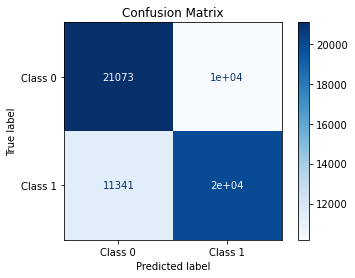

              precision    recall  f1-score   support

     Class 0       0.65      0.67      0.66     31258
     Class 1       0.66      0.64      0.65     31258

    accuracy                           0.66     62516
   macro avg       0.66      0.66      0.66     62516
weighted avg       0.66      0.66      0.66     62516



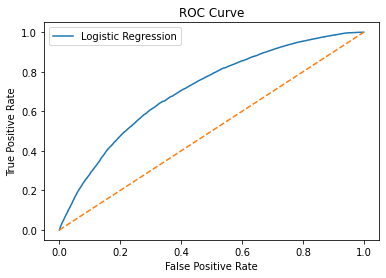

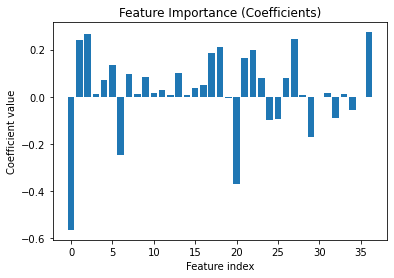

In [12]:
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, roc_curve

# Assuming X_train, X_test, y_train, y_test are already defined
# Assuming you have binary classification with class labels 0 and 1

# Fit a logistic regression model
model = LogisticRegression()
model.fit(X_train_scaled_df, y_train)

# Predictions
y_pred = model.predict(X_val_scaled_df)
y_prob = model.predict_proba(X_val_scaled_df)[:, 1]

# Plotting confusion matrix
plot_confusion_matrix(lr_clf, X_val_scaled_df, y_val, display_labels=['Class 0', 'Class 1'], cmap=plt.cm.Blues, normalize=None)
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_val, y_pred, target_names=['Class 0', 'Class 1']))

# Plotting ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
plt.plot(fpr, tpr, label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Feature importances (coefficients)
coefficients = lr_clf.coef_[0]
plt.bar(range(len(coefficients)), coefficients)
plt.xlabel('Feature index')
plt.ylabel('Coefficient value')
plt.title('Feature Importance (Coefficients)')
plt.show()


In [13]:
feature_names = X_train_scaled_df.columns

# Get the coefficients from the trained model
coefficients = lr_clf.coef_[0]

# Combine feature names and coefficients into a DataFrame
feature_importances = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})

# Sort the features by the absolute value of their coefficient
feature_importances = feature_importances.reindex(feature_importances.coefficient.abs().sort_values(ascending=False).index)

# Display the feature importances
print(feature_importances)


                         feature  coefficient
0                      num_words    -0.564796
20                    dale_chall    -0.372104
36       avg_dependency_distance     0.273602
2               num_unique_words     0.265829
27              parse_tree_depth     0.246254
6         avg_syllables_per_word    -0.245211
1                 num_characters     0.239945
18          gunning_fog_category     0.209803
22                       low_aoa     0.198805
17  flesch_reading_ease_category     0.185935
29               num_noun_chunks    -0.170327
21                      high_aoa     0.164210
5                 syllable_count     0.133726
13                  pos_NN_count     0.102634
24            non_concrete_count    -0.099738
7              lexical_diversity     0.096072
25             mean_concreteness    -0.093290
32                     num_nsubj    -0.090987
9        multiple_meanings_count     0.084678
23                concrete_count     0.080692
26     mean_subtlex_us_frequency  

In [ ]:
rf_clf = RandomForestClassifier(random_state=42,n_estimators=200,max_depth=15, n_jobs=-1).fit(X_train_scaled_df, y_train)
preds = rf_clf.predict(X_val_scaled_df)
acc_score = accuracy_score(y_val, preds)
print(acc_score)

In [ ]:
# Refit the classifier on the full training and validation set
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)
lr_clf = LogisticRegression(random_state=42, n_jobs=-1).fit(X_scaled,y)

# Predict X_test
y_test_pred = lr_clf.predict(X_test_scaled)

# Create a DataFrame with 'id' and 'label' columns
results_df = pd.DataFrame({'id': test_df['id'], 'label': y_test_pred})

# Save the results to a CSV file
results_df.to_csv('lr_predictions.csv', index=False)

In [ ]:
#refit if needed for full data on random forest
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)
rf_clf = RandomForestClassifier(random_state=42,n_estimators=100,max_depth=7, n_jobs=-1).fit(X_scaled,y)
# Predict X_test
y_test_pred = rf_clf.predict(X_test_scaled)

# Create a DataFrame with 'id' and 'label' columns
results_df = pd.DataFrame({'id': test_df['id'], 'label': y_test_pred})

# Save the results to a CSV file
results_df.to_csv('rf_predictions.csv', index=False)

In [ ]:
#max depth 10 and tol .001 did the best so far, trying deeper depth
gb_model = GradientBoostingClassifier(n_estimators = 200, max_depth = 15,
                                    random_state=42,verbose=1,n_iter_no_change=10,tol=0.001).fit(X_train_scaled_df,y_train)
preds = gb_model.predict(X_val_scaled_df)
acc_score = accuracy_score(y_val, preds)
print(acc_score)


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)
gb_model = GradientBoostingClassifier(n_estimators = 200, max_depth = 15,
                                    random_state=42,verbose=1,n_iter_no_change=10,tol=0.001).fit(X_scaled,y)
# Predict X_test
y_test_pred = gb_model.predict(X_test_scaled)

# Create a DataFrame with 'id' and 'label' columns
results_df = pd.DataFrame({'id': test_df['id'], 'label': y_test_pred})

# Save the results to a CSV file
results_df.to_csv('gb_predictions.csv', index=False)

In [ ]:
from sklearn.svm import SVC

In [ ]:
svm_model = SVC(kernel='rbf', random_state=42)

# Train the SVM model
svm_model.fit(X_train_scaled_df,y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test_scaled_df)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
# Detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
#keep lemmatized sentence for text transformations
def df_copy_text(df):
    X = df.copy()
    X = X.drop(['original_text','clean_text','tokens'],axis=1)
    if 'id' in df.columns:
        X = X.drop('id',axis=1)
    y = X.pop('label')
    return X, y


X, y = df_copy_text(train_df)
X_test, _ = df_copy_text(test_df)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42,stratify=y)

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english',min_df=70,max_df=0.75,strip_accents='unicode')
X_train_tf = vectorizer.fit_transform(X_train['lemmatized_text'])
X_val_tf = vectorizer.transform(X_val['lemmatized_text'])
# Scale the data
scaler_vec = StandardScaler(with_mean=False)  # use with_mean=False for sparse data

scaled_tfidf_train = scaler_vec.fit_transform(X_train_tf)
scaled_tfidf_val = scaler_vec.transform(X_val_tf)


 

In [ ]:
lr_clf_vec = LogisticRegression(random_state=42, n_jobs=-1).fit(scaled_tfidf_train,y_train)
preds = lr_clf_vec.predict(scaled_tfidf_val)
acc_score = accuracy_score(y_val, preds)
print(acc_score)

In [ ]:
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1).fit(scaled_tfidf_train, y_train)
preds = rf_clf.predict(scaled_tfidf_val)
acc_score = accuracy_score(y_val, preds)
print(acc_score)

In [ ]:
# #1000 catches .11 percent
# svd = TruncatedSVD(n_components=2000)
# svd.fit(scaled_tfidf_train)
# cumulative_explained_variance = sum(svd.explained_variance_ratio_)
# print(cumulative_explained_variance)

In [ ]:
svd = TruncatedSVD(n_components=100)
svd_train = svd.fit_transform(scaled_tfidf_train)
svd_val = svd.transform(scaled_tfidf_val)

In [ ]:
#100 components got .6094
#1000 components got .6275
lr_clf_vec = LogisticRegression(random_state=42, n_jobs=-1).fit(svd_train,y_train)
preds = lr_clf_vec.predict(svd_val)
acc_score = accuracy_score(y_val, preds)
print(acc_score)

In [ ]:
#with 1000 svd components and additional features, score goes to 0.6647
# Scale the additional features
scaler_additional = StandardScaler()
num_features_train = scaler_additional.fit_transform(X_train.drop('lemmatized_text',axis=1))
num_features_val = scaler_additional.transform(X_val.drop('lemmatized_text',axis=1))

# Concatenate SVD features with additional features
combined_features_train = np.hstack((svd_train, num_features_train))
combined_features_val = np.hstack((svd_val, num_features_val))

rf_clf = RandomForestClassifier(random_state=42).fit(combined_features_train,y_train)
rf_preds = rf_clf.predict(combined_features_val)

# Evaluate the classifier on the validation set
score = classifier.score(y_val, rf_preds)  # Assuming y_val is your target for the validation set
print(f"Validation Score: {score}")


In [ ]:
gb_model_vec = GradientBoostingClassifier(n_estimators = 300, max_depth = 15,
                                    random_state=42,verbose=1,n_iter_no_change=10,tol=0.001,n_jobs=-1).fit(combined_features_train,y_train)
score = gb_model_vec.score(combined_features_val, y_val) 
print(f"Validation Score: {score}")

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Convert the embeddings to numpy array (df['bert_embeddings'] is a series of tensors)
embeddings = torch.stack(df['bert_embeddings'].tolist()).numpy()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)

# Train a classifier
clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(X_train, y_train)

# Make predictions
predictions = clf.predict(X_test)

# Evaluate the model
score = f1_score(y_test, predictions)
print(f'F1 Score: {score}')
